# TFG Alberto Pampín

## Descripción del dataset

En primer lugar hay que realizar los imports necesarios:

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Se realiza la carga del fichero .csv que contiene los datos:

In [2]:
#csv_path = '../data/2_Oct2019.csv'
csv_path = '../data/historico_10_19_02_20.csv'
df = pd.read_csv(csv_path)

En este fichero se encuentran las mediciones que han realizado los sensores instalados en la ciudad de Santiago
de Compostela desde Octubre-2019 hasta Febrero-2020 (ambos incluidos).

**NOTA**: Al tratarse de un problema real las mediciones realizadas a partir de Marzo-2020 se han visto afectadas por
las restricciones sanitarias a causa del COVID-19, es por eso que no se tomarán en cuenta las mediciones a partir
de dicha fecha.

Ahora veamos cómo son los datos:

In [3]:
df.head()

_id  speed sensor  flow                                                FID  \
0    1  -9999  PM084    12  historic_traffic_observations_2019_10.fid-76a8...   
1    2  -9999  PM036    12  historic_traffic_observations_2019_10.fid-76a8...   
2    3  -9999  PM037     0  historic_traffic_observations_2019_10.fid-76a8...   
3    4  -9999  PM083    12  historic_traffic_observations_2019_10.fid-76a8...   
4    5  -9999  PM082    12  historic_traffic_observations_2019_10.fid-76a8...   

              datetime  
0  2019-10-01T00:00:00  
1  2019-10-01T00:00:00  
2  2019-10-01T00:00:00  
3  2019-10-01T00:00:00  
4  2019-10-01T00:00:00

Las columnas del dataset son las siguientes:
* `_id` (Integer): Identificador de la medición dentro del mes
* `speed` (Integer): NA
* `sensor` (String): Nombre del sensor que realizó la medición
* `flow` (Integer): Su valor entre 12 muestra el número de vehículos que pasaron sobre el sensor en los últimos 5 minutos
* `FID` (String): Identificador de la medición global -> PRIMARY KEY
* `datetime` (Timestamp): Fecha y hora en la que se tomó la medición.
Cada sensor inserta una nueva medición cada 5 minutos

In [4]:
df.shape

(2904410, 6)

Hay un total de **2904410 mediciones** y **6 columnas**.

Algunos datos interesantes sobre el dataset:

In [5]:
df.describe().transpose()

count           mean            std     min       25%       50%  \
_id    2904410.0  292897.638104  171773.694631     1.0  145221.0  290441.5   
speed  2904410.0   -9999.000000       0.000000 -9999.0   -9999.0   -9999.0   
flow   2904410.0     148.064983     391.402798     0.0       0.0      48.0   

            75%       max  
_id    435662.0  638663.0  
speed   -9999.0   -9999.0  
flow      228.0   99999.0

El max de `flow` y por ende el de `car_count` no parece un número muy normal, y menos
tratándose de una ciudad como Santiago de Compostela, dónde es imposible que circulen 8333
vehículos sobre un sensor en 5 minutos:

<AxesSubplot:>

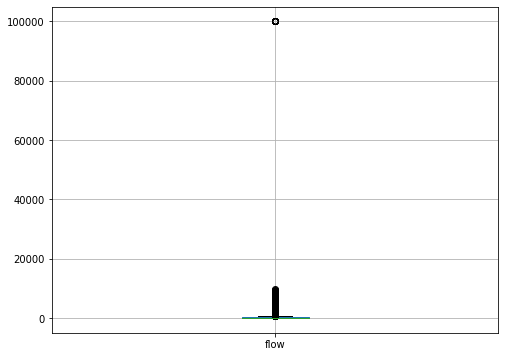

In [6]:
df.boxplot(column=['flow'])

In [7]:
bad_flow = df.loc[df['flow'] == 99999]
len(bad_flow)

31

Hay 31 mediciones con un valor erróneo para la columna `flow`: **Es necesario arreglar estos valores extremos!**

## Procesamiento del dataset

Algunos de los datos del dataset no interesan, bien porque su valor no es válido (`speed`) o bien porque
son simples identificadores (`_id` y `FID`). También se deberán formatear otras columnas:

In [8]:
df.pop('speed')
df.pop('FID')
df.pop('_id')

df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'datetime'], format='%Y-%m-%dT%H:%M:%S')

df['car_count'] = df.loc[:, 'flow'] // 12

# Ordena por fecha.
# ignore_index = True -> Pone los index del 0 al n-1 (todos por orden)
# inplace = True -> Para que ya lo haga sobre el df en vez de devolver el df ordenado
df.sort_values(by='datetime', ignore_index = True, inplace = True)

In [9]:
df

sensor  flow            datetime  car_count
0        PM084    12 2019-10-01 00:00:00          1
1        PM059     0 2019-10-01 00:00:00          0
2        PM017    48 2019-10-01 00:00:00          4
3        PM052     0 2019-10-01 00:00:00          0
4        PM016    48 2019-10-01 00:00:00          4
...        ...   ...                 ...        ...
2904405  PM039     0 2020-02-29 23:55:00          0
2904406  PM074     0 2020-02-29 23:55:00          0
2904407  PM075     0 2020-02-29 23:55:00          0
2904408  PM024    48 2020-02-29 23:55:00          4
2904409  PM038     0 2020-02-29 23:55:00          0

[2904410 rows x 4 columns]

Acciones realizadas:
1. La columna `speed` no aporta nada, todos su valores son -9999
2. La columna `FID` tampoco, es un identificador de cada medición, al igual que `_id`
3. La columna `datetime` tuvo que ser formateada para obtener un formato válido
4. La columna `flow` es útil, pero es más interesante conocer el número de vehículos que
 pasaron sobre el sensor en los últimos 5 minutos: `car_count`
5. Se han ordenado todas las entradas por el campo `datetime`

Seleccionemos 5 mediciones al azar:

In [10]:
df.sample(n=5)

sensor  flow            datetime  car_count
1530681  PM017   564 2019-12-20 17:30:00         47
1884800  PM023     0 2020-01-09 14:50:00          0
1974233  PM063    72 2020-01-13 21:05:00          6
1468225  PM063   408 2019-12-17 13:35:00         34
2731256  PM075     0 2020-02-21 17:10:00          0

Veamos algunas estadísticas del conjunto de datos:

In [11]:
df.describe().transpose()

count        mean         std  min  25%   50%    75%      max
flow       2904410.0  148.064983  391.402798  0.0  0.0  48.0  228.0  99999.0
car_count  2904410.0   12.309273   32.616128  0.0  0.0   4.0   19.0   8333.0

Como ya se comentó en la sección anterior, existen 31 outlayers claros ( valor 99999.0 en la columna `flow`) que deben
ser eliminados:

In [12]:
df = df[df['flow'] != 99999.0]
df = df[df['car_count'] != 8333.25]

Podemos ver que ya no hay ninguna fila con `flow == 99999.0`:

In [13]:
bad_flow = df.loc[df['flow'] == 99999.0]
len(bad_flow)

0

Revisando de nuevo las estadísticas del dataset:

In [14]:
df.describe().transpose()

count        mean         std  min  25%   50%    75%     max
flow       2904379.0  146.999220  216.285009  0.0  0.0  48.0  228.0  9672.0
car_count  2904379.0   12.220462   18.023441  0.0  0.0   4.0   19.0   806.0

<AxesSubplot:>

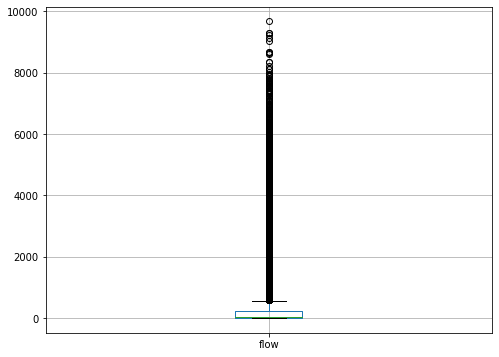

In [15]:
df.boxplot(column=['flow'])

A simple vista no se ven outlayers tan claros como anteriormente. Debido a que `flow` solo resulta de interés para
calcular `car_count`, esta característica puede ser eliminada ya del dataset.

In [16]:
df.pop('flow')

0          12
1           0
2          48
3           0
4          48
           ..
2904405     0
2904406     0
2904407     0
2904408    48
2904409     0
Name: flow, Length: 2904379, dtype: int64

## Experimentos planteados

Los experimentos a realizar consisten en predecir el tráfico en el punto en el que se ubica el
sensor `PM072` (CITIUS) en un instante `t` a partir de las mediciones realizadas por otros
sensores en un instante `t-x`. Los experimentos contemplados son los siguientes:

1. Predecir en `PM072` a partir de:
    - `PM029` (Entrada túnel Romero Donallo)
    - **No es posible, ya que ese sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)

2. Predecir en `PM072` a partir de:
    - `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
    - `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
    - `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
    - **No es posible, ya que ese sensor estaba averiado** -`PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

3. Predecir en `PM072` a partir de:
    - `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
    - `PM076` (Rúa do Horreo - Rotonda Galuresa)
    - `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
    - `PM079` (Rúa do Horreo - Rotonda Galuresa)

4. Predecir en `PM072` a partir de:
    - Todos los sensores disponibles

Para cada uno de los experimentos anteriormente citados se llevará a cabo la implementación del modelo con:
* Perceptrón multicapa
* Red Neuronal Convolucional (CNN)
* Red Neuronal Recurrente (RNN)

Asimismo, se deberá realizar un análisis de la varianza y bias para cada experimento
(Ver 6 primeras semanas Machine Learning Stanford: https://www.coursera.org/learn/machine-learning)

Por otra parte, también se probarán diversas formas de incluir las marcas temporales (timestamps) en el modelo:
* Día de la semana (1-7) y hora del día (minutos)
* Día de la semana y hora del día *modelado con sin y cos*
* Ventanas temporales (¿?)

## Experimento #1

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #1** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
* `PM029` (Entrada túnel Romero Donallo)
* **No es posible, ya que es sensor estaba averiado** - `PM034`(Rotonda Camiño Novo - Avda. Mestre Mateo)


### Análisis dataset Experimento #1

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [17]:
sensors_list = ['PM029', 'PM072']
df_1 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [18]:
df_1.describe().transpose()

count       mean        std  min  25%   50%   75%   max
car_count  78690.0  16.797547  14.859483  0.0  4.0  13.0  26.0  92.0

Veamos un boxplot:

<AxesSubplot:>

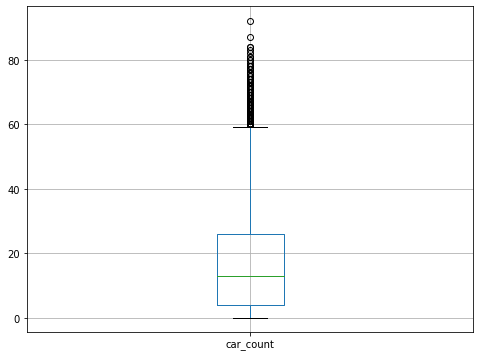

In [19]:
df_1.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`. Hay que tener en cuenta que los datos
que se encuentran fuera de la caja o de los brazos de la misma, no pueden ser considerados outlayers automáticamente.
Al tratarse de mediciones de tráfico, es evidente que a ciertas horas del día (principalmente de madrugada), el número de
coches registrado suele ser muy bajo incluso 0, por lo que la media y los cuartiles se encuentran afectados por estas
medicones.

### Análisis gráfico Experimento #1

Para ver la evolución de los datos del tráfico de manera más intuitiva se realizarán una serie de representaciones
gráficas.

La siguiente función recibe un dataframe, una lista de días y el nombre de un sensor. Grafica todas las mediciones
realizadas por ese sensor (agregados de 5 minutos) a lo largo de los días indicados

In [20]:
def plot_sensors_daily_data(df_orig, days_list, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df_plot = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    fig, axs = plt.subplots(days_list.shape[0])
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df_plot.loc[(df_plot['datetime'] >= days_list[i]) & (df_plot['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y = df_plot.loc[(df_plot['datetime'] >= days_list[i]) & (df_plot['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        axs[i].plot(x, y)

        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 100, 20))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))
        axs[i].grid()

    #plt.savefig('../img/PM072_W_Evolution.pdf', bbox_inches='tight', transparent=True, dpi=300)

Podemos probar a pasarle los 7 días de una semana para ver como evoluciona el tráfico que pasa
por ese sensor durante esa semana:

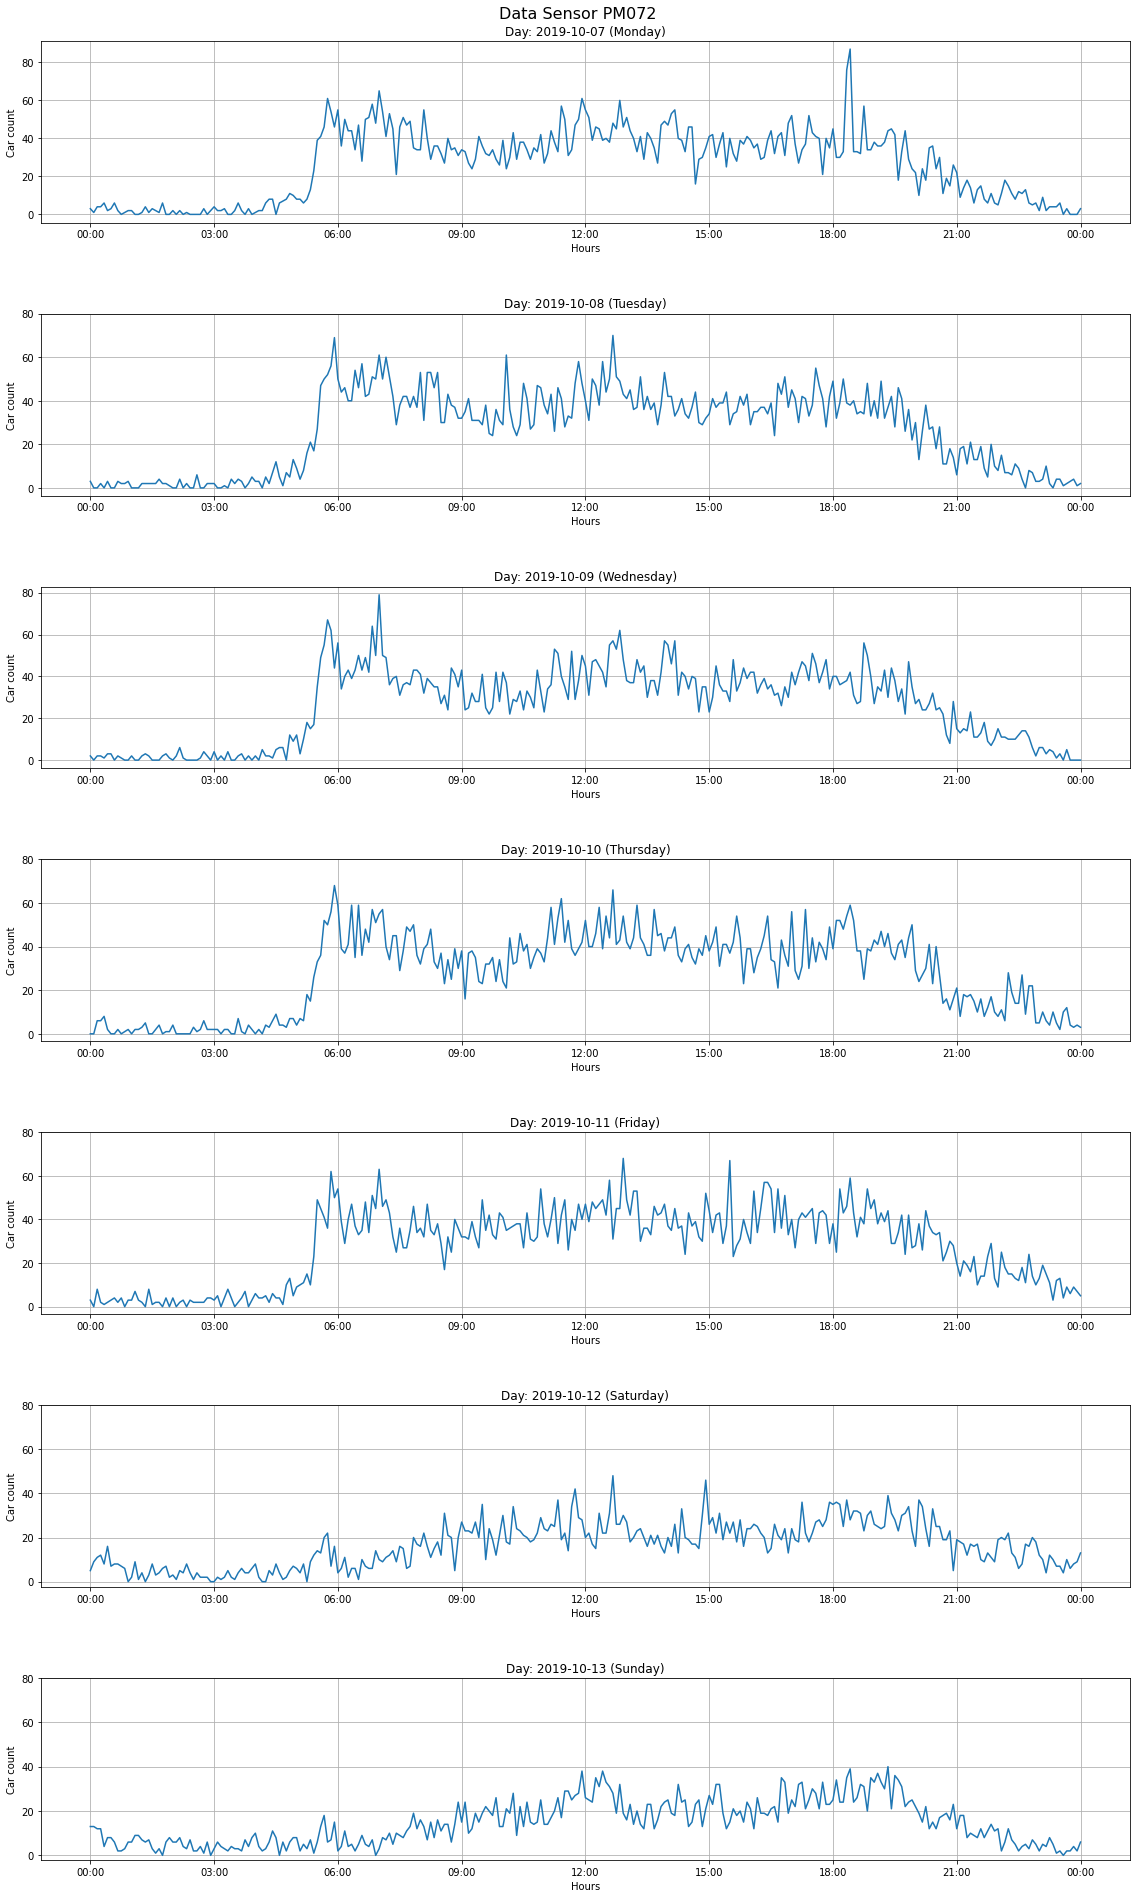

In [21]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

También podemos graficar los lunes (o cualquier día de la semana: W-SUN, W-FRI) que hubo en un mes:

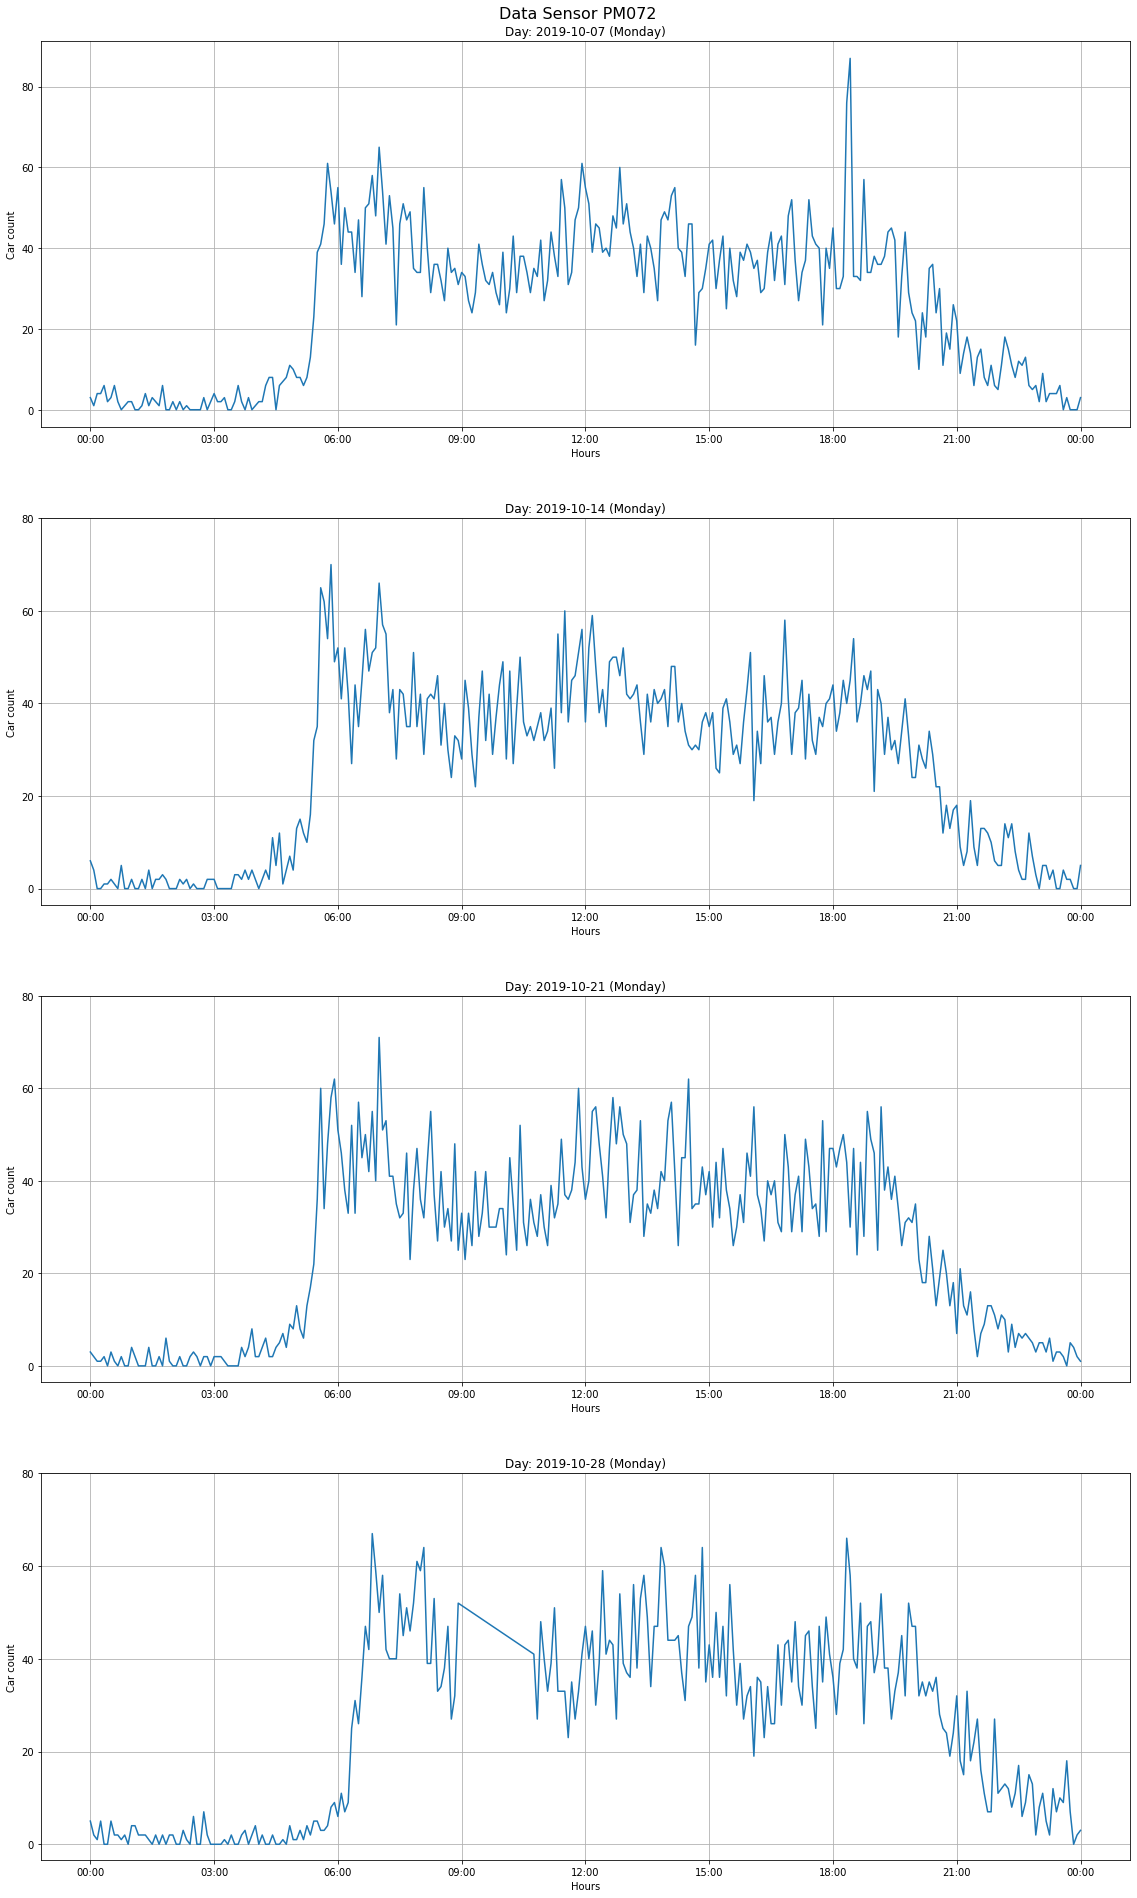

In [22]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_daily_data(df_orig=df_1, days_list = days, sensor='PM072')

Las gráficas anteriores tienen mucho ruido, aunque resultan útiles para hacer una comprobación de outlayers.
Sin embargo, para ver de una manera más directa si existe periodicidad en el tráfico es más interesante **representar
los datos con agregados superiores a 5 minutos**

La siguiente función recibe un dataframe, una lista de días, un valor `n` que indica el número de mediciones agregadas,
y el nombre de un sensor. Grafica la media (mean) y desviación típica (std) de las mediciones realizadas durante el sensor
durante esos días en **agregados de 5*n minutos**

In [23]:
def plot_sensors_agregated_daily_data(df_orig, days_list, n, sensor):

    # Solo selecciono la información de ese sensor en el rango indicado
    df_plot = df_orig.loc[(df_orig['sensor'] == sensor)
                     & (df_orig['datetime'] >= days_list[0])
                     & (df_orig['datetime'] <= days_list[-1]+datetime.timedelta(days=1))]

    # Dataframe con los agregados
    df_mean = pd.DataFrame(columns=df_plot.columns)
    df_std = pd.DataFrame(columns=df_plot.columns)

    for g, df_slice in df_plot.groupby(np.arange(len(df_plot)) // n):
        mean_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].mean()}
        df_mean = df_mean.append(mean_row, ignore_index=True)

        std_row = {'sensor': sensor, 'datetime': df_slice['datetime'].max(), 'car_count': df_slice['car_count'].std()}
        df_std = df_std.append(std_row, ignore_index=True)

    fig, axs = plt.subplots(days_list.shape[0])
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Data Sensor ' + sensor, fontsize=16)

    for i in range(days_list.shape[0]):
        x = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'datetime']
        y_mean = df_mean.loc[(df_mean['datetime'] >= days_list[i]) & (df_mean['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']
        y_std = df_std.loc[(df_std['datetime'] >= days_list[i]) & (df_std['datetime'] <= days_list[i]+datetime.timedelta(days=1)), 'car_count']

        axs[i].plot(x, y_mean, label='MEAN')
        axs[i].plot(x, y_std, label='STD')

        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 100, 20))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title('Day: '+ days_list[i].strftime("%Y-%m-%d (%A)"))
        axs[i].legend(loc='upper left')
        axs[i].grid()

   # plt.savefig('../img/PM072_Agg_W_Evolution.pdf', bbox_inches='tight', transparent=True, dpi=300)


Veamos la evolución del tráfico (media y desviación típica) durante una semana con agregados de 30 minutos (5*6)

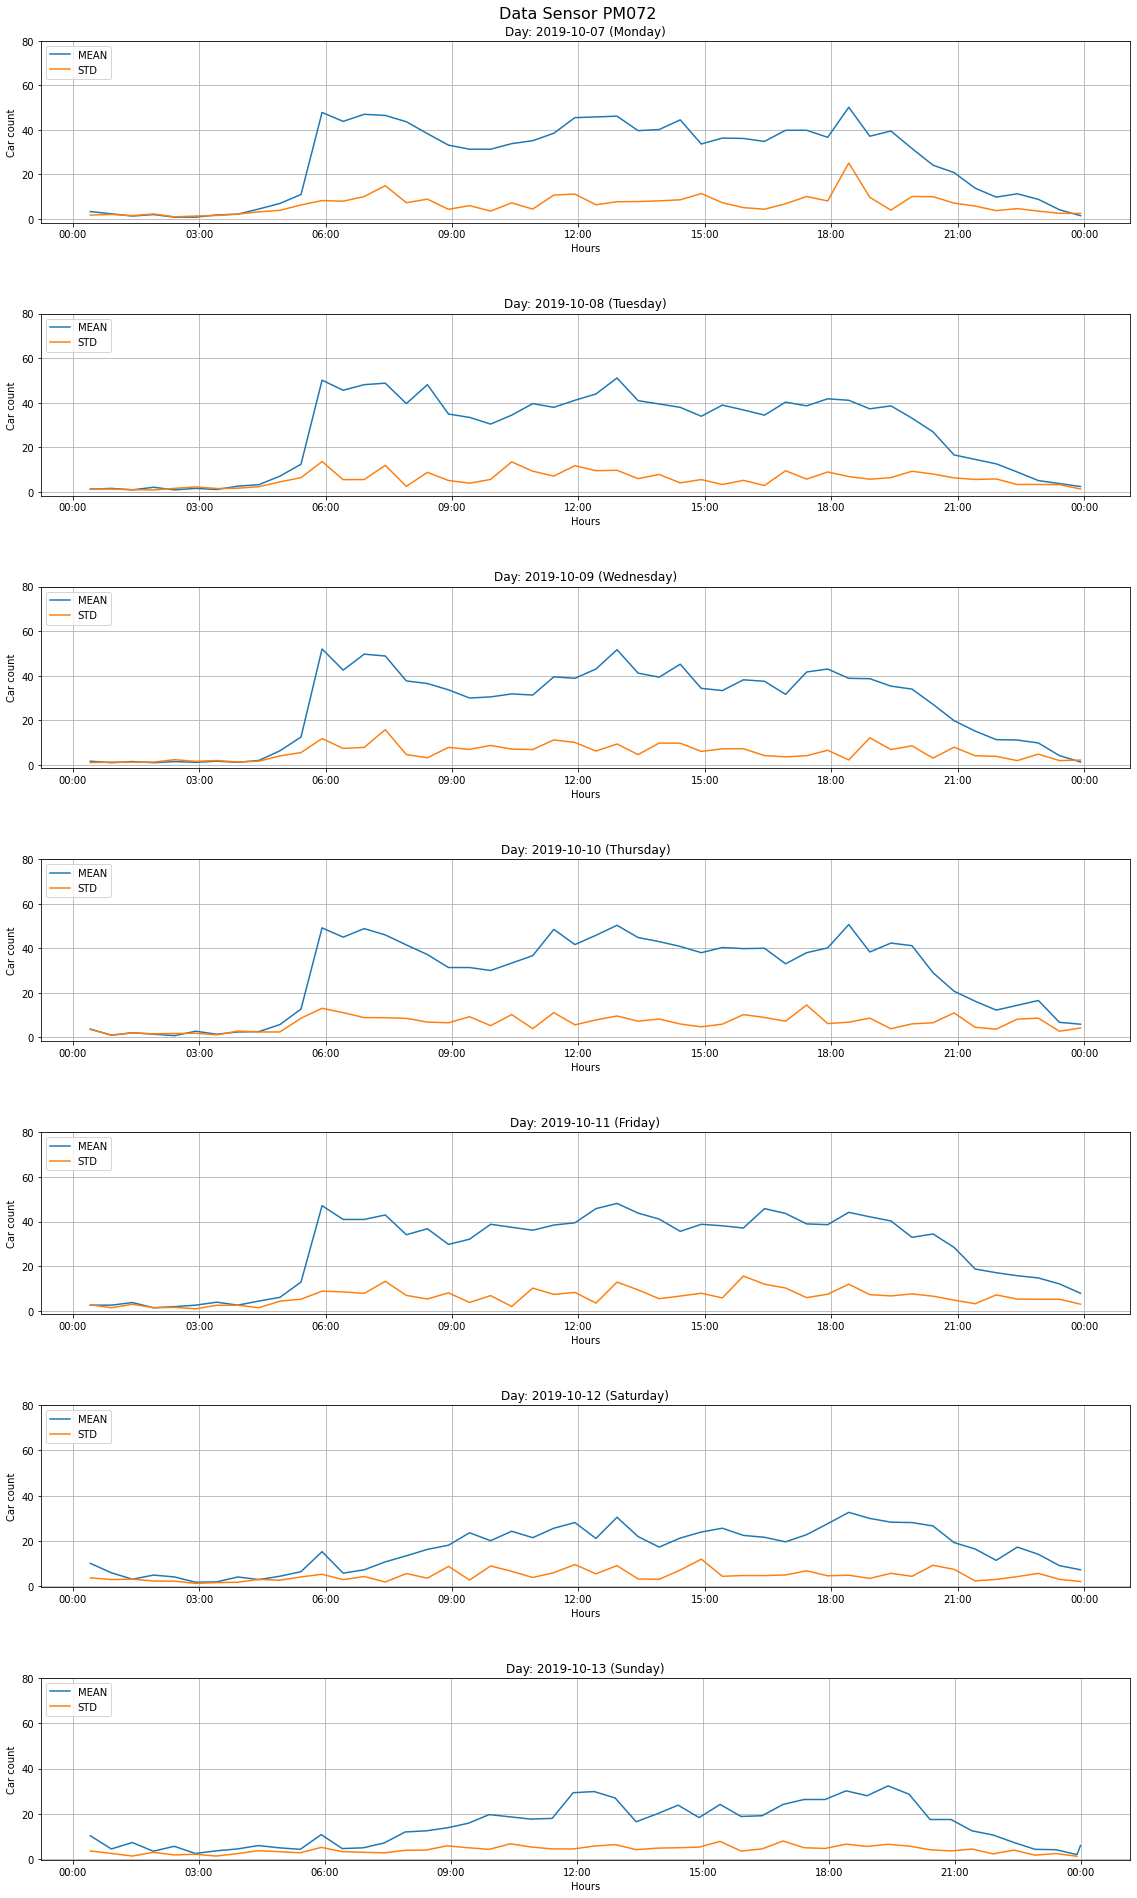

In [24]:
days = pd.date_range(start='2019-10-07', end='2019-10-13', freq='D')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

Veamos la evolución del tráfico durante los lunes de un mes con agregados de 30 minutos (5*6)

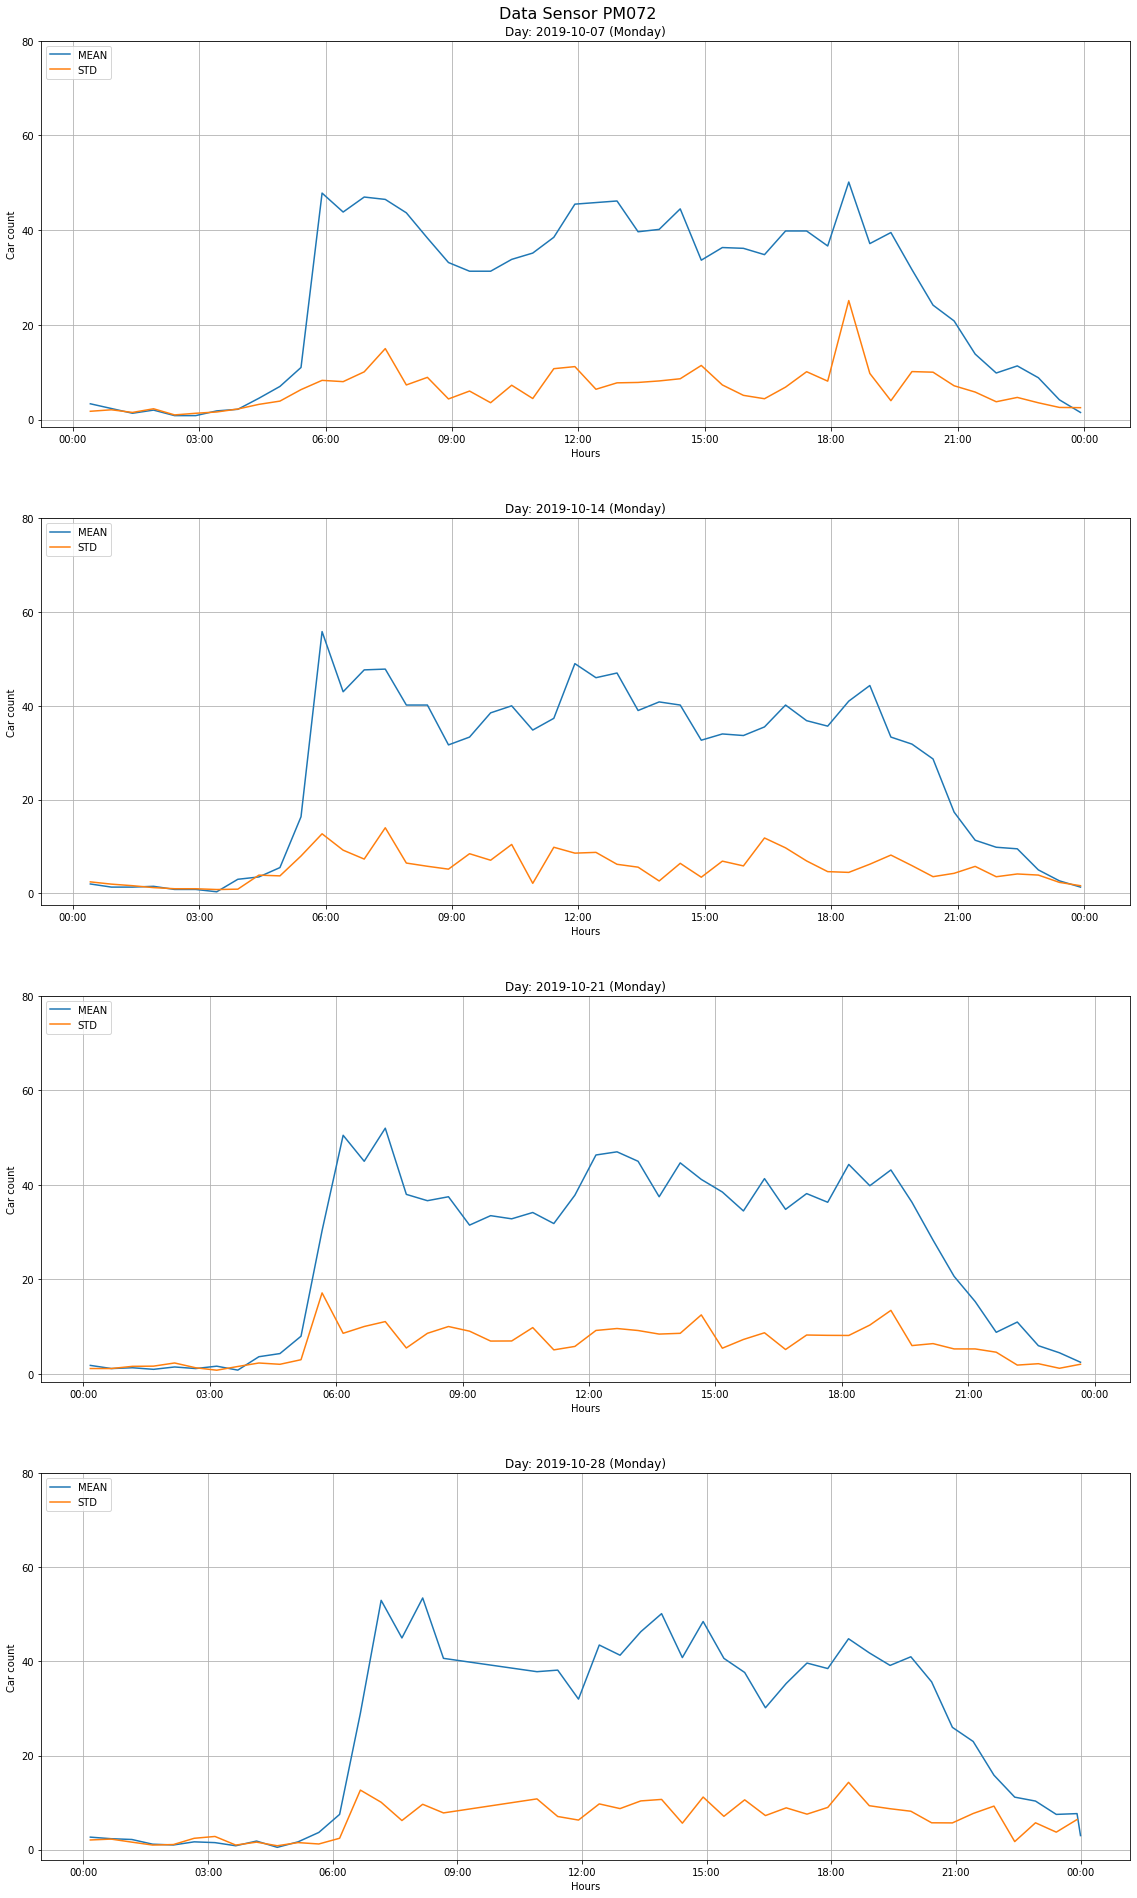

In [25]:
days = pd.date_range(start='2019-10-01', end='2019-10-31', freq='W-MON')
plot_sensors_agregated_daily_data(df_orig=df_1, days_list = days, n=6, sensor='PM072')

### Preparación dataset Experimento #1

#### Label PM072

El objetivo del Experimento #1 e predecir el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS)
en un instante `t` a partir de las mediciones realizadas en un instante `t-x` por el sensor `PM029`.

A cualquier modelo es necesario pasarle un vector de características con el que pueda trabajar. En este caso, el vector
de características tiene la siguiente forma:

In [26]:
column_names = ['datetime', 'car_count_PM029', 'label_PM072']
pd.DataFrame(columns = column_names)

Empty DataFrame
Columns: [datetime, car_count_PM029, label_PM072]
Index: []

Es decir, para cada instante temporal (`datetime`) que hay en el dataset, debe haber un vector de características que
contenga dicho instante temporal y el valor medido por los sensores que se usarán para predecir. Asimismo, también debe
contener el valor medido por el sensor `PM072` `x minutos` después.

Los sensores pueden fallar o detenerse por labores de mantenimiento, por lo que es posible que en algún instante temporal
uno de los sensores tome una medición y otro no, quedando así el vector de características incompleto. Esto no puede
permitirse, por lo que **si falta una medición de un sensor para un determinado instante temporal, todas las mediciones
correspondientes a dicho instante deben ser eliminadas.**

Para facilitar la preparación del dataset se ha creado la siguiente función. Recibe el dataset original, la lista de sensores
que se usarán para predecir, el sensor en el que se quiere predecir y los `x minutos` de desfase temporal.


In [27]:
def prepare_df(df_orig, sensors_list, label_sensor, x):

    # Instante temporal y car_count de dicho sensor
    prepared_df = df_orig.loc[ df_orig['sensor'] == sensors_list[0] , ['datetime', 'car_count']]
    # Renombrar la columna car_count
    prepared_df.rename(columns={'car_count': 'car_count_' + sensors_list[0]}, inplace=True)

    # MERGE no tiene en cuenta los index. Los reinicia y los pone del 0 al n-1 (todos en orden)
    # INNER JOIN con los datos de cada sensor de la lista (sin contar el primero),
    # asi evito el problema de que falten mediciones de algunos sensores en un determinado instante temporal
    for ss in sensors_list[1:]:
        aux = df_orig.loc[ df_orig['sensor'] == ss, ['datetime', 'car_count']]
        aux.rename(columns={'car_count': 'car_count_' + ss}, inplace=True)
        prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    # Obtengo los datos del sensor a predecir x minutos despues
    aux = df_orig.loc[ df_orig['sensor'] == label_sensor, ['datetime', 'car_count']]
    # Resto los x minutos de para poder hacer el JOIN y MANTENIENDO EL CAR_COUNT que interesa
    aux['datetime'] = aux['datetime'] - datetime.timedelta(minutes=x)
    aux.rename(columns={'car_count': 'label_' + label_sensor}, inplace=True)
    prepared_df = pd.merge(prepared_df, aux, on='datetime', how='inner')

    return prepared_df

A continuación, se utiliza la función para preparar el dataset para el Experimento #1:

In [28]:
sensors_list = ['PM029']
df_1 = prepare_df(df_1, sensors_list, label_sensor='PM072', x = 5)

In [29]:
df_1

datetime  car_count_PM029  label_PM072
0     2019-10-01 00:00:00                1            0
1     2019-10-01 00:05:00                0            0
2     2019-10-01 00:10:00                0            0
3     2019-10-01 00:15:00                0            0
4     2019-10-01 00:20:00                0            1
...                   ...              ...          ...
38784 2020-02-29 23:30:00                4            8
38785 2020-02-29 23:35:00                0            7
38786 2020-02-29 23:40:00                3           11
38787 2020-02-29 23:45:00                3           22
38788 2020-02-29 23:50:00                7           20

[38789 rows x 3 columns]

**El `df_1` está ordenado por fecha y los Index van del 0 al n-1 (todos en orden)**

#### Tiempo

Antes de construir un modelo es importante entender los datos con los que se trabaja y estar seguro que los datos
que se le pasan al modelo está correctamente formateados.

Observando ls gráficas anteriores se puede observar claramente que el tráfico tiene un comportamiento
cíclico según la *hora del día* y del *día de la semana*. Es decir, el tráfico de cada lunes durante todas las horas
del día es muy similar. A continuación se codificará este comportamiento:

#### Horas del día

Una de las formas más comunes para representar características cíclicas es mediante el uso de la función seno y la función
coseno [REFERENCIA]. En primer lugar, es necesario recuperar las horas y minutos de las fechas y convertirlo en segundos (o en minutos):

In [30]:
date_time = pd.to_timedelta(df_1['datetime'].dt.strftime('%H:%M:%S'))
date_time_s = date_time.dt.total_seconds().astype(int)

El tiempo en segundos no resulta muy útil como input para el modelo. Está claro que la periodicidad del tráfico es diaria.

Para convertir el tiempo en una señal usable se puede usar el seno y el coseno:

In [31]:
seconds_in_day = 24*60*60
df_1['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
df_1['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

De esta manera se logra modelar las horas como en un reloj, las 00h y están a continuación de las 23h.

La gráfica correspondiente al primer día del dataset es la siguiente ([:288] porque cada hora hay 12 mediciones * 24h = 288):

Text(0.5, 1.0, 'Time of day signal')

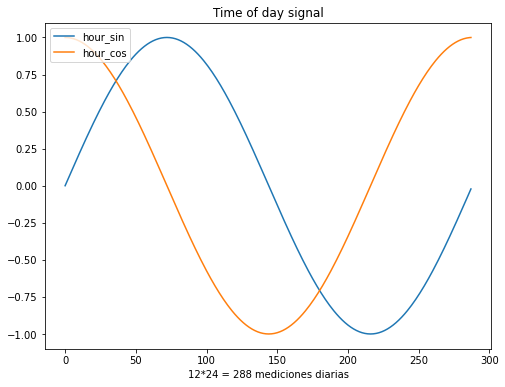

In [32]:
plt.plot(df_1[ 'hour_sin'][:288], label = 'hour_sin')
plt.plot(df_1['hour_cos'][:288], label = 'hour_cos')
plt.legend(loc='upper left')
plt.xlabel('12*24 = 288 mediciones diarias')
plt.title('Time of day signal')

Si solamente se observa la función seno, al trazar una línea horizontal se cruza en dos puntos, por lo que sólo teniendo
en cuenta esta característica, las 00:00h y las 12:00h son lo mismo. Para solucionar esto se toma en consideración el coseno, con ambas
características ya es posible distinguir esas horas y todo codificado de manera cíclica.

Una forma más intuitiva de ver lo que acabamos de hacer es representar ambas características como si se tratase un reloj:

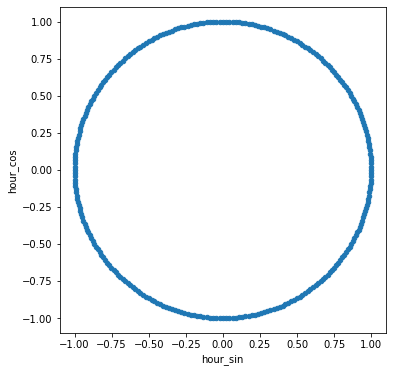

In [33]:
df_1[:288].plot.scatter('hour_sin','hour_cos').set_aspect('equal');

**Comentario personal:** Fíjate en las tablas a continuación que, evidentemente,
hour_sin` y  `hour_cos` son iguales para 2019-10-01 00:00:00 y 2019-10-02 00:00:00.
Como nos interesa que también se tenga en cuenta el día de la semana tenemos que hacer algo más!!

In [34]:
df_1[:2]

datetime  car_count_PM029  label_PM072  hour_sin  hour_cos
0 2019-10-01 00:00:00                1            0  0.000000  1.000000
1 2019-10-01 00:05:00                0            0  0.021815  0.999762

In [35]:
df_1[288:290]

datetime  car_count_PM029  label_PM072  hour_sin  hour_cos
288 2019-10-02 00:00:00                1            2  0.000000  1.000000
289 2019-10-02 00:05:00                1            4  0.021815  0.999762

#### Días de la semana

Tal y como hemos visto en las gráficas durante el `Análisis gráfico`, el tráfico tiene una clara frecuencia semanal.
Se puede ver cómo las gráficas de cada uno de los lunes (por ejemplo) son muy similares. Esto es algo que nos interesa
que nuestro modelo conozca, por lo que tenemos que realizar un trabajo similar al que hemos realizado con las horas.
*Los días de la semana también son cíclicos!*

In [36]:
wday = df_1['datetime'].dt.weekday
days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
df_1['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
df_1['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

Nuevamente, en una representación circular, vemos los 7 días de la semana:

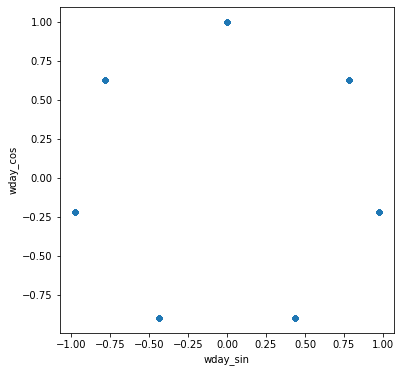

In [37]:
df_1.plot.scatter('wday_sin','wday_cos').set_aspect('equal');

**Comentario personal:** Cada uno de los 7 puntos que vemos contiene 288 puntos (hay 288 mediciones cada día).
En la siguiente tabla podemos ver como cada día de la semana (del 0 al 6) tiene un `wday_sin` y `wday_cos` diferente!!

In [38]:
df_1[0:2000:288]

datetime  car_count_PM029  label_PM072  hour_sin  hour_cos  \
0    2019-10-01 00:00:00                1            0  0.000000  1.000000   
288  2019-10-02 00:00:00                1            2  0.000000  1.000000   
576  2019-10-03 00:00:00                0            1  0.000000  1.000000   
864  2019-10-04 13:50:00               18           50 -0.461749 -0.887011   
1152 2019-10-05 13:50:00                5           15 -0.461749 -0.887011   
1440 2019-10-06 13:50:00               10           12 -0.461749 -0.887011   
1728 2019-10-07 13:50:00               17           49 -0.461749 -0.887011   

      wday_sin  wday_cos  
0     0.781831  0.623490  
288   0.974928 -0.222521  
576   0.433884 -0.900969  
864  -0.433884 -0.900969  
1152 -0.974928 -0.222521  
1440 -0.781831  0.623490  
1728  0.000000  1.000000

#### Características auxiliares/extra

Durante la preparación se utilizaron/crearon columnas extra en el dataset que no aportarán nada a nuestro modelo.
Estas deben ser eliminadas antes del entrenamiento.

(Se mantienen para facilitar la graficación posterior)

#### Dataset final para Experimento #1

Finalmente el dataset contiene:
1. `datetime`: Fecha y hora de la medición
2. `car_count_PM029`: Número de coches que pasaron por el sensor en los últimos 5 minutos
3. `label_PM072`: El dato a predecir
4. `hour_sin` y `hour_cos`: Hora del día codificada
5. `wday_sin` y `wday_cos`: Día de la semana codificado


Para facilitar los siguientes experimentos se ha creado la función `encode_time_sin_cos`, que hará lo comentado anteriormente:

In [39]:
def encode_time_sin_cos(enc_df):

    date_time = pd.to_timedelta(enc_df['datetime'].dt.strftime('%H:%M:%S'))
    date_time_s = date_time.dt.total_seconds().astype(int)

    seconds_in_day = 24*60*60
    enc_df['hour_sin'] = np.sin(date_time_s * (2 * np.pi / seconds_in_day))
    enc_df['hour_cos'] = np.cos(date_time_s * (2 * np.pi / seconds_in_day))

    wday = enc_df['datetime'].dt.weekday
    days_in_week = 7 # dt.weekday asigna valores del 0 (Lunes) al 6 (Domingo)
    enc_df['wday_sin'] = np.sin(wday * (2 * np.pi / days_in_week))
    enc_df['wday_cos'] = np.cos(wday * (2 * np.pi / days_in_week))

    # Se mantiene para graficar más tarde, debe ser eliminado antes de entrenar
    #enc_df.pop('datetime')

    return enc_df

def encode_time(enc_df):

    enc_df['week_day'] = enc_df['datetime'].dt.weekday
    enc_df['hour'] = enc_df['datetime'].dt.hour
    enc_df['min'] = enc_df['datetime'].dt.minute

    enc_df.pop('datetime')

    return enc_df

### Implementación Perceptrón Multicapa (MLP)

#### Definición Perceptrón Multicapa (MLP)

Está en el fichero MLP_Metodología.txt y en la Memoria

#### Implementación Perceptrón Multicapa (MLP)

#### División del dataset

Es necesario dividir el dataset en los conjuntos de:
* Entrenamiento: `90%`
* Validación: `10%` (Dentro del de Entrenamiento)
* Test: `10%`

**Para evitar problemas con la distribución de las mediciones es necesario hacer un `shuffle`
(reordenamiento aleatorio del dataset) antes de dividirlo.**

In [421]:
# Shuffle
df_1_shuffled=df_1.sample(frac=1).reset_index(drop=True)

n = len(df_1)
train_df_1 = df_1_shuffled[0:int(n*0.90)]
test_df_1 = df_1_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1.pop('datetime')
test_dates = test_df_1.pop('datetime')

#### Separación de las 'features' y 'labels'

Debemos separar las características del dato a predecir (`label_PM072`) en ambos conjuntos:

In [422]:
train_labels = train_df_1.pop('label_PM072')
train_features = train_df_1

test_labels = test_df_1.pop('label_PM072')
test_features = test_df_1

#### Normalización de los datos

Escalar los datos es un paso importante para lograr un buen modelo, ya que
si las escalas son muy diferentes para los distintos valores de entrada será más complicado para el Descenso de Gradiente
llegar a converger. Realizar el escalado ayuda al algoritmo a converger de forma más suave y rápida.

La normalización debe realizarse tras la `División del dataset` y **utilizando solamente los datos de conjunto
de entrenamiento.** Esto de sebe a que el conjunto de test juega el papel de datos que aún no han sido vistos,
usar información procedente de estos datos para la normalización de todo el conjunto daría lugar a un *sesgo*
durante la evaluación del desempeño del modelo.

In [423]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [424]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [425]:
model = build_and_compile_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________


In [426]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 10min 7s, sys: 1min 19s, total: 11min 27s
Wall time: 5min 20s


In [427]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  44.260067  4.886598  46.824287  5.012592    195
196  44.366470  4.894264  46.538902  4.955704    196
197  44.368908  4.900572  46.339462  4.952004    197
198  44.233280  4.887509  46.504265  4.971801    198
199  44.203598  4.887175  46.519024  4.962925    199

In [40]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

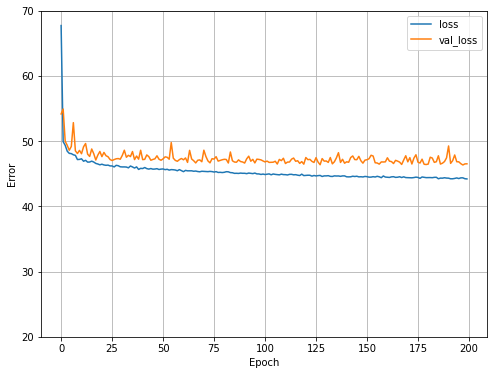

In [429]:
plot_loss(history)

In [430]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

122/122 - 0s - loss: 50.4802 - mae: 5.1934
Loss (MSE):  50.48015213012695
MAE:  5.193434715270996


Tras haber realizado múltiples pruebas con las distintas arquitecturas e hiperparámetros, se ha llegado
a un modelo *vencedor*.

El MSE es una medida difícil de interpretar, ya que no está en las mismas unidades
que el problema. Por otra parte, el MAE es más fácil de interpretar, ya que este sí está en las mismas unidades.
Sin embargo, **este valor no es representativo.**

Tal y como se pudo observar en las gráficas del comienzo del trabajo,
hay determinadas horas del día en las que el número de coches es más bajo o más alto. Por ejemplo, entre las 00:00
y las 06:00 el número de coches es muy bajo, entre 5 y 10 (GENERALMENTE), mientras que en la franja de 06:00 a 18:00 
varía entre 30 y 50.

Decir que hay un error medio de 5 coches cuando pasan 60 coches es viable, no así si ese error se
da cuando pasan tan solo 2.

Para poder visualizar y comprender mejor la calidad del modelo se hará una representación gráfica a partir de los
resultados obtenidos en las predicciones con el conjunto de test. La siguiente función muestra una gráfica para cada
día de la semana en la que aparecen los datos reales y los predichos por el modelo.

**NOTA:** Cada gráfica contiene los resultados de un determinado día de la semana (p.ej, Lunes), pero ese día de la semana
puede corresponder a semanas/meses diferentes. Esto se hace para ver una representación más general, ya que no tendría
sentido representar las predicciones de cada fecha exacta.

El parámetro `freq` regula la cantidad de puntos que aparecen en cada gráfica. Se cojen puntos espaciados `freq` unidades.
Con `freq=1` se representan todos los puntos; sin embargo, resulta complicado observar 500 puntos por gráfica.

In [41]:
def graph_predictions(test_dts, test_lbls, preds, freq):
    # Como el conjunto de test es la parte final del conjunto general DESPUES DEL SHUFFLE,
    # los indices empiezan en torno al 34 mil. Es mejor ponerlos a 0 para evitar problemas!
    test_dts.reset_index(inplace=True, drop=True)
    test_lbls.reset_index(inplace=True, drop=True)

    # Concateno las fechas, los labels y las predicciones en el mismo df
    cc_df = pd.concat([test_dts, test_lbls], axis=1)
    cc_df = pd.concat([cc_df, preds], axis=1)

    ############################ LÓGICA INTERESANTE ############################################
    # Necesito representar en el eje x las horas pero de días diferentes. Antes pasaba SOLO
    # la hora a String y usaba eso, pero daba problemas. Ahora recupero la hora de cada fecha
    # y se la sumo al día de hoy a las 00:00. De esta manera tengo todas las horas de todas las
    # fechas, pero en el día de hoy!!

    # Obtengo solo la hora de cada fecha
    hours = cc_df['datetime'].dt.strftime('%H:%M:%S')
    # Convierto las horas a timedelta y se las sumo al día de hoy a las 00:00
    cc_df['hour'] = (pd.to_timedelta(hours) + pd.to_datetime('today').normalize())
    ############################################################################################

    # Obtengo el dia de la semana [0-Lunes, 6-Domingo]
    cc_df['wday'] = cc_df['datetime'].dt.weekday
    # Ordeno por 'wday' y luego por 'hour' -> No es necesario
    cc_df.sort_values(by=['wday', 'hour'], ignore_index = True, inplace = True)

    # Settings
    fig, axs = plt.subplots(7)
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Labels vs. Predictions', fontsize=16)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Gráfica para cada día de la semana
    for i in range(7):
        # DataFrame para cada día de la semana
        aux = cc_df.loc[cc_df['wday'] == i]

        # Para una determinada hora puede haber varios label y predicciones (#label == #preds)
        axs[i].scatter(aux['hour'][::freq], aux['label_PM072'][::freq], label='Labels', s=12)
        axs[i].scatter(aux['hour'][::freq], aux['prediction'][::freq], label='Predictions', s=12)

        # Más settings
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 90, 10))
        axs[i].set(xlabel='Hours', ylabel='Car count')
        axs[i].set_title(day_names[i])

        axs[i].legend(loc='upper left')
        axs[i].grid()

    #plt.savefig('../img/labels_vs_preds.pdf', bbox_inches='tight', transparent=True, dpi=300)

    return cc_df

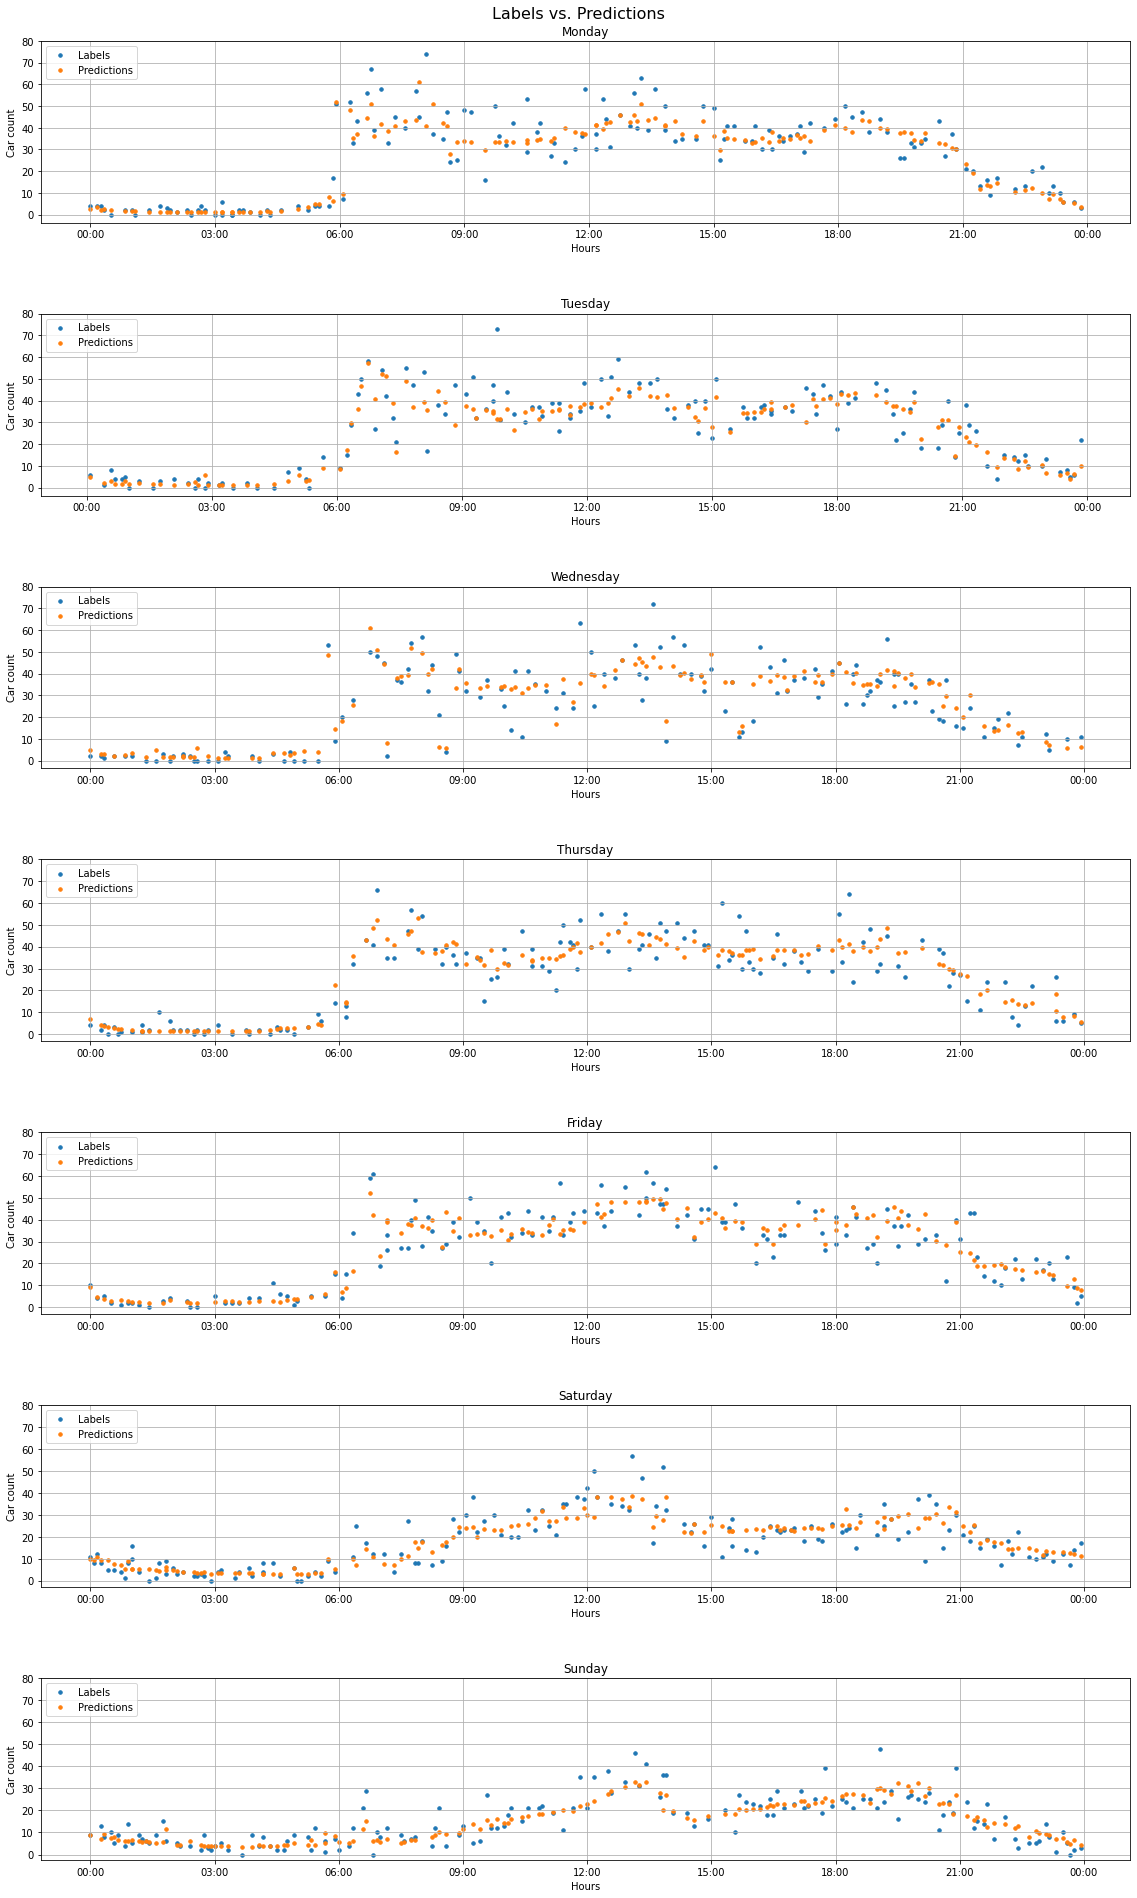

In [432]:
check_values = graph_predictions(test_dates, test_labels, predictions, freq = 4)

Para comprobar algunos valores que puedan parecer atípicos se utiliza la siguiente linea:

In [433]:
h_inicio = pd.to_timedelta('00:00:00') + pd.to_datetime('today').normalize()
h_fin = pd.to_timedelta('00:20:00') + pd.to_datetime('today').normalize()
check_values.loc[ (check_values['wday'] == 6) & (check_values['hour'] >= h_inicio) & (check_values['hour'] <= h_fin) ]

datetime  label_PM072  prediction                hour  wday
3281 2020-01-05 00:00:00            9    8.645214 2021-05-11 00:00:00     6
3282 2020-01-12 00:00:00            5    6.190559 2021-05-11 00:00:00     6
3283 2020-01-26 00:05:00            2    9.120806 2021-05-11 00:05:00     6
3284 2019-11-17 00:10:00           14    8.996197 2021-05-11 00:10:00     6
3285 2019-10-20 00:15:00           13    7.039518 2021-05-11 00:15:00     6
3286 2019-11-10 00:15:00            8    9.419979 2021-05-11 00:15:00     6
3287 2020-01-26 00:15:00           10    9.491070 2021-05-11 00:15:00     6
3288 2019-10-13 00:15:00            4    9.138289 2021-05-11 00:15:00     6
3289 2019-11-24 00:20:00            8    9.155014 2021-05-11 00:20:00     6
3290 2019-10-13 00:20:00            8    8.995066 2021-05-11 00:20:00     6

También resulta interesante ver una gráfica del error que se comete y la media de los errores relativos:

In [236]:
def graph_errors(test_dts, test_lbls, preds, freq):
    # Como el conjunto de test es la parte final del conjunto general DESPUES DEL SHUFFLE,
    # los indices empiezan en torno al 34 mil. Es mejor ponerlos a 0 para evitar problemas!
    test_dts.reset_index(inplace=True, drop=True)
    test_lbls.reset_index(inplace=True, drop=True)

    # Concateno las fechas, los labels y las predicciones en el mismo df
    cc_df = pd.concat([test_dts, test_lbls], axis=1)
    cc_df = pd.concat([cc_df, preds], axis=1)

    ############################ LÓGICA INTERESANTE ############################################
    # Obtengo solo la hora de cada fecha
    hours = cc_df['datetime'].dt.strftime('%H:%M:%S')
    # Convierto las horas a timedelta y se las sumo al día de hoy a las 00:00
    cc_df['hour'] = (pd.to_timedelta(hours) + pd.to_datetime('today').normalize())
    ############################################################################################

    # Obtengo el dia de la semana [0-Lunes, 6-Domingo]
    cc_df['wday'] = cc_df['datetime'].dt.weekday
    # Ordeno por 'wday' y luego por 'hour' -> No es necesario
    cc_df.sort_values(by=['wday', 'hour'], ignore_index = True, inplace = True)

    # Calculo el error absoluto en cada medición-predicción
    cc_df['abs_error'] = (cc_df['label_PM072']-cc_df['prediction']).abs()
    # Calculo el error relativo en cada medición-predicción
    cc_df['rel_error'] = (cc_df['abs_error']/cc_df['label_PM072']).round(2)
    # Categoría para el error (-inf, 0.10] (0.10, 0.20] (0.20, 0.30] (0.30, +inf)
    cc_df['category'] = pd.cut(cc_df['rel_error'], [-np.inf, 0.10, 0.20, 0.30, np.inf], labels=['≤ 10%', '(10%, 20%]', '(20%, 30%]', '> 30%'])

    # Settings
    fig, axs = plt.subplots(7)
    fig.set_figheight(27.5)
    fig.set_figwidth(17.5)
    fig.tight_layout(pad=7.0)
    fig.suptitle('Absolute Error on Each Prediction', fontsize=16)
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    colors = {'≤ 10%':'green', '(10%, 20%]':'blue', '(20%, 30%]':'orange', '> 30%':'red'}

    # Gráfica para cada día de la semana
    for i in range(7):
        # DataFrame para cada día de la semana
        aux = cc_df.loc[cc_df['wday'] == i]

        # Asigna el color según ka categoría
        axs[i].scatter(aux['hour'][::freq], aux['abs_error'][::freq], c=aux['category'][::freq].map(colors), s=15)

        # Más settings
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i].yaxis.set_ticks(np.arange(0, 35, 5))
        axs[i].set(xlabel='Hours', ylabel='Absolute Error')
        axs[i].set_title(day_names[i])

        # Leyenda personalizada
        legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in colors.items()]
        axs[i].legend(handles=legend_labels, loc='upper left', title = "Relative Error")
        axs[i].grid()

    #plt.savefig('../img/errors.pdf', bbox_inches='tight', transparent=True, dpi=300)


    ########################### DATOS 6:00 a 21:00 ###############################
    h_inicio = pd.to_timedelta('06:00:00') + pd.to_datetime('today').normalize()
    h_fin = pd.to_timedelta('21:00:00') + pd.to_datetime('today').normalize()
    day_df = cc_df.loc[(cc_df['hour'] >= h_inicio) & (cc_df['hour'] <= h_fin)]

    # Fuera los inf
    day_df = day_df.copy(deep = True)
    day_df.replace(to_replace = [np.inf, -np.inf], value = np.nan, inplace = True)
    day_df.dropna(inplace = True)

    # Por si elimino los errores > 100%
    #day_df = day_df[rel_err < 1.0]

    ########################### GRÁFICA ACCUM VS. ABS_ERROR ######################
    fig, ax = plt.subplots()

    x = np.arange(0, 36, 1) # 0..35
    accum_perc = []
    for i in x:
        perc = (len(day_df.loc[ day_df['abs_error'] <= i ])/len(day_df)) * 100
        accum_perc.append(perc)

    ax.plot(x, accum_perc, linestyle='-', c='red')
    pts = np.arange(5, 15, 5)
    for i in pts:
        ax.plot(i, accum_perc[i], c = 'black', marker='o', markersize=5, label='Abs Error ≤ ' + str(i))
        ax.text(i+0.5, accum_perc[i], s = str(round(accum_perc[i], 2)), fontsize=10)

    ax.yaxis.set_ticks(np.arange(0, 120, 20))
    ax.set(xlabel='Absolute Error', ylabel='Accumulated Percentage')

    arch = {'MLP':'green', 'MLP_MTS':'blue', 'CNN':'orange', 'LSTM':'red'}
    legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in arch.items()]
    ax.legend(handles=legend_labels, loc='upper left', title="Architecture")
    ax.set_title('Accumulated % vs. Absolute Error (6:00 - 21:00)', fontsize=14)
    ax.grid()

    plt.savefig('../img/curva_LSTM_E4.png', bbox_inches='tight', transparent=True, dpi=300)
    pickle.dump(ax, open("../graphs/E4/LSTM_E4.pickle", "wb"))

    ##############################################################################

    ########################### PIE CHART REL_ERROR ##############################
    print("\nCalculations using data from 6:00 to 21:00")
    print("--------------------------------------------")
    print("Mean of Relative Errors: ", day_df['rel_error'].mean())
    print("STD of Relative Errors: ", day_df['rel_error'].std())

    print("--------------------------------------------")
    print("Predictions belonging to each category:")
    values, my_names = [], []
    grouped = day_df.groupby('category')
    for name, group in grouped:
        v = round((len(group)/len(day_df))*100, 2)
        values.append(v)
        my_names.append(name)
        print("  " + name + ": " + str(len(group)) + " / " + str(len(day_df)) + " (" + str(v) + "%)" )
    print("--------------------------------------------\n")

    fig, ax = plt.subplots()
    myexplode = [0.0, 0, 0, 0.15]
    ax.pie(values, explode=myexplode ,colors=colors.values(), autopct='%1.1f%%',
           textprops={'fontsize': 14, 'color': 'white', 'weight':'bold'}, shadow=True)
    ax.axis('equal')
    ax.set_title('Relative Error by Categories (6:00 - 21:00)', fontsize=14)
    legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in colors.items()]
    ax.legend(handles=legend_labels, loc='upper left', title="Relative Error")

    plt.savefig('../img/pie_LSTM_E4.png', bbox_inches='tight', transparent=True, dpi=300)

    ##############################################################################

    return cc_df


Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.2502340597255851
STD of Relative Errors:  0.39244369866139883
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 831 / 2478 (33.54%)
  (10%, 20%]: 625 / 2478 (25.22%)
  (20%, 30%]: 405 / 2478 (16.34%)
  > 30%: 617 / 2478 (24.9%)
--------------------------------------------



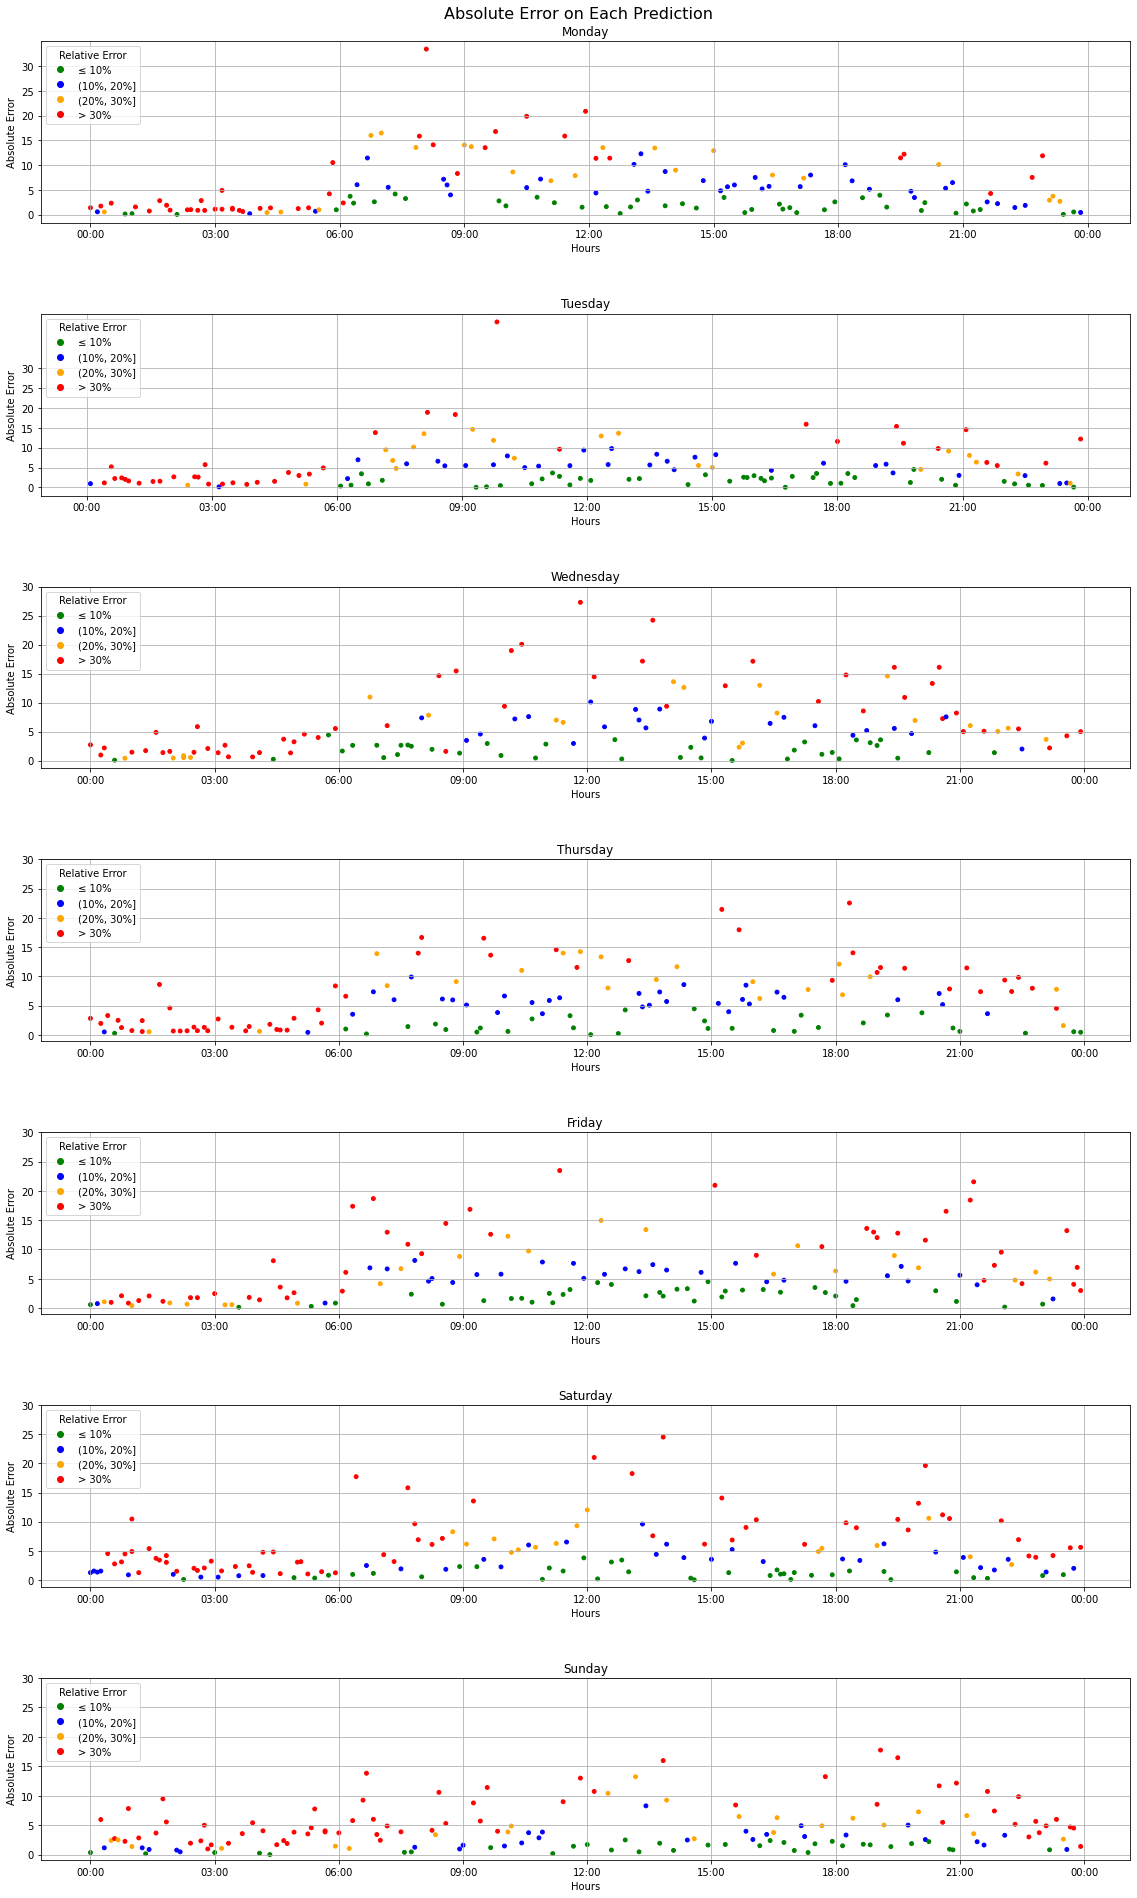

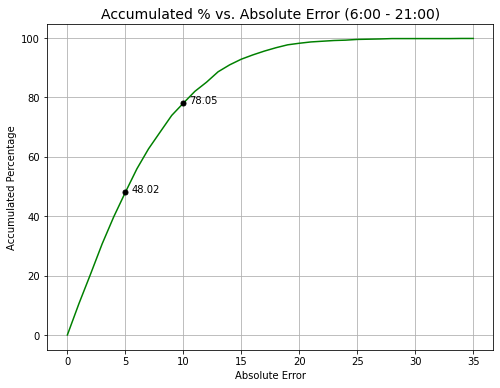

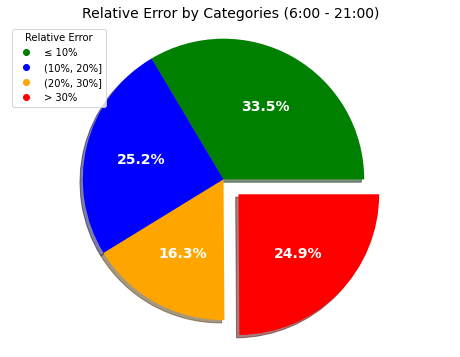

In [438]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

In [436]:
h_inicio = pd.to_timedelta('06:00:00') + pd.to_datetime('today').normalize()
h_fin = pd.to_timedelta('21:00:00') + pd.to_datetime('today').normalize()
#errors.loc[ (errors['wday'] == 3) & (errors['hour'] >= h_inicio) & (errors['hour'] <= h_fin)]

**NOTA:** Se puede observar que el mayor error relativo se comete por la noche, cuando menos error absoluto hay.

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #1`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente del sensor `PM029` en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #1` tiene la siguiente forma:

In [43]:
df_1

datetime  car_count_PM029  label_PM072  hour_sin  hour_cos  \
0     2019-10-01 00:00:00                1            0  0.000000  1.000000   
1     2019-10-01 00:05:00                0            0  0.021815  0.999762   
2     2019-10-01 00:10:00                0            0  0.043619  0.999048   
3     2019-10-01 00:15:00                0            0  0.065403  0.997859   
4     2019-10-01 00:20:00                0            1  0.087156  0.996195   
...                   ...              ...          ...       ...       ...   
38784 2020-02-29 23:30:00                4            8 -0.130526  0.991445   
38785 2020-02-29 23:35:00                0            7 -0.108867  0.994056   
38786 2020-02-29 23:40:00                3           11 -0.087156  0.996195   
38787 2020-02-29 23:45:00                3           22 -0.065403  0.997859   
38788 2020-02-29 23:50:00                7           20 -0.043619  0.999048   

       wday_sin  wday_cos  
0      0.781831  0.623490  
1      0.781831  0.623490  
2      0.781831  0.623490  
3      0.781831  0.623490  
4      0.781831  0.623490  
...         ...       ...  
38784 -0.974928 -0.222521  
38785 -0.974928 -0.222521  
38786 -0.974928 -0.222521  
38787 -0.974928 -0.222521  
38788 -0.974928 -0.222521  

[38789 rows x 7 columns]

Cada fila contiene la información temporal relevante, el valor medido por el sensor `PM029` en `t-5` y
el valor medido por `PM072` en `t`.

Ahora es necesario que cada vector de características contenga la medición realizada
por `PM029` en:
* `t-5`
* `t-10`
* `t-15`

*Además de la información horaria para cada uno de esos timesteps*

Para lograr este nuevo vector de características, en primer lugar se debe ordenar el dataset
del `Experimento #1` por el campo `datetime` (Ya debería estar, puesto que se ordenó todo el
dataset al principio y el loc de la función `prepare_df` los coge por orden y el merge resetea los index
Además, el shuffle **NO** se ha hecho *inplace*)

In [44]:
df_1.sort_values(by='datetime', ignore_index=True, inplace=True)

Como ya se ha visto durante el `Análisis de dataset`, el dataset **NO** contiene TODAS las mediciones realizadas
durante los meses de Octubre a Febrero, por lo que no es posible coger las filas de 3 en 3.

*(En caso de hacer esto, podría darse que un vector de características tenga información de mediciones
realizadas 1 hora antes, 20 minutos antes y 5 minutos antes -> **NO SE PUEDE PERMITIR**)*

Es necesario que el dataset SOLO contenga aquellas **mediciones para las que hay mediciones en los dos
instantes temporales siguientes**.

En primer lugar se realiza una copia de `df_1` y se extraen los labels y los timesteps

In [45]:
df_1_multi_timestep = df_1.copy(deep = True)
dates = df_1_multi_timestep.pop('datetime')
labels = df_1_multi_timestep.pop('label_PM072')

In [46]:
df_1_multi_timestep.tail(n=6)

car_count_PM029  hour_sin  hour_cos  wday_sin  wday_cos
38783                4 -0.152123  0.988362 -0.974928 -0.222521
38784                4 -0.130526  0.991445 -0.974928 -0.222521
38785                0 -0.108867  0.994056 -0.974928 -0.222521
38786                3 -0.087156  0.996195 -0.974928 -0.222521
38787                3 -0.065403  0.997859 -0.974928 -0.222521
38788                7 -0.043619  0.999048 -0.974928 -0.222521

Ahora es necesario conocer para que timesteps existen los dos timesteps siguientes. Es decir, una medición 5 minutos
después y 10 minutos después.

In [47]:
correct_dates_index  = []
for i in range(len(dates)-2):
    if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
        correct_dates_index.append(i)

Una vez obtenida la lista de los timesteps para los que sí hay dos mediciones consecutivas, se debe crear el vector de
características anteriormente comentado.

In [48]:
aux_list, new_features, new_dates, new_labels = [], [], [], []
for i in correct_dates_index:
    v = df_1_multi_timestep.iloc[i:i+3].to_numpy() # Recupera 3 dilas
    new_features.append(np.append(aux_list, v)) # Une las tres filas en un array y lo añade a una lista
    new_dates.append(dates[i+2])
    new_labels.append(labels[i+2])

Finalmente, para facilitar la visualización de los datos y las operaciones posteriores que se realizarán sobre los mismos,
se ha creado un DataFrame. En este DataFrame se puede observar la fecha de la última medición de las 3 que hay en el vector
de características y la medición realizada por `PM072 5 minutos depués`

In [49]:
df_1_multi_timestep = pd.DataFrame(new_features)
df_1_multi_timestep.insert(loc=0, column='datetime', value = new_dates)
df_1_multi_timestep.insert(loc=len(df_1_multi_timestep.columns), column='label_PM072', value = new_labels)

df_1_multi_timestep

datetime    0         1         2         3         4    5  \
0     2019-10-01 00:10:00  1.0  0.000000  1.000000  0.781831  0.623490  0.0   
1     2019-10-01 00:15:00  0.0  0.021815  0.999762  0.781831  0.623490  0.0   
2     2019-10-01 00:20:00  0.0  0.043619  0.999048  0.781831  0.623490  0.0   
3     2019-10-01 00:25:00  0.0  0.065403  0.997859  0.781831  0.623490  0.0   
4     2019-10-01 00:30:00  0.0  0.087156  0.996195  0.781831  0.623490  1.0   
...                   ...  ...       ...       ...       ...       ...  ...   
38720 2020-02-29 23:30:00  5.0 -0.173648  0.984808 -0.974928 -0.222521  4.0   
38721 2020-02-29 23:35:00  4.0 -0.152123  0.988362 -0.974928 -0.222521  4.0   
38722 2020-02-29 23:40:00  4.0 -0.130526  0.991445 -0.974928 -0.222521  0.0   
38723 2020-02-29 23:45:00  0.0 -0.108867  0.994056 -0.974928 -0.222521  3.0   
38724 2020-02-29 23:50:00  3.0 -0.087156  0.996195 -0.974928 -0.222521  3.0   

              6         7         8         9   10        11        12  \
0      0.021815  0.999762  0.781831  0.623490  0.0  0.043619  0.999048   
1      0.043619  0.999048  0.781831  0.623490  0.0  0.065403  0.997859   
2      0.065403  0.997859  0.781831  0.623490  0.0  0.087156  0.996195   
3      0.087156  0.996195  0.781831  0.623490  1.0  0.108867  0.994056   
4      0.108867  0.994056  0.781831  0.623490  0.0  0.130526  0.991445   
...         ...       ...       ...       ...  ...       ...       ...   
38720 -0.152123  0.988362 -0.974928 -0.222521  4.0 -0.130526  0.991445   
38721 -0.130526  0.991445 -0.974928 -0.222521  0.0 -0.108867  0.994056   
38722 -0.108867  0.994056 -0.974928 -0.222521  3.0 -0.087156  0.996195   
38723 -0.087156  0.996195 -0.974928 -0.222521  3.0 -0.065403  0.997859   
38724 -0.065403  0.997859 -0.974928 -0.222521  7.0 -0.043619  0.999048   

             13        14  label_PM072  
0      0.781831  0.623490            0  
1      0.781831  0.623490            0  
2      0.781831  0.623490            1  
3      0.781831  0.623490            0  
4      0.781831  0.623490            2  
...         ...       ...          ...  
38720 -0.974928 -0.222521            8  
38721 -0.974928 -0.222521            7  
38722 -0.974928 -0.222521           11  
38723 -0.974928 -0.222521           22  
38724 -0.974928 -0.222521           20  

[38725 rows x 17 columns]

Para condensar el proceso anterior se ha creado la siguiente función. Esta función recibe el DataFrame utilizado en la
`Implementación Perceptrón Multicapa (MLP) Simple` y devuelve el DataFrame necesario para `Implementación MLP con Múltiples Timesteps`.

In [50]:
def prepare_multi_timestep_df(df_MLP):

    df_MLP.sort_values(by='datetime', ignore_index=True, inplace=True)

    df_multi_timestep = df_MLP.copy(deep = True)
    dates = df_multi_timestep.pop('datetime')
    labels = df_multi_timestep.pop('label_PM072')

    correct_dates_index  = []
    for i in range(len(dates)-2):
        if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
            correct_dates_index.append(i)

    aux_list, new_features, new_dates, new_labels = [], [], [], []
    for i in correct_dates_index:
        v = df_multi_timestep.iloc[i:i+3].to_numpy() # Recupera 3 filas
        new_features.append(np.append(aux_list, v)) # Une las tres filas en un array y lo añade a una lista
        new_dates.append(dates[i+2])
        new_labels.append(labels[i+2])

    df_multi_timestep = pd.DataFrame(new_features)
    df_multi_timestep.insert(loc=0, column='datetime', value = new_dates)
    df_multi_timestep.insert(loc=len(df_multi_timestep.columns), column='label_PM072', value = new_labels)

    return df_multi_timestep

#### División, Separación y Normalización

In [51]:
# Shuffle
df_1_mts_shuffled=df_1_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_1_mts_shuffled)
train_df_1_mts = df_1_mts_shuffled[0:int(n*0.90)]
test_df_1_mts = df_1_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1_mts.pop('datetime')
test_dates = test_df_1_mts.pop('datetime')

In [52]:
train_labels = train_df_1_mts.pop('label_PM072')
train_features = train_df_1_mts

test_labels = test_df_1_mts.pop('label_PM072')
test_features = test_df_1_mts

In [53]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [54]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [55]:
model = build_and_compile_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


In [56]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 4min 56s, sys: 37.3 s, total: 5min 34s
Wall time: 4min 26s


In [57]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  42.124775  4.791934  44.320080  4.874952    195
196  42.045315  4.782218  44.519585  4.900243    196
197  42.106079  4.785856  44.506828  4.881939    197
198  42.091316  4.786535  44.485451  4.879746    198
199  42.048214  4.785389  44.365643  4.898938    199

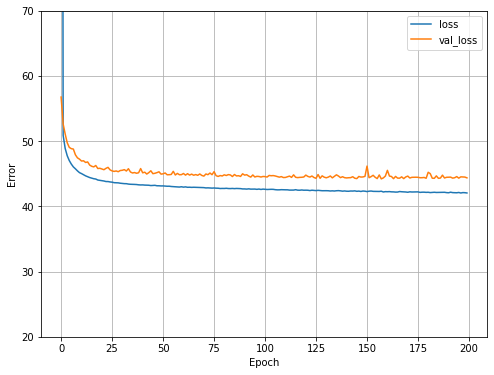

In [58]:
plot_loss(history)

In [59]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

122/122 - 0s - loss: 45.7577 - mae: 5.0195
Loss (MSE):  45.7576904296875
MAE:  5.019542217254639


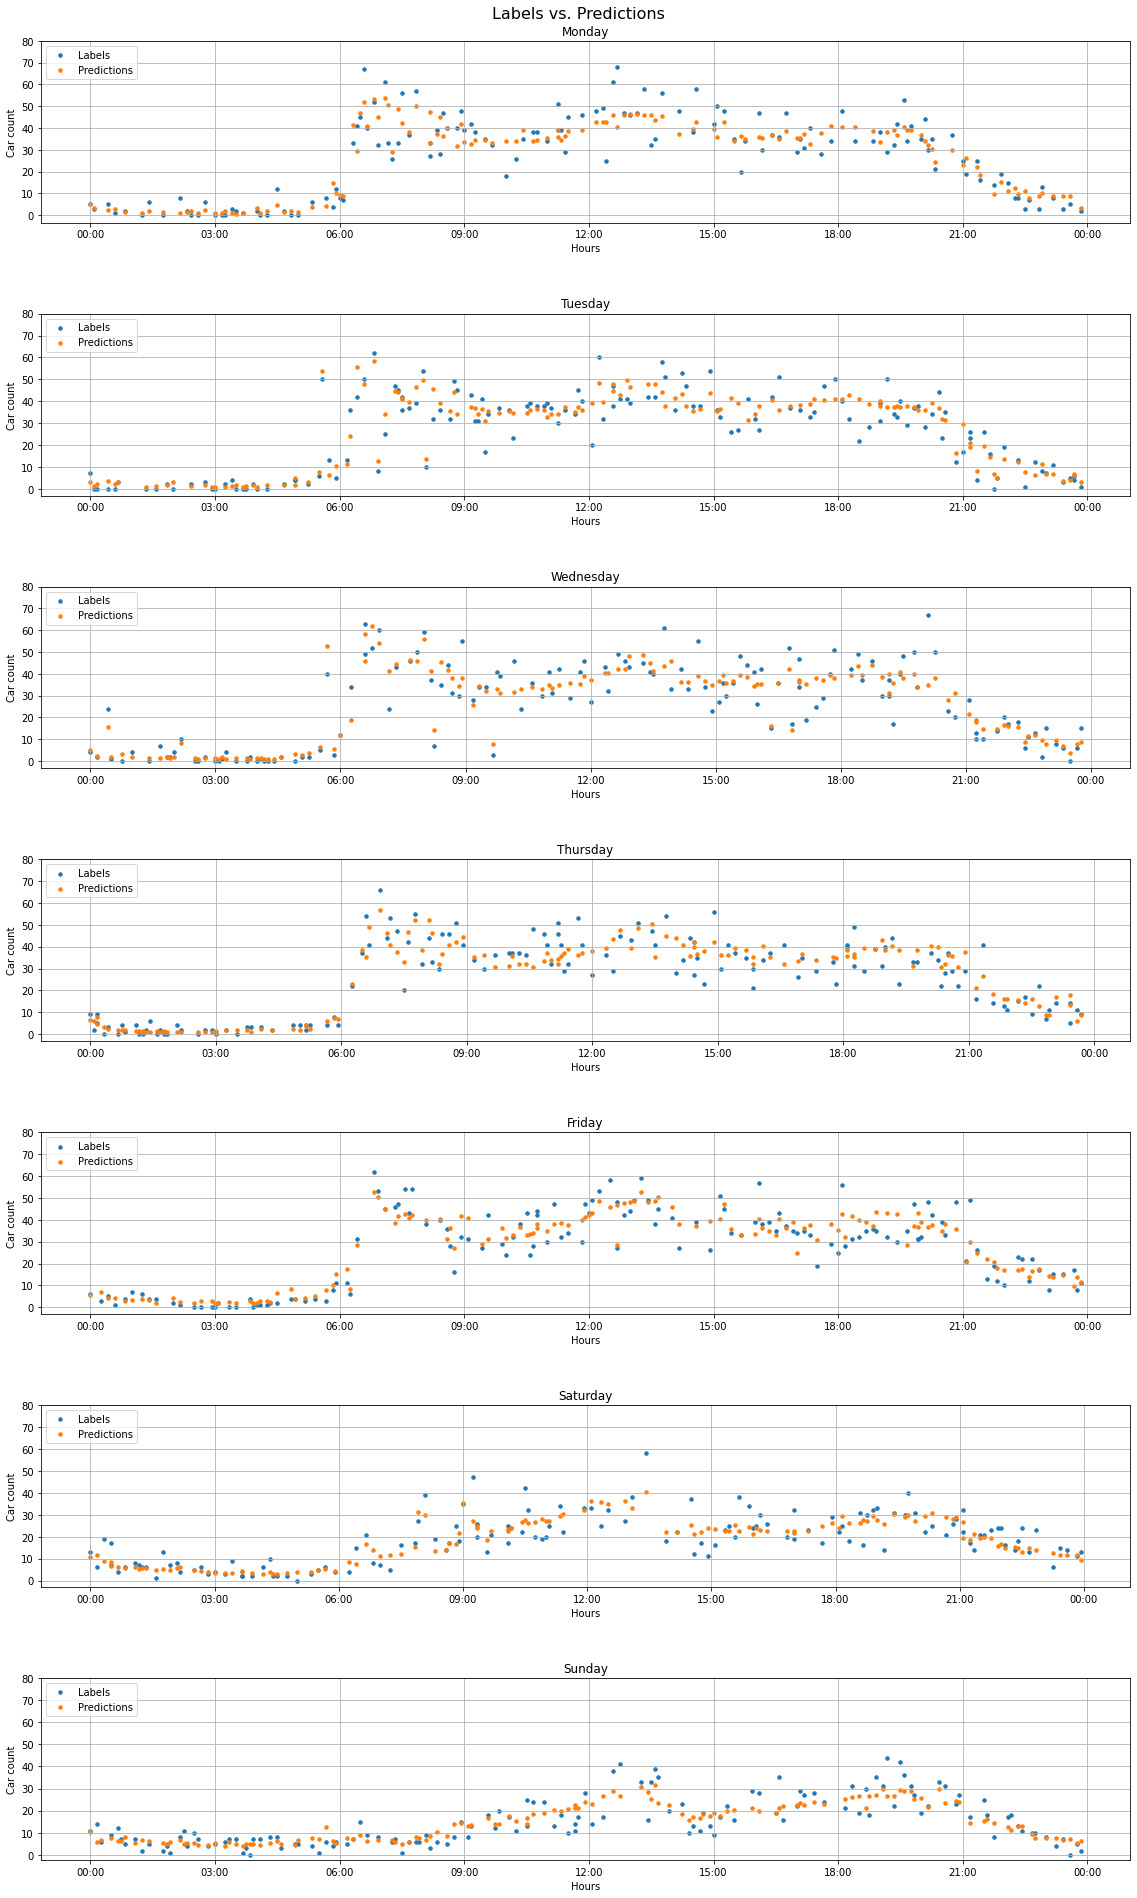

In [354]:
check_values = graph_predictions(test_dates, test_labels, predictions, freq = 4)

In [355]:
FDA = check_values.loc[ (check_values['wday'] == 2) & (check_values['hour'] > '00:00') & ((check_values['hour'] < '02:10')) & (check_values['label_PM072'] > 20)]
FDA # Los valores outlayers a esta hora son el día 2020-01-01

datetime  label_PM072  prediction                hour  wday
1113 2020-01-01 00:05:00           22   26.203545 2021-05-11 00:05:00     2
1119 2019-12-25 00:25:00           24   15.611321 2021-05-11 00:25:00     2
1132 2020-01-01 01:15:00           34   33.754139 2021-05-11 01:15:00     2

In [356]:
check_values.loc[ (check_values['wday'] == 2) & (check_values['hour'] > '00:00') & ((check_values['hour'] < '02:10'))]

datetime  label_PM072  prediction                hour  wday
1112 2020-01-29 00:05:00            3    3.537475 2021-05-11 00:05:00     2
1113 2020-01-01 00:05:00           22   26.203545 2021-05-11 00:05:00     2
1114 2020-02-12 00:05:00            2    4.981864 2021-05-11 00:05:00     2
1115 2019-10-09 00:10:00            2    2.279223 2021-05-11 00:10:00     2
1116 2020-02-26 00:10:00            9    4.141292 2021-05-11 00:10:00     2
1117 2020-02-05 00:20:00            2    2.458368 2021-05-11 00:20:00     2
1118 2020-02-19 00:20:00            1    6.503040 2021-05-11 00:20:00     2
1119 2019-12-25 00:25:00           24   15.611321 2021-05-11 00:25:00     2
1120 2020-02-26 00:25:00            6    4.427042 2021-05-11 00:25:00     2
1121 2020-02-19 00:25:00            1    3.688632 2021-05-11 00:25:00     2
1122 2019-12-04 00:25:00            0    1.795269 2021-05-11 00:25:00     2
1123 2020-02-12 00:30:00            1    1.842885 2021-05-11 00:30:00     2
1124 2019-10-30 00:30:00            1    3.694939 2021-05-11 00:30:00     2
1125 2019-10-30 00:45:00            0    1.434860 2021-05-11 00:45:00     2
1126 2019-10-09 00:45:00            0    1.782506 2021-05-11 00:45:00     2
1127 2019-11-27 00:45:00            0    3.042110 2021-05-11 00:45:00     2
1128 2020-01-22 00:50:00            2    1.631451 2021-05-11 00:50:00     2
1129 2019-10-09 00:50:00            0    1.631451 2021-05-11 00:50:00     2
1130 2020-01-15 00:50:00            0    1.420473 2021-05-11 00:50:00     2
1131 2020-02-05 01:00:00            4    1.920278 2021-05-11 01:00:00     2
1132 2020-01-01 01:15:00           34   33.754139 2021-05-11 01:15:00     2
1133 2019-11-13 01:20:00            2    1.813154 2021-05-11 01:20:00     2
1134 2019-10-23 01:25:00            1    1.627324 2021-05-11 01:25:00     2
1135 2019-12-11 01:25:00            0    1.278524 2021-05-11 01:25:00     2
1136 2019-12-04 01:25:00            5    1.817547 2021-05-11 01:25:00     2
1137 2020-01-15 01:35:00            2    1.378615 2021-05-11 01:35:00     2
1138 2019-10-09 01:35:00            0    1.237556 2021-05-11 01:35:00     2
1139 2019-12-11 01:40:00            7    1.207047 2021-05-11 01:40:00     2
1140 2020-02-05 01:45:00            3    1.961099 2021-05-11 01:45:00     2
1141 2020-01-29 01:45:00            2    1.522676 2021-05-11 01:45:00     2
1142 2020-02-19 01:50:00            2    1.904172 2021-05-11 01:50:00     2
1143 2019-12-11 01:50:00            2    1.951057 2021-05-11 01:50:00     2
1144 2019-11-27 01:50:00            0    1.904172 2021-05-11 01:50:00     2
1145 2019-10-02 01:50:00            0    1.685344 2021-05-11 01:50:00     2
1146 2019-10-30 01:55:00            6    2.414046 2021-05-11 01:55:00     2
1147 2020-02-19 01:55:00            2    1.477883 2021-05-11 01:55:00     2
1148 2019-10-09 01:55:00            0    1.666516 2021-05-11 01:55:00     2
1149 2019-12-25 02:00:00           10    1.557727 2021-05-11 02:00:00     2
1150 2019-11-20 02:00:00            2    1.664859 2021-05-11 02:00:00     2
1151 2020-02-26 02:00:00            4    1.644252 2021-05-11 02:00:00     2
1152 2020-02-12 02:05:00            0    1.633341 2021-05-11 02:05:00     2


Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.24764201062525543
STD of Relative Errors:  0.38807199726578995
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 794 / 2447 (32.45%)
  (10%, 20%]: 707 / 2447 (28.89%)
  (20%, 30%]: 423 / 2447 (17.29%)
  > 30%: 523 / 2447 (21.37%)
--------------------------------------------



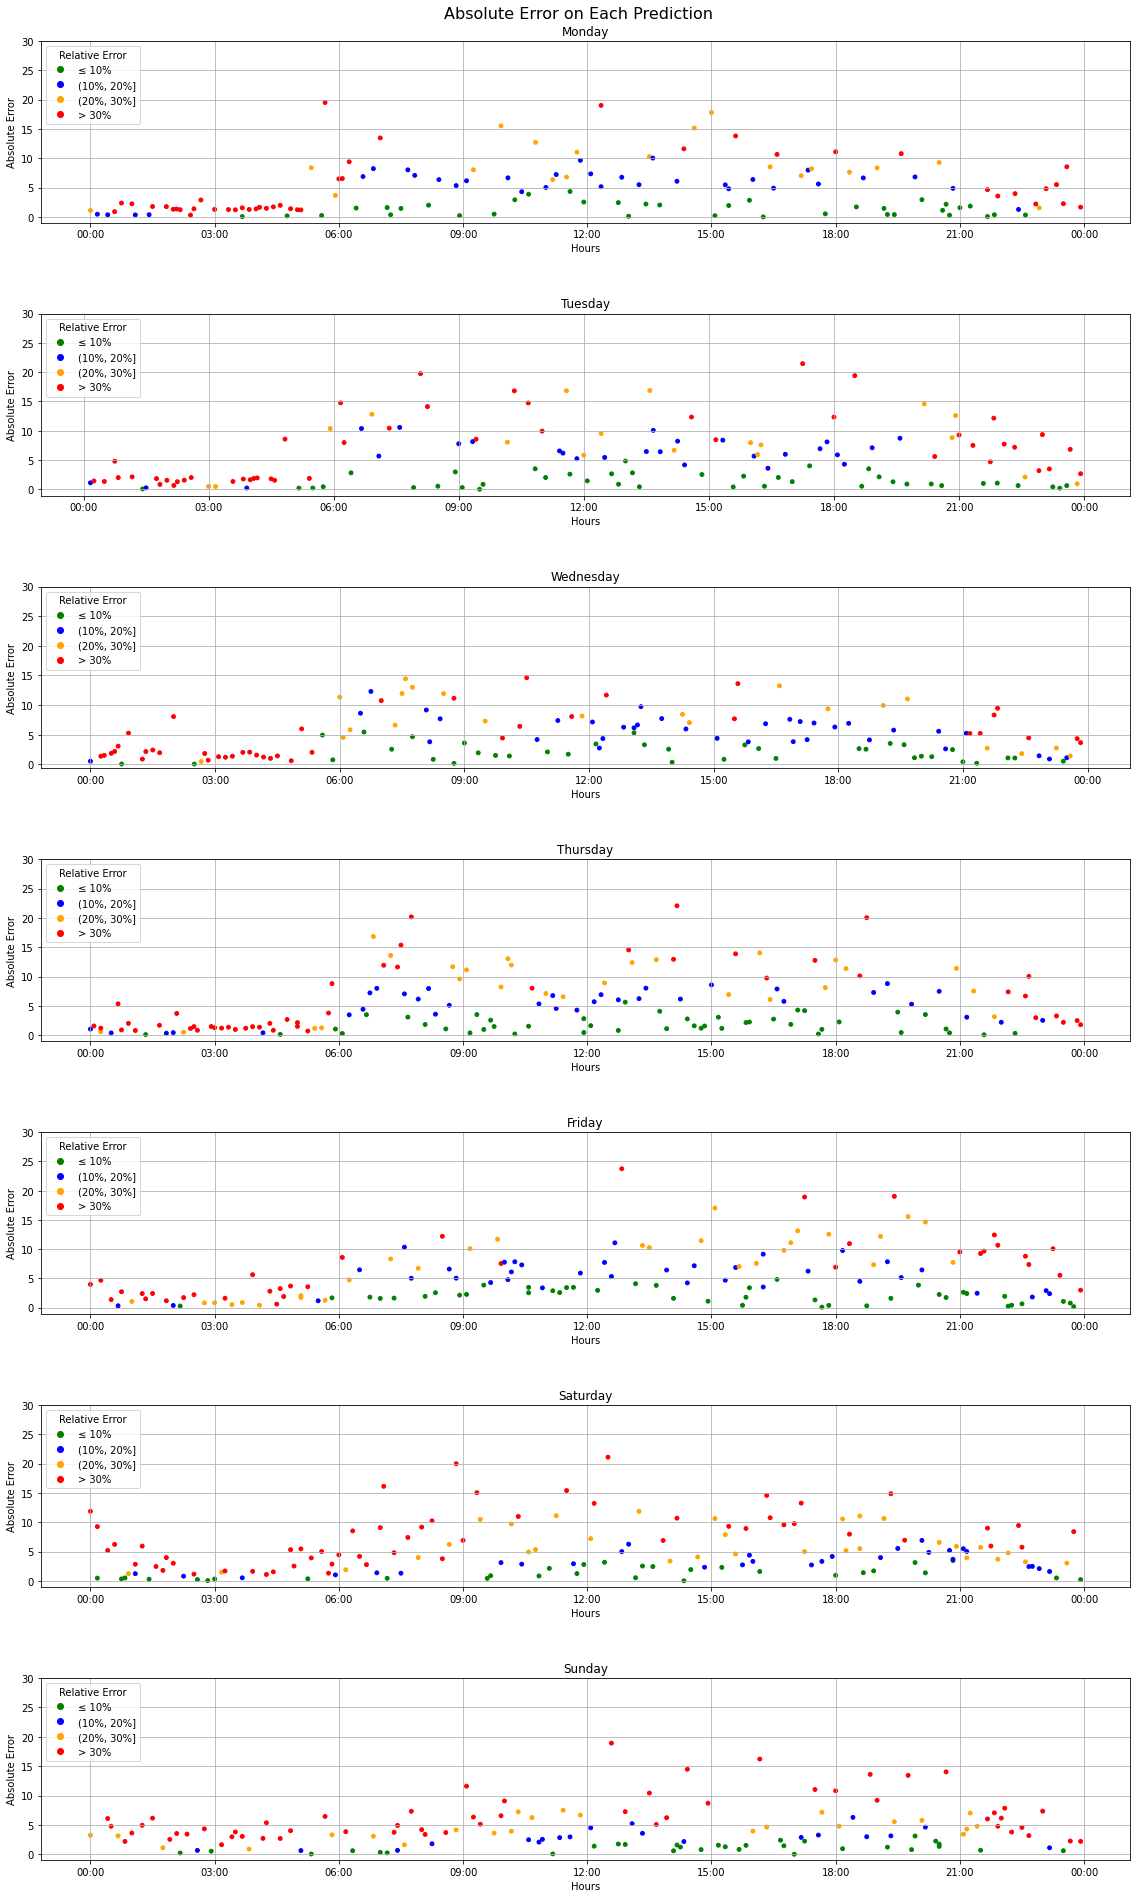

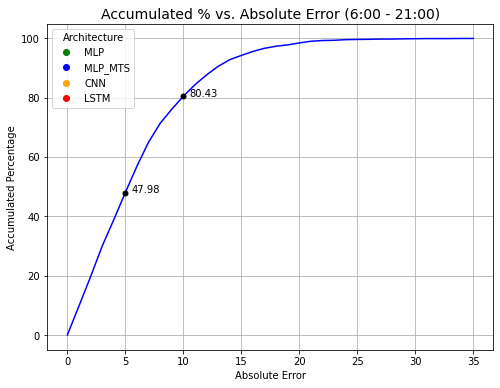

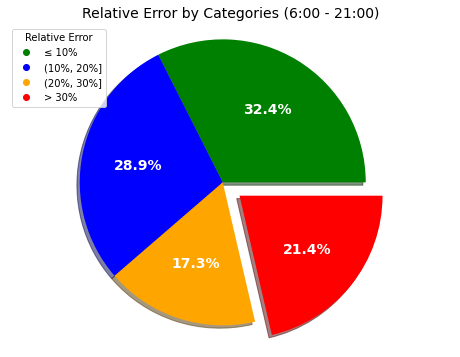

In [60]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación RNN

#### Definición RNN

Está en el fichero Arquitecturas.txt y en la Memoria

#### Implementación LSTM

En esta sección se tratará la implementación del modelo con LSTM.

Ahora mismo el dataset para el `Experimento #1` tiene las siguientes características:

In [359]:
df_1_rnn = df_1.copy(deep = True)
df_1.sample()

datetime  car_count_PM029  label_PM072  hour_sin  hour_cos  \
9920 2019-11-12 16:00:00                8           31 -0.866025      -0.5   

      wday_sin  wday_cos  
9920  0.781831   0.62349

Tal y como se ha comentado en `Definición RNN`, este tipo de arquitectura es capaz
de modelar el tiempo de forma explícita, por lo que ya *no es necesario* que se introduzca
la información temporal:

In [360]:
to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
df_1_rnn.drop(to_drop, axis=1, inplace=True)

Por otra parte, para que la red pueda modelar el tiempo de manera correcta, es necesario
que los datos que reciba estén ordenados temporalmente; es decir, por el campo `datetime`:

In [361]:
df_1_rnn.sort_values(by=['datetime'], ignore_index = True , inplace = True)
df_1_rnn

datetime  car_count_PM029  label_PM072
0     2019-10-01 00:00:00                1            0
1     2019-10-01 00:05:00                0            0
2     2019-10-01 00:10:00                0            0
3     2019-10-01 00:15:00                0            0
4     2019-10-01 00:20:00                0            1
...                   ...              ...          ...
38784 2020-02-29 23:30:00                4            8
38785 2020-02-29 23:35:00                0            7
38786 2020-02-29 23:40:00                3           11
38787 2020-02-29 23:45:00                3           22
38788 2020-02-29 23:50:00                7           20

[38789 rows x 3 columns]

El modelo LSTM aprenderá una función que sea capaz de asociar una serie de secuencias pasadas (inputs) a una
salida (output). Estas observaciones deben ser transformadas de tal manera que el modelo pueda aprender de ellas.

Para poder hacer esto el modelo necesita suficiente contexto; es decir, cada ejemplo que reciba debe contener
las mediciones realizadas en varios instantes temporales, pero siempre manteniendo el orden en el que estas
han sido tomadas. En TensorFlow, una capa de tipo LSTM requiere una entrada con 3D la siguiente forma **[samples, timesteps, features]:**
* *samples*: Número de ejemplos
* *timesteps*: El número de instantes temporales que contiene cada ejemplo
* *features*: El número de características del dataset

**EN LA MEMORIA PONER UN DIBUJO DE COMO ES LA ENTRADA 3D**

Se ha considerado que el **número de timesteps a usar será 3**. Es decir, cada ejemplo cuenta con la información tomada por
los sensores a utilizar en cada Experimento en el instante `t-5, t-10 y t-15`. A partir de esta información, el modelo
tratará de predecir el número de coches que pasarán por el sensor `PM072` en el instante `t`.

Antes de crear esta entrada 3D es necesario normalizar y dividir el conjunto

#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [362]:
n = len(df_1_rnn)
train_df_1_rnn = df_1_rnn[0:int(n*0.90)]
test_df_1_rnn = df_1_rnn[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_1_rnn.pop('datetime')
test_dates = test_df_1_rnn.pop('datetime')

In [363]:
train_labels = train_df_1_rnn.pop('label_PM072')
train_features = train_df_1_rnn

test_labels = test_df_1_rnn.pop('label_PM072')
test_features = test_df_1_rnn

In [364]:
# Esto es NORMALIZACION

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(train_features)

# Apply the scaler to training data
train_features = input_scaler.transform(train_features)

# Apply the scaler to test data
test_features = input_scaler.transform(test_features)

##### Entrada celda LSTM

Ahora que se ha realizado todo el proceso anterior, ya es posible crear la entrada 3D. Pero antes, se debe tener en cuenta que,
al igual que se ha visto en la sección `Implementación MLP con Múltiples Timesteps`, el dataset no presenta TODAS las mediciones.

El modelo debe recibir la información de los instantes `t-5, t-10 y t-15`. Para ello, es necesario seleccionar solo
aquellas filas para las que hay dos mediciones en los dos instantes temporales posteriores. **Esas mediciones en esos
3 instantes será la entrada 3D del modelo.**

Asimismo, se deben almacenar solo los labels y fechas correspondientes a la medición en el instante `t-5`

Para ello se ha creado la siguiente función, la cual recibe como parámetros todas las `features` y sus `labels`
correspondientes. Devuelve la entrada LSTM en 3D, el`label` y `datetime` correspondiente a cada ejemplo de `3 timesteps`:

In [247]:
def create_LSTM_data(input, output, dates):

    # Necesario el reset para acceder por index
    input.reset_index(inplace=True, drop=True)
    output.reset_index(inplace=True, drop=True)
    dates.reset_index(inplace=True, drop=True)

    # Mediciones para las que hay dos mediciones posteriores
    correct_dates_index  = []
    for i in range(len(dates)-2):
        if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
            correct_dates_index.append(i)

    Xs, ys, dts = [], [], []
    for i in correct_dates_index:
        v = input.iloc[i:i+3].to_numpy() # Recupera 3 filas
        Xs.append(v)
        ys.append(output[i+2])
        dts.append(dates[i+2])

    return np.array(Xs), np.array(ys), np.array(dts)

In [366]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features

0
0      0.018182
1      0.000000
2      0.000000
3      0.000000
4      0.000000
...         ...
34905  0.327273
34906  0.163636
34907  0.236364
34908  0.200000
34909  0.163636

[34910 rows x 1 columns]

In [367]:
train_inputs, train_outputs, train_dates = create_LSTM_data(train_features, train_labels, train_dates)
test_inputs, test_outputs, test_dates = create_LSTM_data(test_features, test_labels, test_dates)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

train_inputs.shape:  (34846, 3, 1)
train_outputs.shape:  (34846,)
test_inputs.shape:  (3877, 3, 1)
test_outputs.shape:  (3877,)


In [368]:
train_inputs

array([[[0.01818182],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.32727273],
        [0.16363636],
        [0.23636364]],

       [[0.16363636],
        [0.23636364],
        [0.2       ]],

       [[0.23636364],
        [0.2       ],
        [0.16363636]]])

In [369]:
train_outputs

array([ 0,  0,  1, ..., 24, 20, 27])

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el último instante temporal. **En realidad, el valor
de la medición del sensor `PM072` de cada fila corresponde a la medición realiza 5 minutos después de las
mediciones de los otros sensores de la fila!!. Esto ya se ha explicado al principio**

Ahora que ya se ha obtenido una entrada y salida adecuadas, ya es posible comenzar con el entrenamiento.

#### Entrenamiento

In [370]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.LSTM(64,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=True,
                   input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.LSTM(64,kernel_regularizer=regularizers.l2(0.0001),
                  return_sequences=True,
                   activation='relu'),
      layers.LSTM(32,kernel_regularizer=regularizers.l2(0.0001),
                  return_sequences=False,
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['mae']
  )

  return model

In [371]:
model = build_and_compile_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 64)             33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 62,369
Trainable params: 62,369
Non-trainable params: 0
_________________________________________________________________


In [372]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    shuffle = False,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 30min 35s, sys: 3min 25s, total: 34min 1s
Wall time: 21min 37s


In [373]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  49.270378  5.195719  49.140564  5.193607    195
196  49.267982  5.195589  49.114792  5.191994    196
197  49.263985  5.195377  49.098400  5.191330    197
198  49.258236  5.194921  49.138538  5.194573    198
199  49.260086  5.194841  49.135612  5.194484    199

In [374]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 70])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

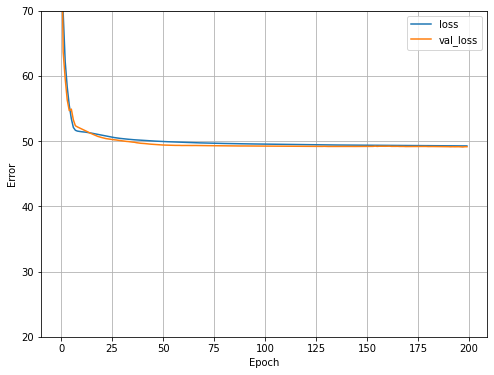

In [375]:
plot_loss(history)

In [376]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

122/122 - 0s - loss: 49.3213 - mae: 5.2182
Loss (MSE):  49.321258544921875
MAE:  5.2182488441467285



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.2643020408163265
STD of Relative Errors:  0.46994967563295514
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 775 / 2450 (31.63%)
  (10%, 20%]: 607 / 2450 (24.78%)
  (20%, 30%]: 414 / 2450 (16.9%)
  > 30%: 654 / 2450 (26.69%)
--------------------------------------------



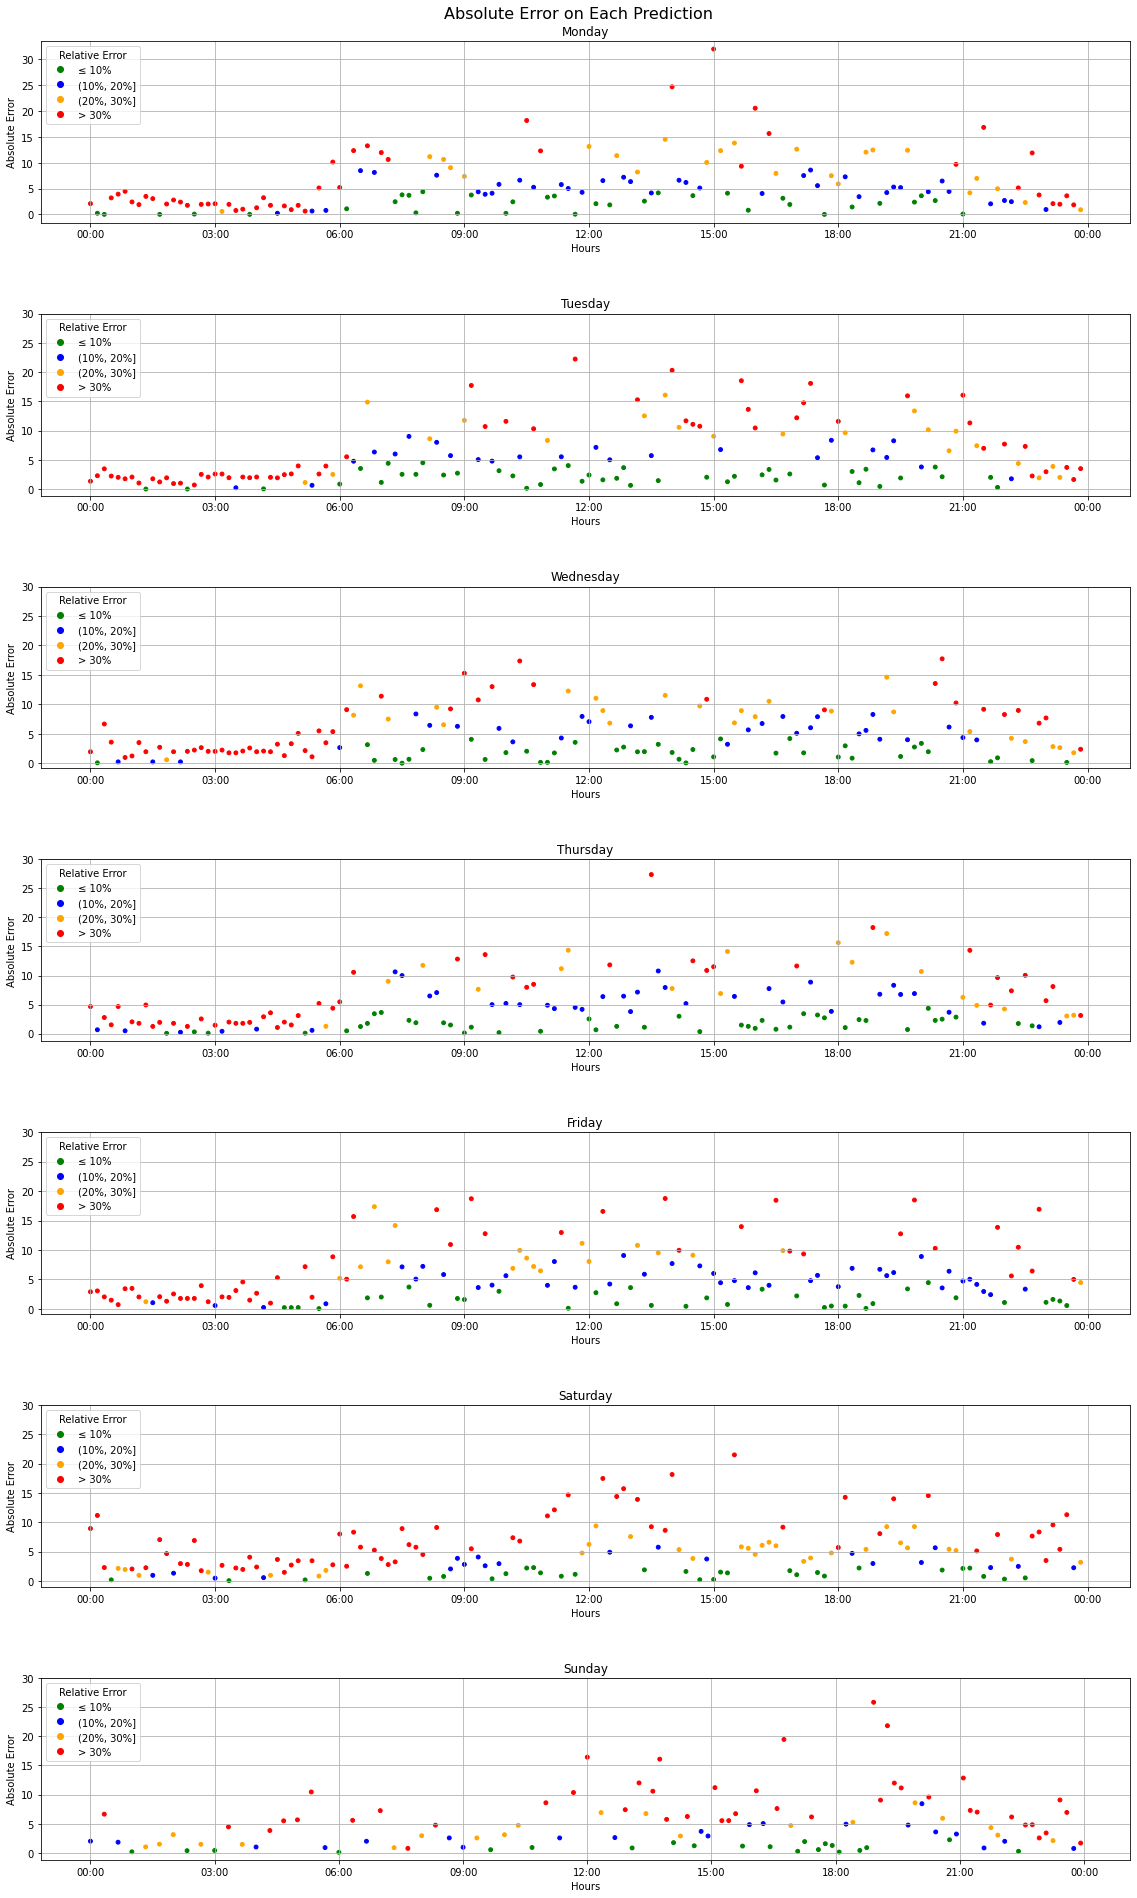

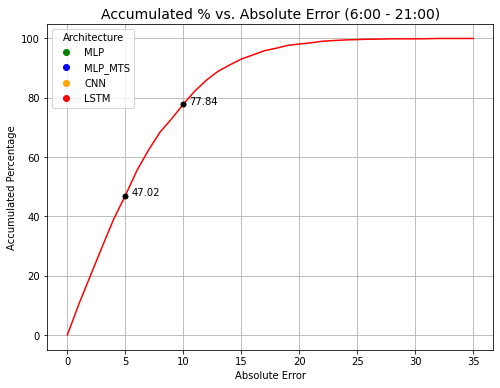

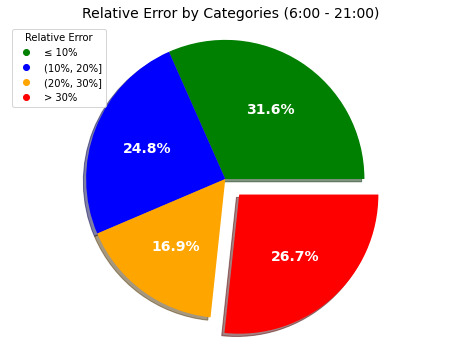

In [381]:
errors = graph_errors(pd.DataFrame(test_dates, columns= ['datetime']), pd.DataFrame(test_outputs,  columns= ['label_PM072']), predictions, freq = 4)

## Experimento #2

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #2** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM024` (Rotonda Camiño Novo - Avda. Romero Donallo)
- `PM030` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
- `PM031` (Avda. Romero Donallo - Rotonda Camiño Novo)
- `PM032` (Avda. Rosalía de Castro - Rotonda Camiño Novo)
* **No es posible, ya que este sensor estaba averiado** - `PM033` (Avda. Mestre Mateo - Rotonda Camiño Novo)

### Análisis dataset Experimento #2

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [68]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032', 'PM072']
df_2 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [69]:
df_2.describe().transpose()

count       mean       std  min  25%   50%   75%    max
car_count  198285.0  21.938856  16.33579  0.0  6.0  21.0  34.0  104.0

Veamos un boxplot:

<AxesSubplot:>

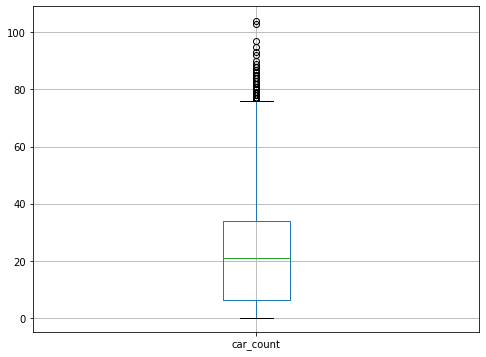

In [70]:
df_2.boxplot(column=['car_count'])

No parece haber un outlayer muy claro como en el apartado `Descripción del dataset`

### Análisis gráfico Experimento #2

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

Para determinar si la medición en la que se registró el mayor valor para `car_count` es un outlayer se puede
representar la evolución de ese día y de otros.

In [71]:
df_2.loc[df_2['car_count'] > 100]

sensor            datetime  car_count
1391671  PM024 2019-12-13 14:15:00        103
1483685  PM032 2019-12-18 10:50:00        104

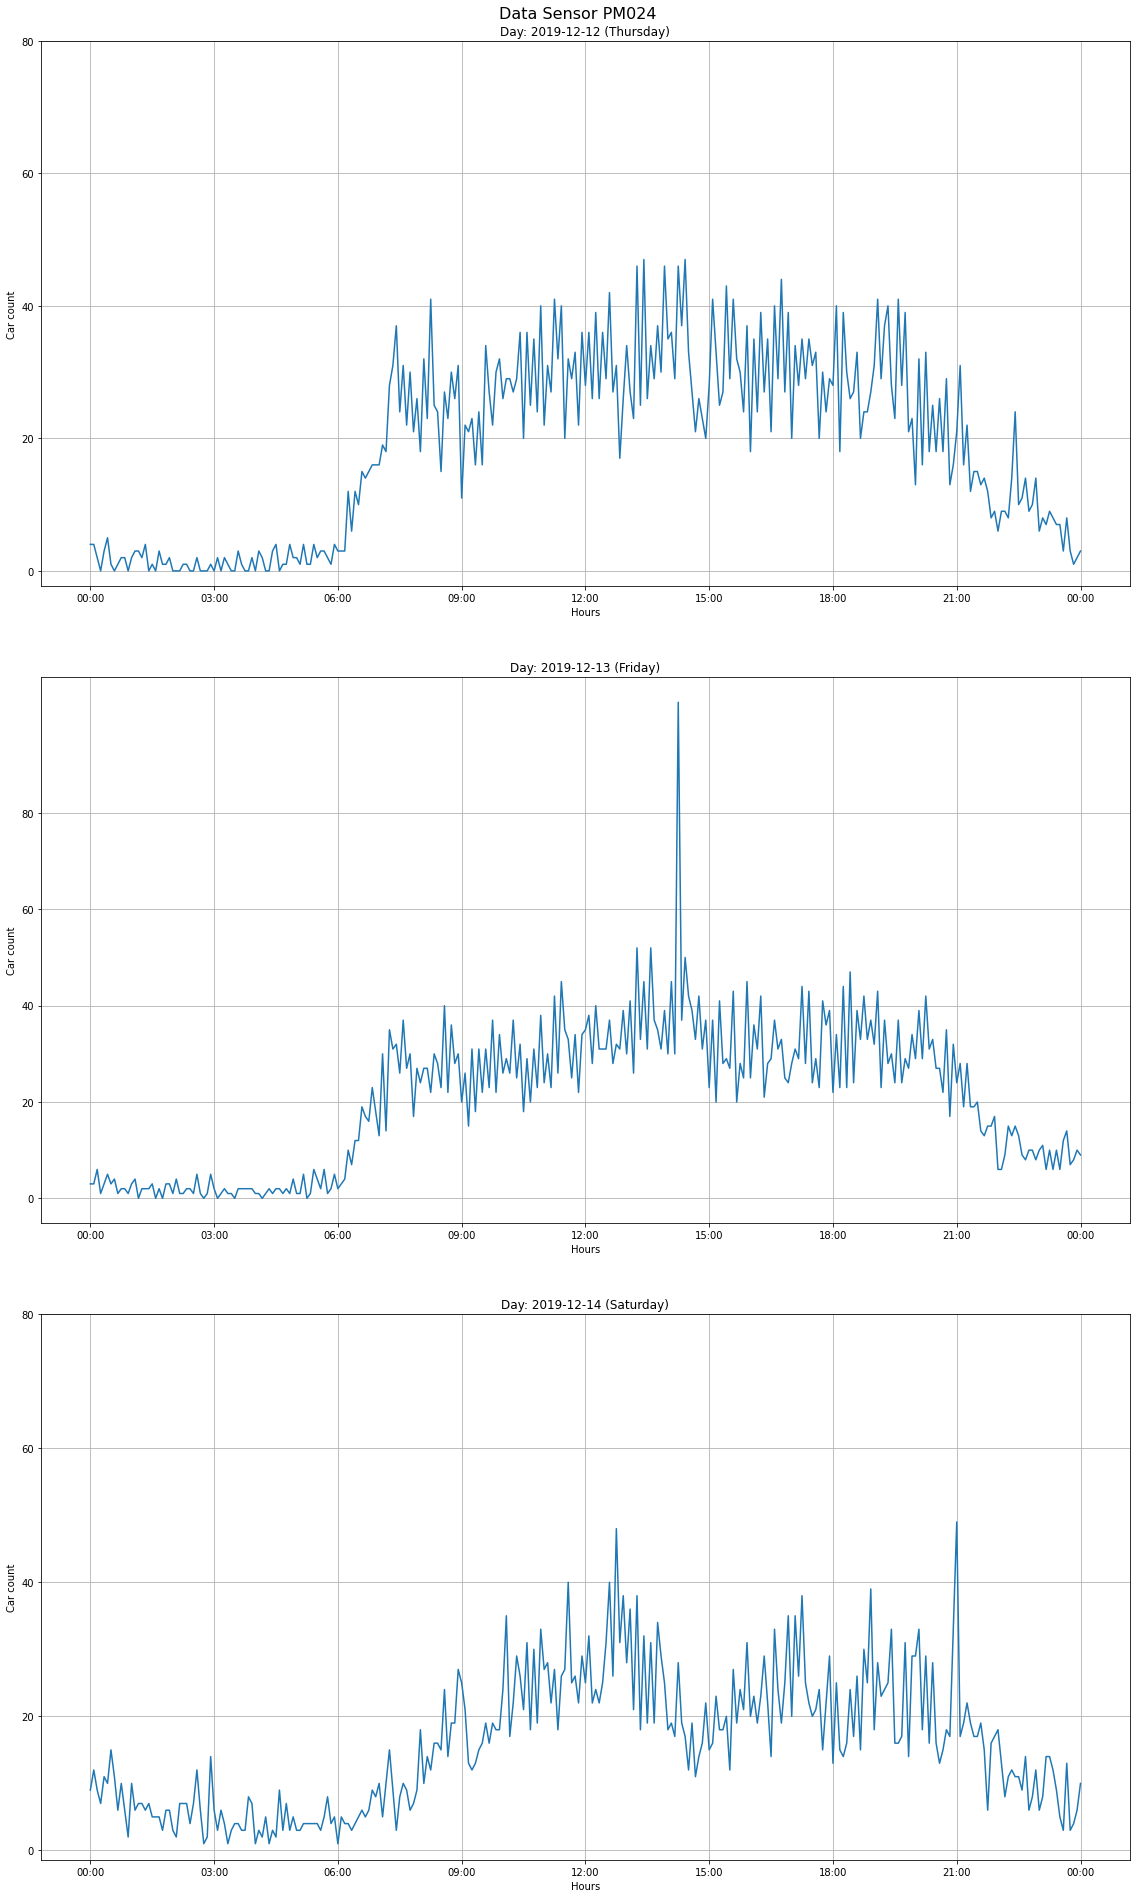

In [72]:
days = pd.date_range(start='2019-12-12', end='2019-12-14', freq='D')
plot_sensors_daily_data(df_orig=df_2, days_list = days, sensor='PM024')

En la gráfica correspondiente al `2019-12-17` se puede observar lo comentado en el anterior experimento. Los sensores
pueden fallar (o no realizar mediciones por labores de mantenimiento), por lo que, en caso de que esto suceda, **las mediciones
de los otros sensores que fueron realizados en ese mismo instante temporal deben ser descartadas.**

*De esto ya se encarga la función que ha sido creada para preparar el dataset.*

Por otra parte, la gráfica correspondiente `2019-12-18`, el día en el que se registró el máximo valor de `car_count`, se
puede observar un pico muy pronunciado. Para tener más claro si se trata de un error en la medición se pueden observar las
mediciones previas y posteriores a ese instante temporal para el sensor `PM032`:

In [73]:
df_2.loc[(df_2['datetime'] >= '2019-12-18 10:30:00') & (df_2['datetime'] <= '2019-12-18 11:00:00') & (df_2['sensor'] == 'PM032')]

sensor            datetime  car_count
1483539  PM032 2019-12-18 10:30:00         57
1483612  PM032 2019-12-18 10:35:00         52
1483685  PM032 2019-12-18 10:50:00        104
1483757  PM032 2019-12-18 10:55:00         46
1483831  PM032 2019-12-18 11:00:00         51

Observando las mediciones anteriores y posteriores se puede observar que no hay entradas para los 10 minutos anteriores.
**En ocasiones, los sensores se detienen o fallan y al recuperarse insertan como medición el total de coches que pasaron
durante esos minutos que estuvieron fuera de servicio. Este valor es el resultado de un error, por lo que la medición debe
ser eliminada:**

In [74]:
df_2 = df_2[df_2['car_count'] < 100.0]

Para determinar si alguna de las mediciones con mayor cuantía de vehículos (> 90) se trataba de un error se ha seguido un
procedimiento similar. **Finalmente, se ha determinado que ninguna de esas mediciones se trata de un error.**

### Preparación dataset Experimento #2

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [75]:
column_names = ['datetime', 'car_count_PM024', 'car_count_PM030', 'car_count_PM031', 'car_count_PM032', 'label_PM072']
pd.DataFrame(columns = column_names)

Empty DataFrame
Columns: [datetime, car_count_PM024, car_count_PM030, car_count_PM031, car_count_PM032, label_PM072]
Index: []

A continuación se utiliza la función para preparar el dataset para el Experimento #2:

In [76]:
sensors_list = ['PM024', 'PM030', 'PM031', 'PM032']
df_2 = prepare_df(df_2, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función que en el Experimento #1:

In [77]:
df_2 = encode_time_sin_cos(df_2)
df_2.head(n=3)

datetime  car_count_PM024  car_count_PM030  car_count_PM031  \
0 2019-10-01 00:00:00                2                3                3   
1 2019-10-01 00:05:00                0                5                0   
2 2019-10-01 00:10:00                0                1                0   

   car_count_PM032  label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
0                1            0  0.000000  1.000000  0.781831   0.62349  
1                2            0  0.021815  0.999762  0.781831   0.62349  
2                1            0  0.043619  0.999048  0.781831   0.62349

### Implementación Perceptrón Multicapa (MLP)

#### División del dataset, Separación y Normalización

In [78]:
#Shuffle
df_2_shuffled=df_2.sample(frac=1).reset_index(drop=True)

n = len(df_2_shuffled)
train_df_2 = df_2_shuffled[0:int(n*0.90)]
test_df_2 = df_2_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_2.pop('datetime')
test_dates = test_df_2.pop('datetime')

In [79]:
train_labels = train_df_2.pop('label_PM072')
train_features = train_df_2

test_labels = test_df_2.pop('label_PM072')
test_features = test_df_2

In [80]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [81]:
train_features

car_count_PM024  car_count_PM030  car_count_PM031  car_count_PM032  \
0             1.480882         1.301785         0.658192         0.738206   
1            -0.406228        -0.361148         0.060278         0.284976   
2            -0.799376        -0.361148        -0.537636        -1.125073   
3            -0.484858        -0.587911        -0.139027        -0.520766   
4             1.480882         0.621494         1.189671         1.292154   
...                ...              ...              ...              ...   
34891        -1.035265        -0.890263        -0.537636        -1.125073   
34892         1.166364         1.150609         1.521845         0.133899   
34893        -0.799376        -0.965851        -0.736940        -0.369690   
34894        -0.013080         0.545906         0.791062         0.738206   
34895         0.615957         0.394731         0.923931         0.838924   

       hour_sin  hour_cos  wday_sin  wday_cos  
0     -1.305977 -0.539348  0.030227  1.440798  
1     -1.408273  0.124912 -1.067024  0.903884  
2     -0.511770  1.319367  1.398475 -0.302552  
3      1.001194 -0.998019 -1.067024  0.903884  
4      0.626586 -1.266311  0.639155 -1.270039  
...         ...       ...       ...       ...  
34891 -0.153071  1.407091  1.127477  0.903884  
34892  0.626586 -1.266311  1.398475 -0.302552  
34893  1.414170 -0.059978  1.127477  0.903884  
34894 -1.042012  0.956843 -1.338022 -0.302552  
34895  1.001194 -0.998019 -0.578701 -1.270039  

[34896 rows x 8 columns]

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [83]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(256,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dropout(0.2),
      layers.Dense(256,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [84]:
model = build_and_compile_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2304      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 68,353
Trainable params: 68,353
Non-trainable params: 0
_________________________________________________________________


In [85]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 7min 48s, sys: 57.3 s, total: 8min 46s
Wall time: 5min 43s


In [86]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  49.583679  5.163289  45.474041  4.942951    195
196  49.612312  5.171288  45.404797  4.956030    196
197  49.629509  5.170559  45.531811  4.982544    197
198  49.396305  5.162838  45.930519  5.031653    198
199  49.371967  5.144891  45.739529  5.013292    199

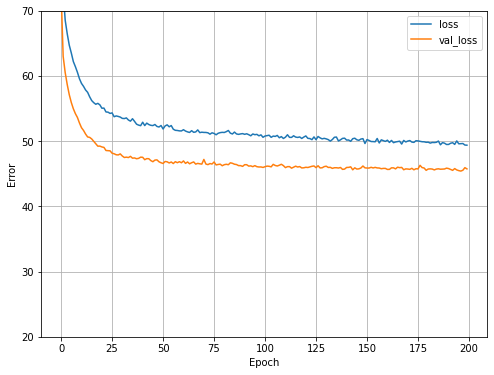

In [87]:
plot_loss(history)

In [88]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

122/122 - 0s - loss: 49.0788 - mae: 5.1261
Loss (MSE):  49.07878875732422
MAE:  5.126100540161133



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.26623629719853836
STD of Relative Errors:  0.4647456833068248
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 784 / 2463 (31.83%)
  (10%, 20%]: 656 / 2463 (26.63%)
  (20%, 30%]: 393 / 2463 (15.96%)
  > 30%: 630 / 2463 (25.58%)
--------------------------------------------



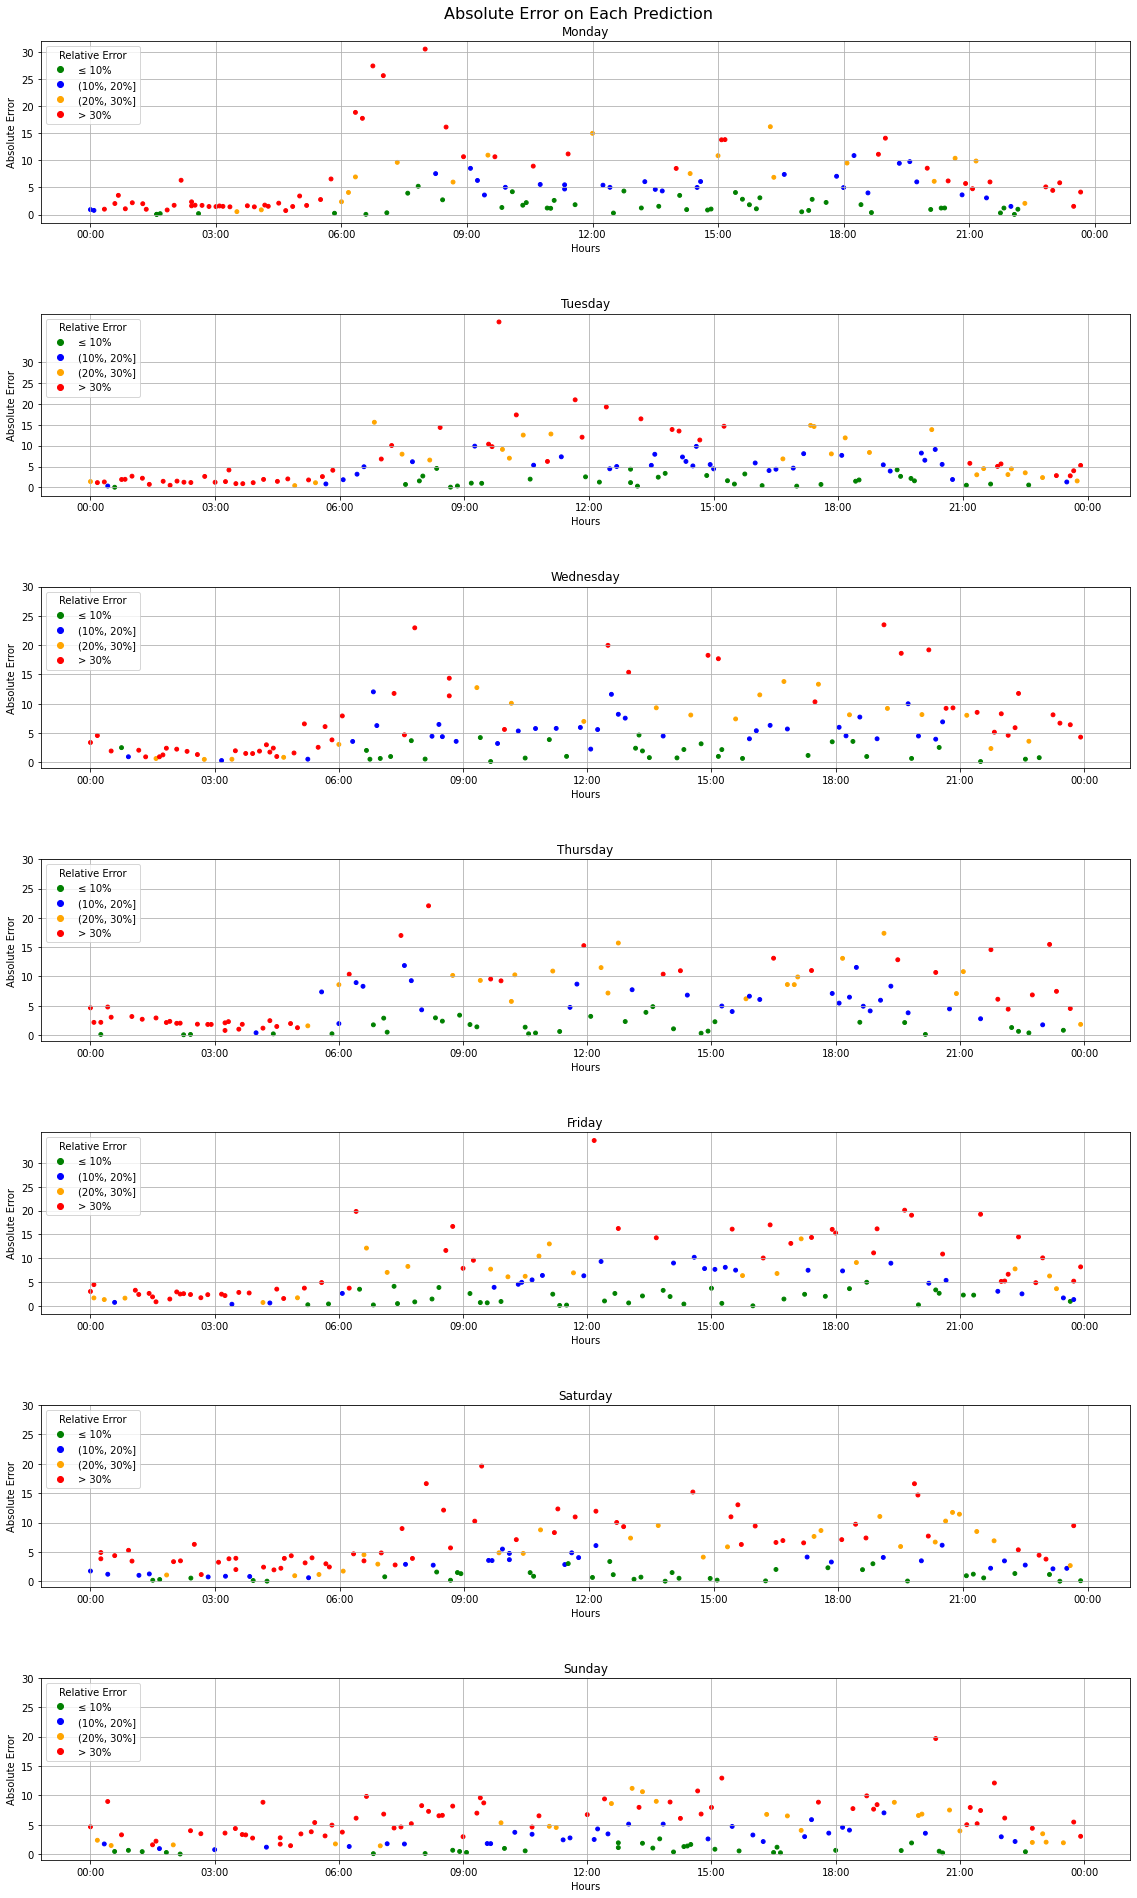

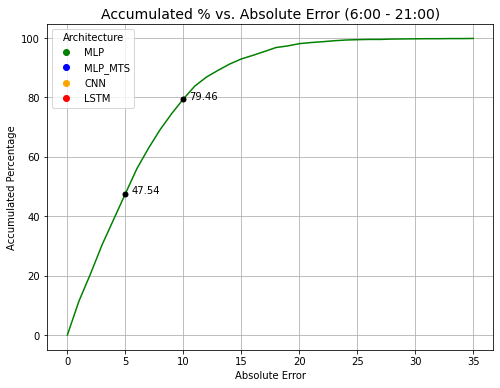

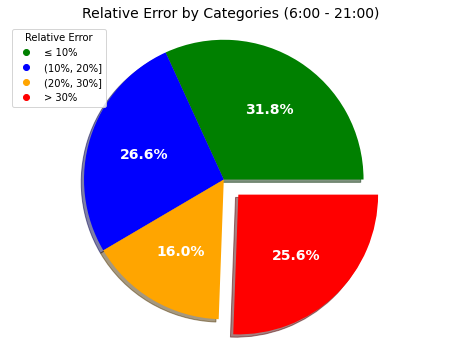

In [89]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #2`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente de los sensores `PM024, PM030, PM031 y PM032` en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #2` tiene la siguiente forma:

In [91]:
df_2

datetime  car_count_PM024  car_count_PM030  car_count_PM031  \
0     2019-10-01 00:00:00                2                3                3   
1     2019-10-01 00:05:00                0                5                0   
2     2019-10-01 00:10:00                0                1                0   
3     2019-10-01 00:15:00                3                2                3   
4     2019-10-01 00:20:00                0                0                1   
...                   ...              ...              ...              ...   
38769 2020-02-29 23:30:00               10               26               10   
38770 2020-02-29 23:35:00                2               17                8   
38771 2020-02-29 23:40:00               10               11                5   
38772 2020-02-29 23:45:00                3               15               11   
38773 2020-02-29 23:50:00                9               21                9   

       car_count_PM032  label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
0                    1            0  0.000000  1.000000  0.781831  0.623490  
1                    2            0  0.021815  0.999762  0.781831  0.623490  
2                    1            0  0.043619  0.999048  0.781831  0.623490  
3                    3            0  0.065403  0.997859  0.781831  0.623490  
4                    3            1  0.087156  0.996195  0.781831  0.623490  
...                ...          ...       ...       ...       ...       ...  
38769               15            8 -0.130526  0.991445 -0.974928 -0.222521  
38770               10            7 -0.108867  0.994056 -0.974928 -0.222521  
38771               14           11 -0.087156  0.996195 -0.974928 -0.222521  
38772                5           22 -0.065403  0.997859 -0.974928 -0.222521  
38773                9           20 -0.043619  0.999048 -0.974928 -0.222521  

[38774 rows x 10 columns]

Utilizando la función anteriormente definida se creará el DataFrama con la información necesaria para el Experimento:

In [92]:
df_2_multi_timestep = prepare_multi_timestep_df(df_2)
df_2_multi_timestep

datetime     0     1     2     3         4         5  \
0     2019-10-01 00:10:00   2.0   3.0   3.0   1.0  0.000000  1.000000   
1     2019-10-01 00:15:00   0.0   5.0   0.0   2.0  0.021815  0.999762   
2     2019-10-01 00:20:00   0.0   1.0   0.0   1.0  0.043619  0.999048   
3     2019-10-01 00:25:00   3.0   2.0   3.0   3.0  0.065403  0.997859   
4     2019-10-01 00:30:00   0.0   0.0   1.0   3.0  0.087156  0.996195   
...                   ...   ...   ...   ...   ...       ...       ...   
38703 2020-02-29 23:30:00   7.0  14.0  11.0  21.0 -0.173648  0.984808   
38704 2020-02-29 23:35:00   4.0  14.0  11.0  18.0 -0.152123  0.988362   
38705 2020-02-29 23:40:00  10.0  26.0  10.0  15.0 -0.130526  0.991445   
38706 2020-02-29 23:45:00   2.0  17.0   8.0  10.0 -0.108867  0.994056   
38707 2020-02-29 23:50:00  10.0  11.0   5.0  14.0 -0.087156  0.996195   

              6         7     8  ...        15    16    17    18    19  \
0      0.781831  0.623490   0.0  ...  0.623490   0.0   1.0   0.0   1.0   
1      0.781831  0.623490   0.0  ...  0.623490   3.0   2.0   3.0   3.0   
2      0.781831  0.623490   3.0  ...  0.623490   0.0   0.0   1.0   3.0   
3      0.781831  0.623490   0.0  ...  0.623490   1.0   2.0   0.0   0.0   
4      0.781831  0.623490   1.0  ...  0.623490   0.0   0.0   2.0   1.0   
...         ...       ...   ...  ...       ...   ...   ...   ...   ...   
38703 -0.974928 -0.222521   4.0  ... -0.222521  10.0  26.0  10.0  15.0   
38704 -0.974928 -0.222521  10.0  ... -0.222521   2.0  17.0   8.0  10.0   
38705 -0.974928 -0.222521   2.0  ... -0.222521  10.0  11.0   5.0  14.0   
38706 -0.974928 -0.222521  10.0  ... -0.222521   3.0  15.0  11.0   5.0   
38707 -0.974928 -0.222521   3.0  ... -0.222521   9.0  21.0   9.0   9.0   

             20        21        22        23  label_PM072  
0      0.043619  0.999048  0.781831  0.623490            0  
1      0.065403  0.997859  0.781831  0.623490            0  
2      0.087156  0.996195  0.781831  0.623490            1  
3      0.108867  0.994056  0.781831  0.623490            0  
4      0.130526  0.991445  0.781831  0.623490            2  
...         ...       ...       ...       ...          ...  
38703 -0.130526  0.991445 -0.974928 -0.222521            8  
38704 -0.108867  0.994056 -0.974928 -0.222521            7  
38705 -0.087156  0.996195 -0.974928 -0.222521           11  
38706 -0.065403  0.997859 -0.974928 -0.222521           22  
38707 -0.043619  0.999048 -0.974928 -0.222521           20  

[38708 rows x 26 columns]

#### División, Separación y Normalización

In [93]:
# Shuffle
df_2_mts_shuffled=df_2_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_2_mts_shuffled)
train_df_2_mts = df_2_mts_shuffled[0:int(n*0.90)]
test_df_2_mts = df_2_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_2_mts.pop('datetime')
test_dates = test_df_2_mts.pop('datetime')

In [94]:
train_labels = train_df_2_mts.pop('label_PM072')
train_features = train_df_2_mts

test_labels = test_df_2_mts.pop('label_PM072')
test_features = test_df_2_mts

In [95]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [96]:
train_features

0         1         2         3         4         5         6   \
0     -0.091158  0.095014  0.592454  1.093951 -1.084833  0.910474 -1.336156   
1     -0.799256 -1.193628 -1.068781 -0.267865  1.405551 -0.180980 -1.336156   
2     -0.720578 -0.283999 -0.072040 -0.015677  1.332217 -0.479482 -1.336156   
3      1.010328  1.004643  1.057600  0.236511 -0.861961 -1.116493 -0.576342   
4     -0.248513  0.398223 -0.005591  0.186074 -1.001318  1.001254 -1.336156   
...         ...       ...       ...       ...       ...       ...       ...   
34832 -0.720578 -0.587208 -1.002332 -0.973992  1.409252  0.156899  1.402119   
34833  1.403716  0.246618  1.655645  1.346140  0.093338 -1.405132 -0.576342   
34834 -1.192644 -1.421035 -1.334579 -1.427931  0.246723  1.393201  1.130944   
34835 -0.563223  0.095014 -0.470737 -0.721804 -0.760699  1.193606  0.032981   
34836 -0.248513  0.701433  0.127308  1.447015 -1.415003 -0.058320 -1.064982   

             7         8         9   ...        14        15        16  \
0     -0.308027  0.461276  0.624730  ... -1.336126 -0.308015  0.224466   
1     -0.308027 -0.483482 -0.889985  ... -1.336126 -0.308015 -0.719575   
2     -0.308027  0.067627  0.170316  ... -1.336126 -0.308015 -0.562235   
3     -1.274887  1.799684  0.851938  ... -0.576291 -1.274850  0.224466   
4     -0.308027  0.697466 -0.435570  ... -1.336126 -0.308015 -0.326225   
...         ...       ...       ...  ...       ...       ...       ...   
34832 -0.308027 -0.877132 -0.889985  ...  1.402224 -0.308015 -0.798246   
34833 -1.274887  0.146357  0.776202  ... -0.576291 -1.274850  1.247178   
34834  0.897627 -1.349511 -1.344399  ...  1.131042  0.897608 -1.270266   
34835  1.434194 -0.719672 -0.662778  ...  0.033049  1.434161 -0.640905   
34836  0.897627  0.618736  0.473259  ... -1.064944  0.897608 -0.483565   

             17        18        19        20        21        22        23  
0      0.474370  0.327939  0.388248 -1.044192  0.956501 -1.336024 -0.307925  
1     -0.662147 -0.536076 -0.166580  1.396640 -0.241813 -1.336024 -0.307925  
2      0.247067  0.394401  0.337809  1.310282 -0.536771 -1.336024 -0.307925  
3      0.474370  0.195013  1.548342 -0.910265 -1.077711 -0.576146 -1.274709  
4     -0.056004  0.128551 -0.065702 -0.956759  1.043544 -1.336024 -0.307925  
...         ...       ...       ...       ...       ...       ...       ...  
34832 -0.434843 -1.001314 -0.872724  1.415138  0.095499  1.402482 -0.307925  
34833  0.322835  0.793177  1.346587  0.031723 -1.407497 -0.576146 -1.274709  
34834 -1.495592 -1.333627 -1.477991  0.307578  1.380810  1.131284  0.897636  
34835 -0.207540 -0.934851 -0.771847 -0.707882  1.225213  0.033229  1.434162  
34836  0.398603  0.460864  0.590003 -1.416567  0.003212 -1.064827  0.897636  

[34837 rows x 24 columns]

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [97]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(16,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [98]:
model = build_and_compile_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________


In [99]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 4min 23s, sys: 32.1 s, total: 4min 56s
Wall time: 3min 57s


In [100]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  43.400368  4.843360  43.234421  4.890380    195
196  43.392101  4.844921  43.239834  4.874455    196
197  43.352970  4.841425  43.463768  4.897543    197
198  43.362965  4.842962  43.340549  4.860272    198
199  43.376823  4.842321  43.250568  4.871159    199

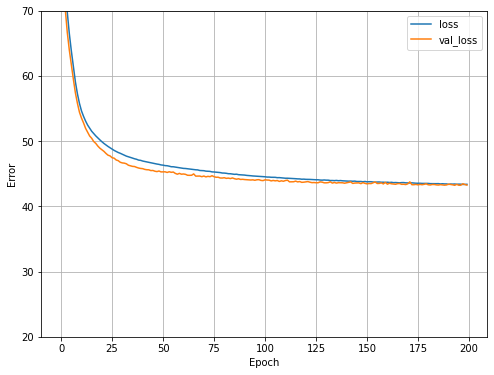

In [101]:
plot_loss(history)

In [102]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

121/121 - 0s - loss: 46.5119 - mae: 4.9943
Loss (MSE):  46.51192855834961
MAE:  4.994297027587891



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.2530857611817809
STD of Relative Errors:  0.3724681332595968
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 766 / 2437 (31.43%)
  (10%, 20%]: 689 / 2437 (28.27%)
  (20%, 30%]: 447 / 2437 (18.34%)
  > 30%: 535 / 2437 (21.95%)
--------------------------------------------



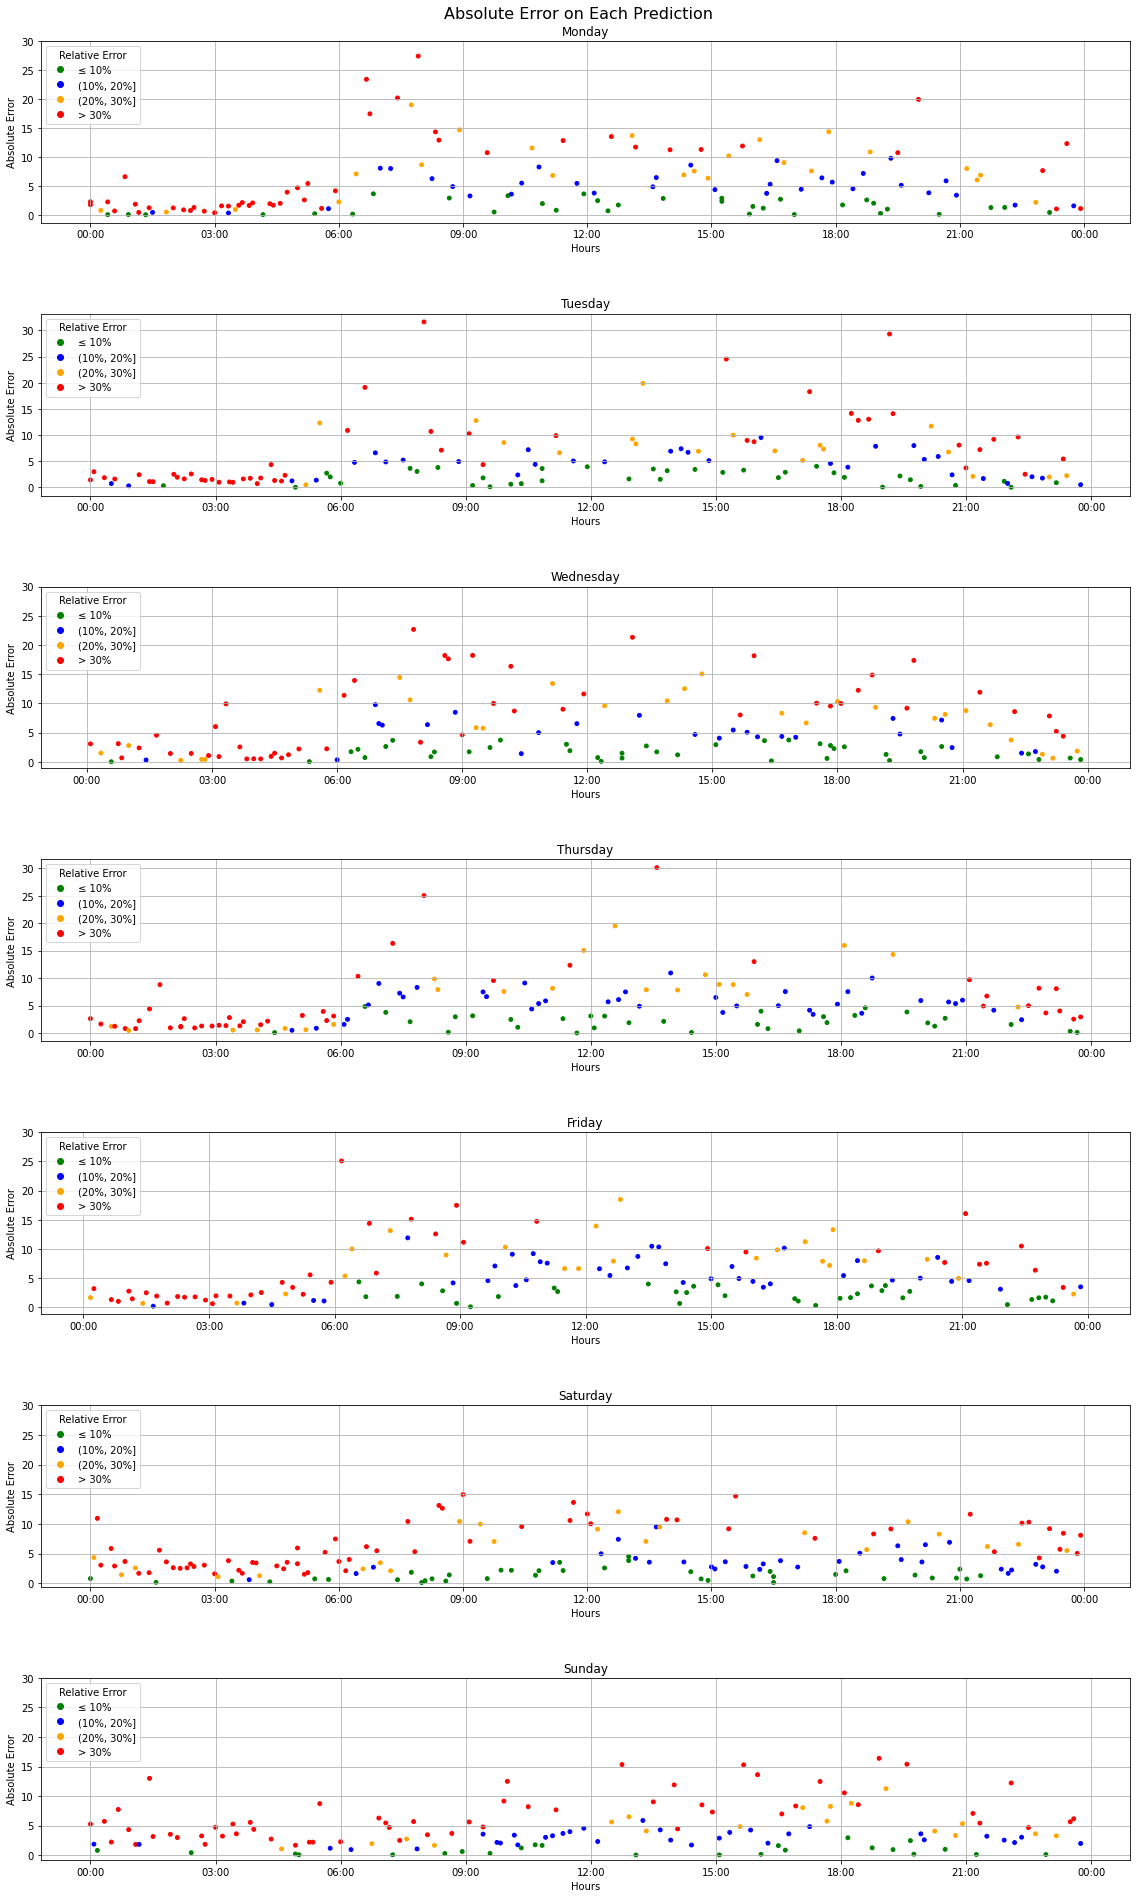

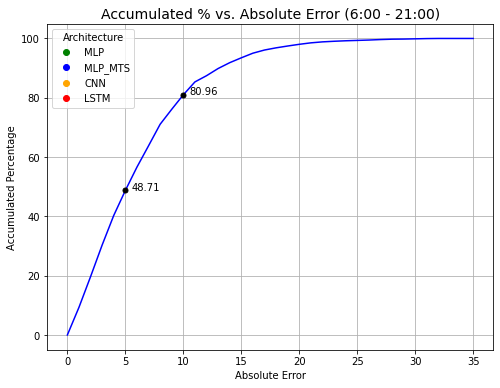

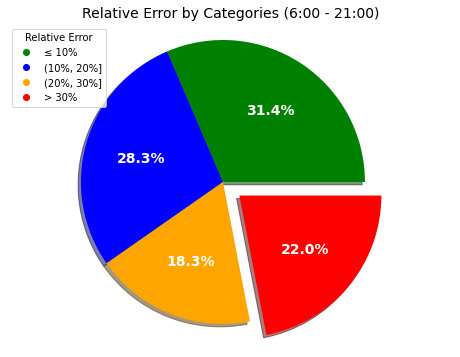

In [103]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

## Experimento #3

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #3** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t` a partir de
las mediciones realizadas en un instante `t-x` por los sensores:
- `PM020` (Rotonda Galuresa - Avda. Romero Donallo)
- `PM076` (Rúa do Horreo - Rotonda Galuresa)
- `PM077` (Avda. Romero Donallo - Rotonda Galuresa)
- `PM079` (Rúa do Horreo - Rotonda Galuresa)

### Análisis dataset Experimento #3

En primer lugar, hay que obtener solo aquellas mediciones que hayan sido tomadas por los sensores que resultan
de interés para el experimento:

In [107]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079', 'PM072']
df_3 = df.loc[df['sensor'].isin(sensors_list)]

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [108]:
df_3.describe().transpose()

count       mean       std  min  25%   50%   75%    max
car_count  198102.0  15.054209  13.07343  0.0  3.0  13.0  23.0  311.0

Veamos un boxplot:

<AxesSubplot:>

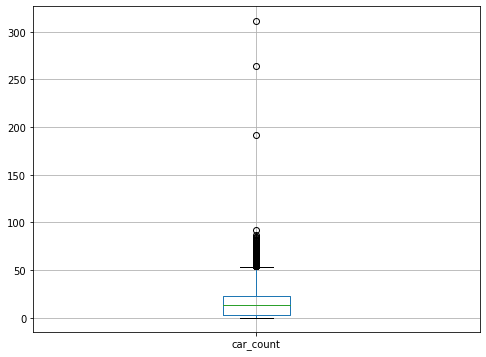

In [109]:
df_3.boxplot(column=['car_count'])

En este boxplot se pueden ver 3 outalyers muy claros. En la siguiente sección se determinará la causa de dichos valores.

### Análisis gráfico Experimento #3

Utilizando la función previamente creada se realizarán una serie de gráficas para ver la evolución de los datos del tráfico
de manera más intuitiva.

A continuación se analizarán las mediciones 'sospechosas' del boxplot anterior:

In [110]:
df_3.loc[df_3['car_count'] > 100]

sensor            datetime  car_count
952401  PM079 2019-11-22 14:20:00        191
952415  PM077 2019-11-22 14:20:00        264
952416  PM076 2019-11-22 14:20:00        311

Resulta interesante ver que las 3 mediciones se produjeron en el mismo instante temporal.

En la siguiente gráfica se muestra la evolución del día anterior y siguiente al `2019-11-22` para el
sensor `PM079`:

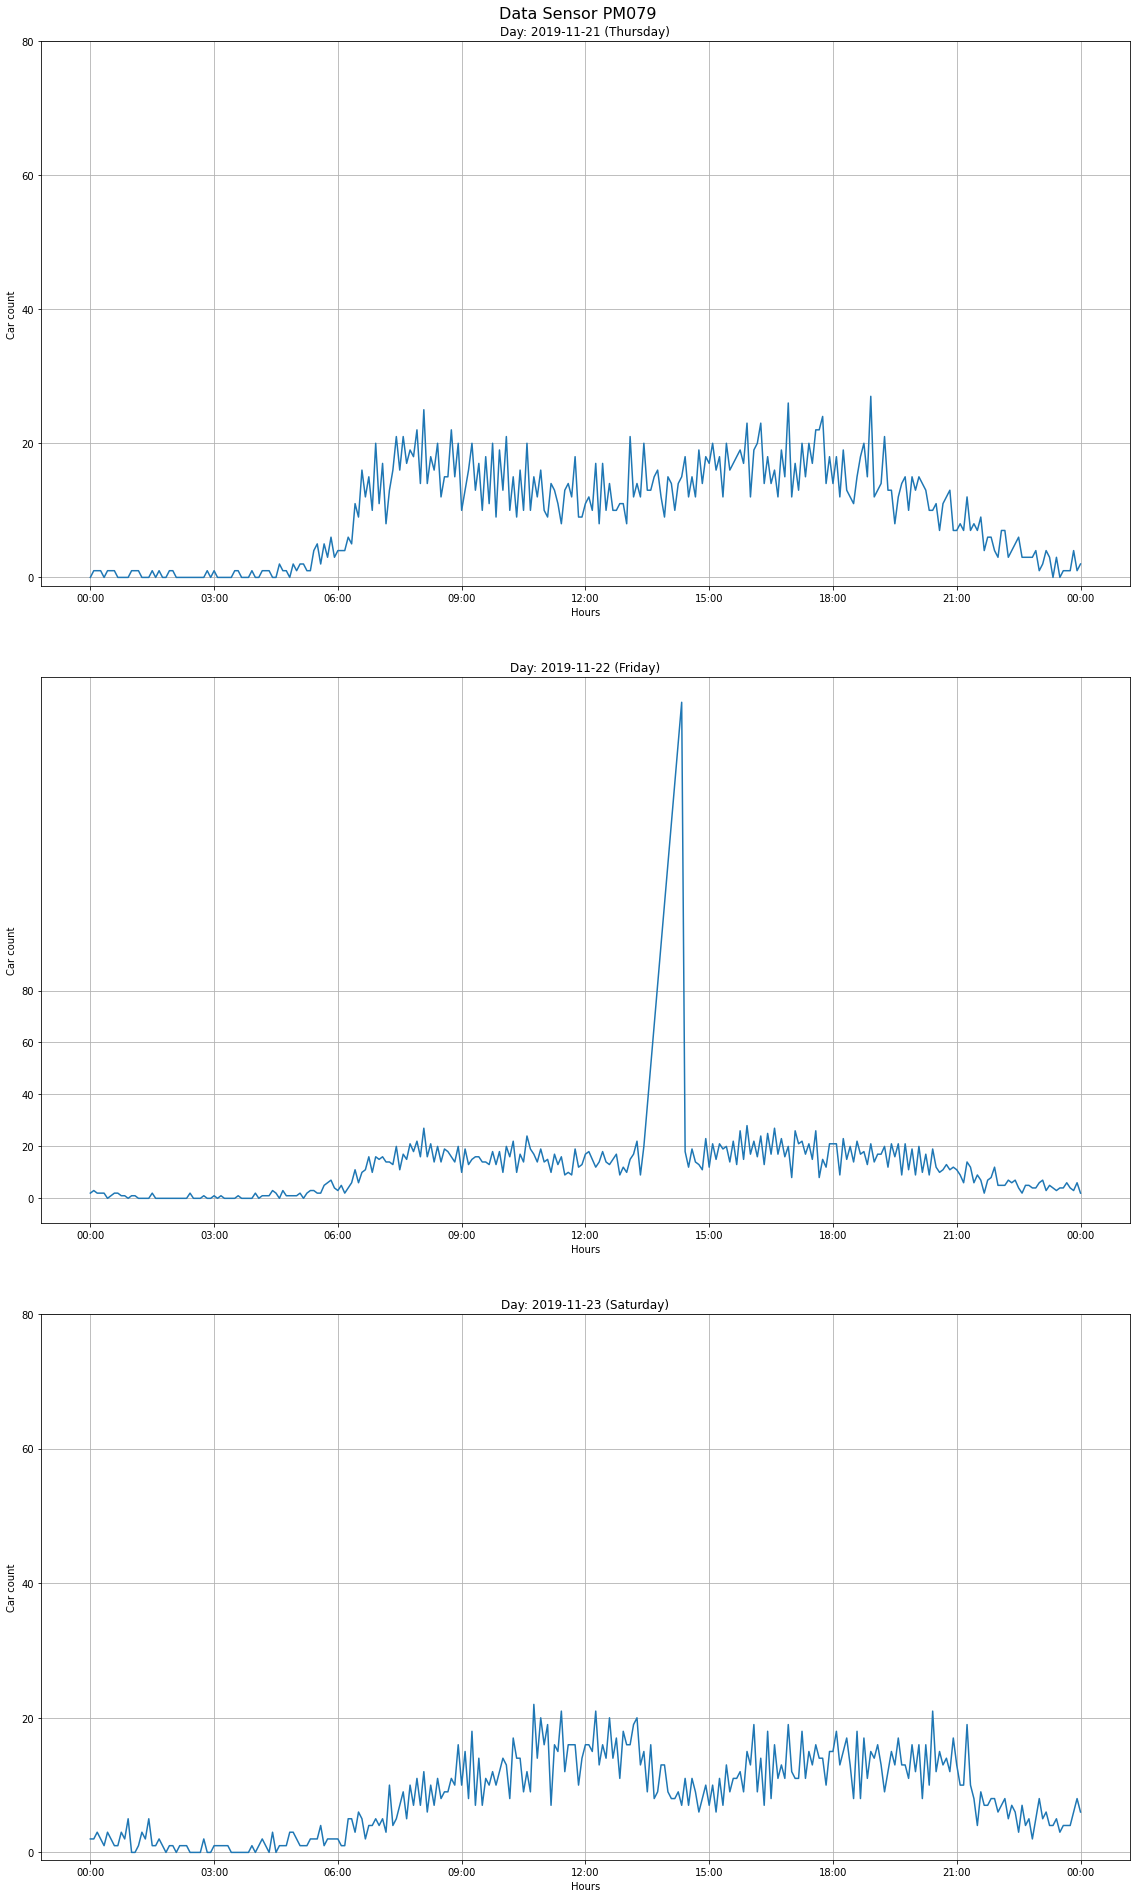

In [111]:
days = pd.date_range(start='2019-11-21', end='2019-11-23', freq='D')
plot_sensors_daily_data(df_orig=df_3, days_list = days, sensor='PM079')

En la gráfica correspondiente al `2019-11-22` se puede observar lo comentado en el anterior experimento. Al tratarse de
un error en las mediciones estos datos deben ser eliminados del conjunto:

In [112]:
df_3 = df_3[df_3['car_count'] < 100]

El resto de mediciones se encuentran dentro de lo normal

### Preparación dataset Experimento #3

#### Label PM072

Para este experimento, el vector de características que necesita el modelo tiene la siguiente forma:

In [113]:
column_names = ['datetime', 'car_count_PM020', 'car_count_PM076', 'car_count_PM077', 'car_count_PM079', 'label_PM072']
pd.DataFrame(columns = column_names)

Empty DataFrame
Columns: [datetime, car_count_PM020, car_count_PM076, car_count_PM077, car_count_PM079, label_PM072]
Index: []

A continuación se utiliza la función para preparar el dataset para el Experimento #3:

In [114]:
sensors_list = ['PM020', 'PM076', 'PM077', 'PM079']
df_3 = prepare_df(df_3, sensors_list, 'PM072', x = 5)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [115]:
df_3 = encode_time_sin_cos(df_3)
df_3.sample()

datetime  car_count_PM020  car_count_PM076  car_count_PM077  \
33061 2020-02-10 20:40:00               21               24               10   

       car_count_PM079  label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
33061                7           44 -0.766044  0.642788       0.0       1.0

### Implementación Perceptrón Multicapa (MLP)

#### División del dataset, Separación y Normalización

In [116]:
#Shuffle
df_3_shuffled=df_3.sample(frac=1).reset_index(drop=True)

n = len(df_3_shuffled)
train_df_3 = df_3_shuffled[0:int(n*0.90)]
test_df_3 = df_3_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_3.pop('datetime')
test_dates = test_df_3.pop('datetime')

In [117]:
train_labels = train_df_3.pop('label_PM072')
train_features = train_df_3

test_labels = test_df_3.pop('label_PM072')
test_features = test_df_3

In [118]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [119]:
train_features

car_count_PM020  car_count_PM076  car_count_PM077  car_count_PM079  \
0            -0.730195        -0.434160        -0.866589        -0.895522   
1             0.095398         0.662053         1.005131         0.963587   
2            -0.248599        -0.334504         0.131661        -0.037472   
3            -1.280590        -1.131750        -0.991371        -1.181539   
4            -1.142992        -1.331062        -1.116152        -1.181539   
...                ...              ...              ...              ...   
34709         0.026599        -0.035537         0.256443         1.106595   
34710        -0.867794        -0.733127        -0.991371        -1.181539   
34711        -0.661395        -0.733127        -0.741808        -0.752514   
34712         1.058591         1.359643         2.128163         0.677570   
34713        -1.280590        -1.430718        -1.240934        -0.752514   

       hour_sin  hour_cos  wday_sin  wday_cos  
0     -0.509461  1.321737 -1.065412  0.898266  
1      0.096171 -1.404897  0.031622  1.435276  
2     -1.190277 -0.754191 -1.065412  0.898266  
3      1.244645  0.684510 -1.065412  0.898266  
4      0.737942  1.212812 -1.336357 -0.308386  
...         ...       ...       ...       ...  
34709  0.684456 -1.233754 -1.336357 -0.308386  
34710 -0.509461  1.321737 -1.065412  0.898266  
34711 -0.858146  1.125838  1.399602 -0.308386  
34712 -0.782851 -1.169812  0.031622  1.435276  
34713 -0.704188  1.228513  1.128657  0.898266  

[34714 rows x 8 columns]

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [120]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(64,
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(64,
                   activation='relu'),
      layers.Dense(64,
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.5),


  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [121]:
model = build_and_compile_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
_________________________________________________________________


In [122]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 4min 47s, sys: 35.1 s, total: 5min 22s
Wall time: 4min 4s


In [123]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  42.036236  4.779827  45.840549  4.944852    195
196  42.012501  4.780956  45.361019  4.960489    196
197  41.992748  4.777882  45.504059  4.938211    197
198  41.960606  4.778318  45.267750  4.963882    198
199  42.018173  4.776608  45.383018  4.948577    199

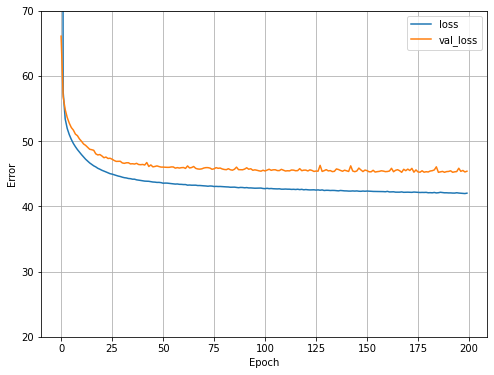

In [124]:
plot_loss(history)

In [125]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

121/121 - 0s - loss: 43.4228 - mae: 4.8122
Loss (MSE):  43.42279052734375
MAE:  4.812249183654785



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.24421274799493456
STD of Relative Errors:  0.369487499317107
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 793 / 2369 (33.47%)
  (10%, 20%]: 601 / 2369 (25.37%)
  (20%, 30%]: 429 / 2369 (18.11%)
  > 30%: 546 / 2369 (23.05%)
--------------------------------------------



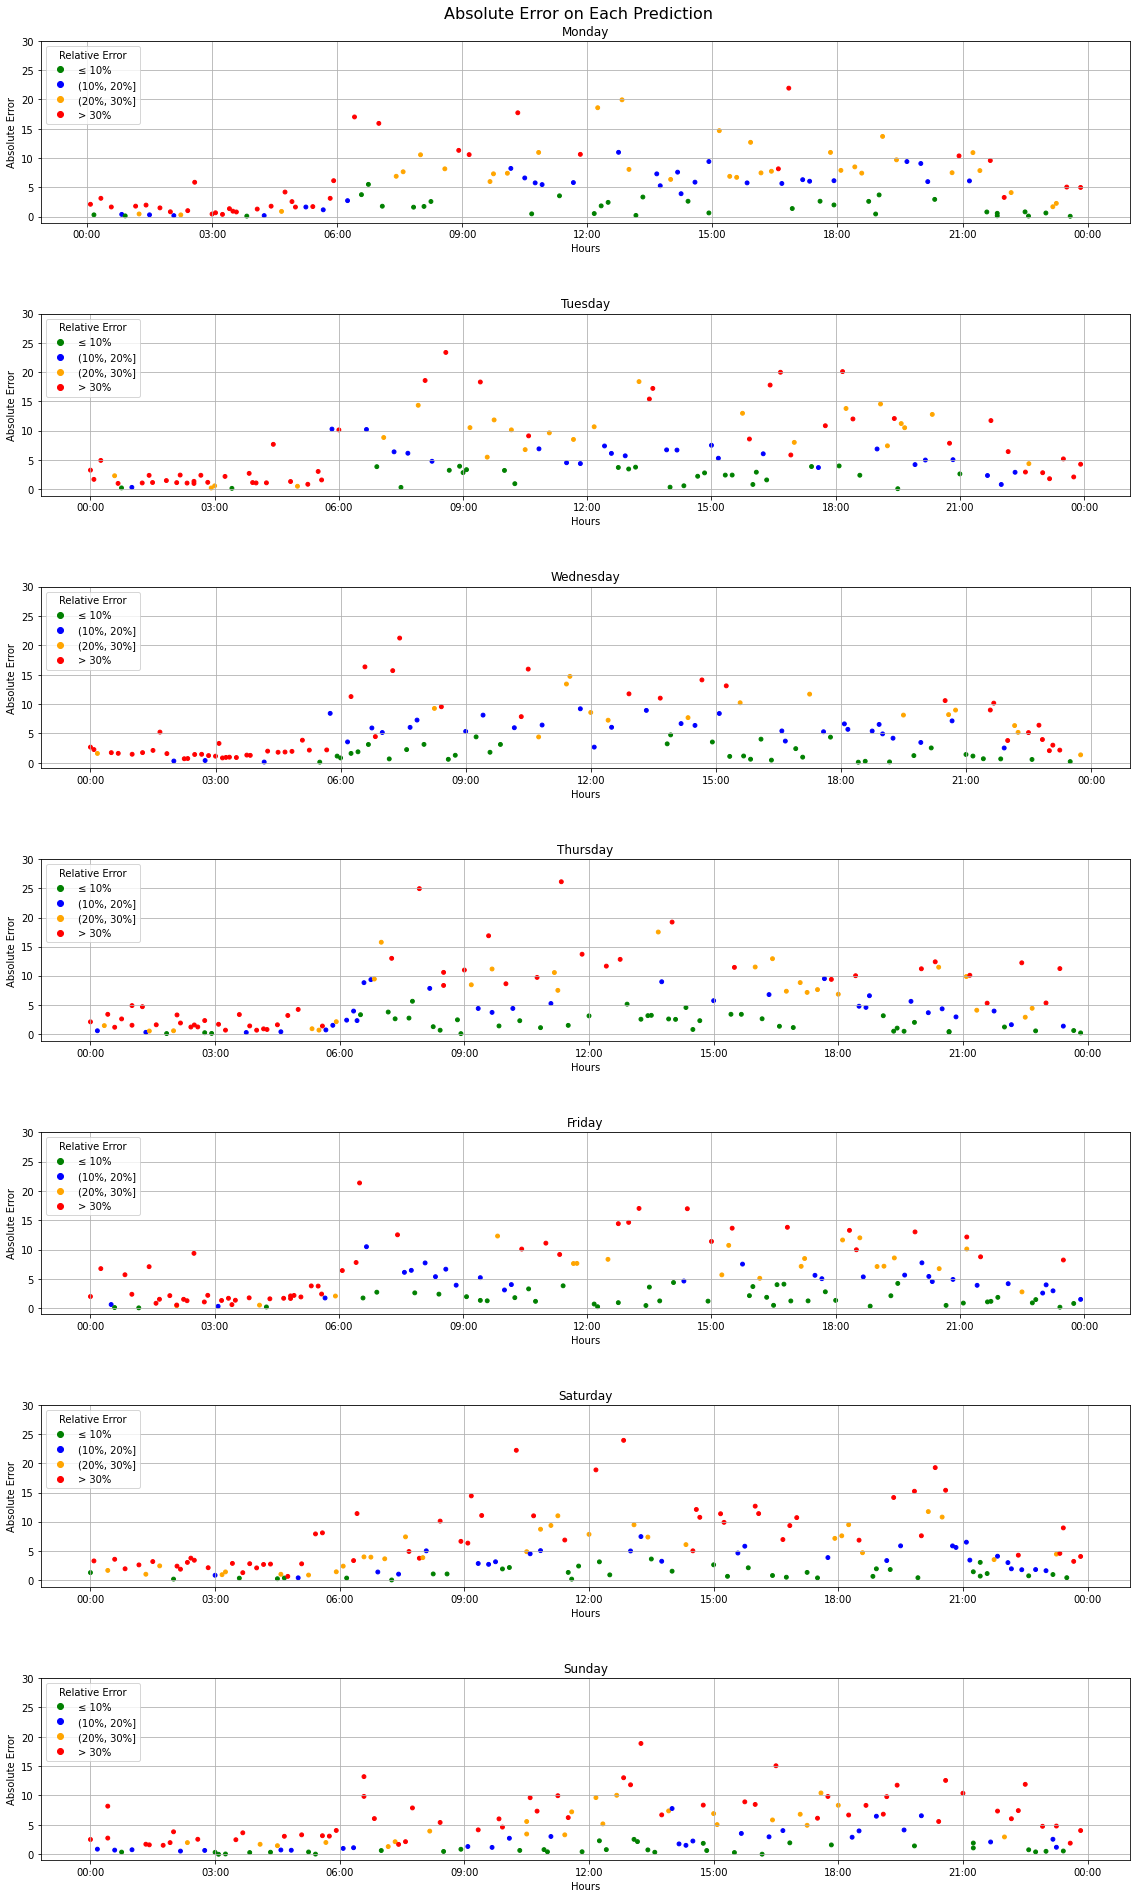

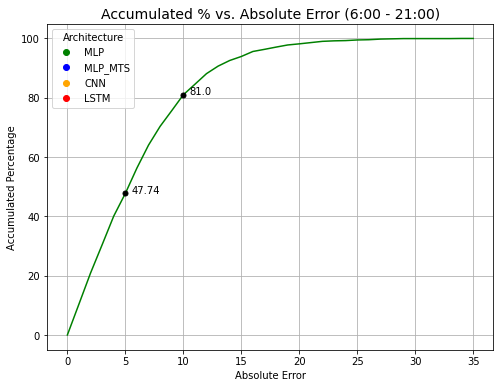

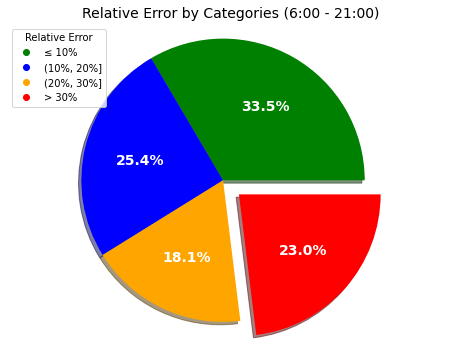

In [126]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #3`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente de los sensores `PM020, PM076, PM077 y PM079` en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #3` tiene la siguiente forma:

In [141]:
df_3

datetime  car_count_PM020  car_count_PM076  car_count_PM077  \
0     2019-10-01 00:00:00                2                2                1   
1     2019-10-01 00:05:00                0                2                0   
2     2019-10-01 00:10:00                1                0                0   
3     2019-10-01 00:15:00                1                0                0   
4     2019-10-01 00:20:00                0                1                0   
...                   ...              ...              ...              ...   
38567 2020-02-29 23:30:00               10                8                3   
38568 2020-02-29 23:35:00                0                7                3   
38569 2020-02-29 23:40:00                4                5                2   
38570 2020-02-29 23:45:00                2                8                2   
38571 2020-02-29 23:50:00               11                7                3   

       car_count_PM079  label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
0                    0            0  0.000000  1.000000  0.781831  0.623490  
1                    1            0  0.021815  0.999762  0.781831  0.623490  
2                    0            0  0.043619  0.999048  0.781831  0.623490  
3                    0            0  0.065403  0.997859  0.781831  0.623490  
4                    1            1  0.087156  0.996195  0.781831  0.623490  
...                ...          ...       ...       ...       ...       ...  
38567                4            8 -0.130526  0.991445 -0.974928 -0.222521  
38568                1            7 -0.108867  0.994056 -0.974928 -0.222521  
38569                5           11 -0.087156  0.996195 -0.974928 -0.222521  
38570                3           22 -0.065403  0.997859 -0.974928 -0.222521  
38571                3           20 -0.043619  0.999048 -0.974928 -0.222521  

[38572 rows x 10 columns]

Utilizando la función anteriormente definida se creará el DataFrama con la información necesaria para el Experimento:

In [142]:
df_3_multi_timestep = prepare_multi_timestep_df(df_3)
df_3_multi_timestep

datetime     0    1    2    3         4         5         6  \
0     2019-10-01 00:10:00   2.0  2.0  1.0  0.0  0.000000  1.000000  0.781831   
1     2019-10-01 00:15:00   0.0  2.0  0.0  1.0  0.021815  0.999762  0.781831   
2     2019-10-01 00:20:00   1.0  0.0  0.0  0.0  0.043619  0.999048  0.781831   
3     2019-10-01 00:25:00   1.0  0.0  0.0  0.0  0.065403  0.997859  0.781831   
4     2019-10-01 00:30:00   0.0  1.0  0.0  1.0  0.087156  0.996195  0.781831   
...                   ...   ...  ...  ...  ...       ...       ...       ...   
38471 2020-02-29 23:30:00  10.0  9.0  4.0  3.0 -0.173648  0.984808 -0.974928   
38472 2020-02-29 23:35:00   7.0  7.0  6.0  4.0 -0.152123  0.988362 -0.974928   
38473 2020-02-29 23:40:00  10.0  8.0  3.0  4.0 -0.130526  0.991445 -0.974928   
38474 2020-02-29 23:45:00   0.0  7.0  3.0  1.0 -0.108867  0.994056 -0.974928   
38475 2020-02-29 23:50:00   4.0  5.0  2.0  5.0 -0.087156  0.996195 -0.974928   

              7     8  ...        15    16   17   18   19        20        21  \
0      0.623490   0.0  ...  0.623490   1.0  0.0  0.0  0.0  0.043619  0.999048   
1      0.623490   1.0  ...  0.623490   1.0  0.0  0.0  0.0  0.065403  0.997859   
2      0.623490   1.0  ...  0.623490   0.0  1.0  0.0  1.0  0.087156  0.996195   
3      0.623490   0.0  ...  0.623490   0.0  0.0  0.0  0.0  0.108867  0.994056   
4      0.623490   0.0  ...  0.623490   2.0  0.0  0.0  0.0  0.130526  0.991445   
...         ...   ...  ...       ...   ...  ...  ...  ...       ...       ...   
38471 -0.222521   7.0  ... -0.222521  10.0  8.0  3.0  4.0 -0.130526  0.991445   
38472 -0.222521  10.0  ... -0.222521   0.0  7.0  3.0  1.0 -0.108867  0.994056   
38473 -0.222521   0.0  ... -0.222521   4.0  5.0  2.0  5.0 -0.087156  0.996195   
38474 -0.222521   4.0  ... -0.222521   2.0  8.0  2.0  3.0 -0.065403  0.997859   
38475 -0.222521   2.0  ... -0.222521  11.0  7.0  3.0  3.0 -0.043619  0.999048   

             22        23  label_PM072  
0      0.781831  0.623490            0  
1      0.781831  0.623490            0  
2      0.781831  0.623490            1  
3      0.781831  0.623490            0  
4      0.781831  0.623490            2  
...         ...       ...          ...  
38471 -0.974928 -0.222521            8  
38472 -0.974928 -0.222521            7  
38473 -0.974928 -0.222521           11  
38474 -0.974928 -0.222521           22  
38475 -0.974928 -0.222521           20  

[38476 rows x 26 columns]

#### División, Separación y Normalización

In [143]:
# Shuffle
df_3_mts_shuffled=df_3_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_3_mts_shuffled)
train_df_3_mts = df_3_mts_shuffled[0:int(n*0.90)]
test_df_3_mts = df_3_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_3_mts.pop('datetime')
test_dates = test_df_3_mts.pop('datetime')

In [144]:
train_labels = train_df_3_mts.pop('label_PM072')
train_features = train_df_3_mts

test_labels = test_df_3_mts.pop('label_PM072')
test_features = test_df_3_mts

In [145]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [146]:
train_features

0         1         2         3         4         5         6   \
0     -1.137769 -1.225597 -1.112365 -1.177878  0.786522  1.176648 -1.065075   
1     -1.137769 -1.126113 -0.987532 -1.320737  0.541976  1.307307 -1.336233   
2     -0.863138 -0.827661 -1.112365 -1.035019 -0.365422  1.366756 -1.065075   
3     -0.039244  0.067695  0.760143  0.250708 -1.102463 -0.883958 -1.336233   
4      0.372703  1.261503  1.384312  0.536425 -1.328510  0.484616  0.032818   
...         ...       ...       ...       ...       ...       ...       ...   
34623 -0.931795 -1.026629 -1.112365 -1.177878  1.398700 -0.214053  1.401869   
34624 -0.107902 -0.031789  0.135973  0.822142  0.336878 -1.372346 -1.065075   
34625 -0.313875 -0.529209 -0.363362 -0.320726  1.409780 -0.122195  0.642103   
34626  1.127938  0.863567  1.384312  2.107870 -0.091838 -1.409838 -0.576467   
34627 -1.206427 -1.325081 -1.237199 -1.035019  1.387984  0.276872  1.401869   

             7         8         9   ...        14        15        16  \
0      0.902651 -1.070456 -1.126397  ... -1.065104  0.902558 -1.275931   
1     -0.303144 -1.207920 -1.225936  ... -1.336271 -0.303194 -1.207221   
2      0.902651 -1.070456 -0.827782  ... -1.065104  0.902558 -0.863669   
3     -0.303144 -0.039477  0.366677  ... -1.336271 -0.303194 -0.313985   
4      1.439280  0.304183  1.063446  ...  0.032826  1.439168  0.304409   
...         ...       ...       ...  ...       ...       ...       ...   
34623 -0.303144 -0.726796 -0.728244  ...  1.401923 -0.303194 -0.451406   
34624  0.902651 -0.245673  0.068063  ... -1.065104  0.902558  0.304409   
34625 -1.270116  0.304183 -0.429629  ...  0.642132 -1.270132  1.197645   
34626 -1.270116  0.647842  1.461599  ... -0.576479 -1.270132  0.510540   
34627 -0.303144 -0.795528 -1.126397  ...  1.401923 -0.303194 -1.001089   

             17        18        19        20        21        22        23  
0     -1.425905 -1.237978 -1.177962  0.837340  1.140935 -1.065176  0.902358  
1     -1.127190 -1.113043 -1.035037  0.598665  1.282094 -1.336379 -0.303228  
2     -1.027618 -0.863172 -1.320886 -0.305513  1.381024 -1.065176  0.902358  
3      0.266815  0.636053  0.251286 -1.140288 -0.834828 -1.336379 -0.303228  
4      0.665102  1.385665  0.680061 -1.306442  0.541937  0.032903  1.438895  
...         ...       ...       ...       ...       ...       ...       ...  
34623 -0.728903 -1.113043 -0.892112  1.388395 -0.274762  1.402184 -0.303228  
34624 -0.231044  0.261247  0.680061  0.276745 -1.385363 -1.065176  0.902358  
34625  0.266815  0.011376 -0.034563  1.403476 -0.183499  0.642290 -1.270034  
34626  1.561248  1.760472  1.394685 -0.153312 -1.404122 -0.576485 -1.270034  
34627 -1.027618 -1.113043 -1.177962  1.399114  0.216034  1.402184 -0.303228  

[34628 rows x 24 columns]

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [148]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [149]:
model = build_and_compile_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32)                800       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_21 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 17        
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [150]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=64,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 2min 16s, sys: 18.6 s, total: 2min 35s
Wall time: 1min 57s


In [151]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  40.800720  4.716486  42.704906  4.776622    195
196  40.754501  4.713568  42.530804  4.793938    196
197  40.774006  4.713292  42.583019  4.783818    197
198  40.754734  4.712719  42.771503  4.776202    198
199  40.748222  4.713047  42.683319  4.795542    199

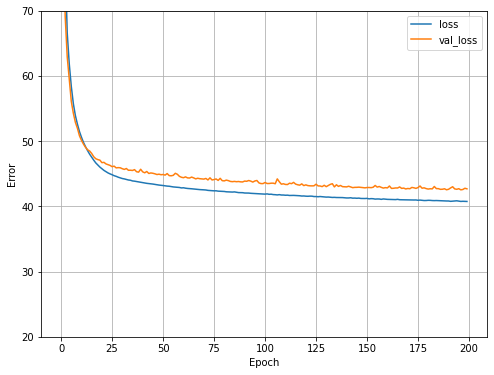

In [152]:
plot_loss(history)

In [153]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

121/121 - 0s - loss: 42.9358 - mae: 4.8555
Loss (MSE):  42.935752868652344
MAE:  4.855531692504883



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.24884188911704314
STD of Relative Errors:  0.38679759629038407
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 822 / 2435 (33.76%)
  (10%, 20%]: 632 / 2435 (25.95%)
  (20%, 30%]: 429 / 2435 (17.62%)
  > 30%: 552 / 2435 (22.67%)
--------------------------------------------



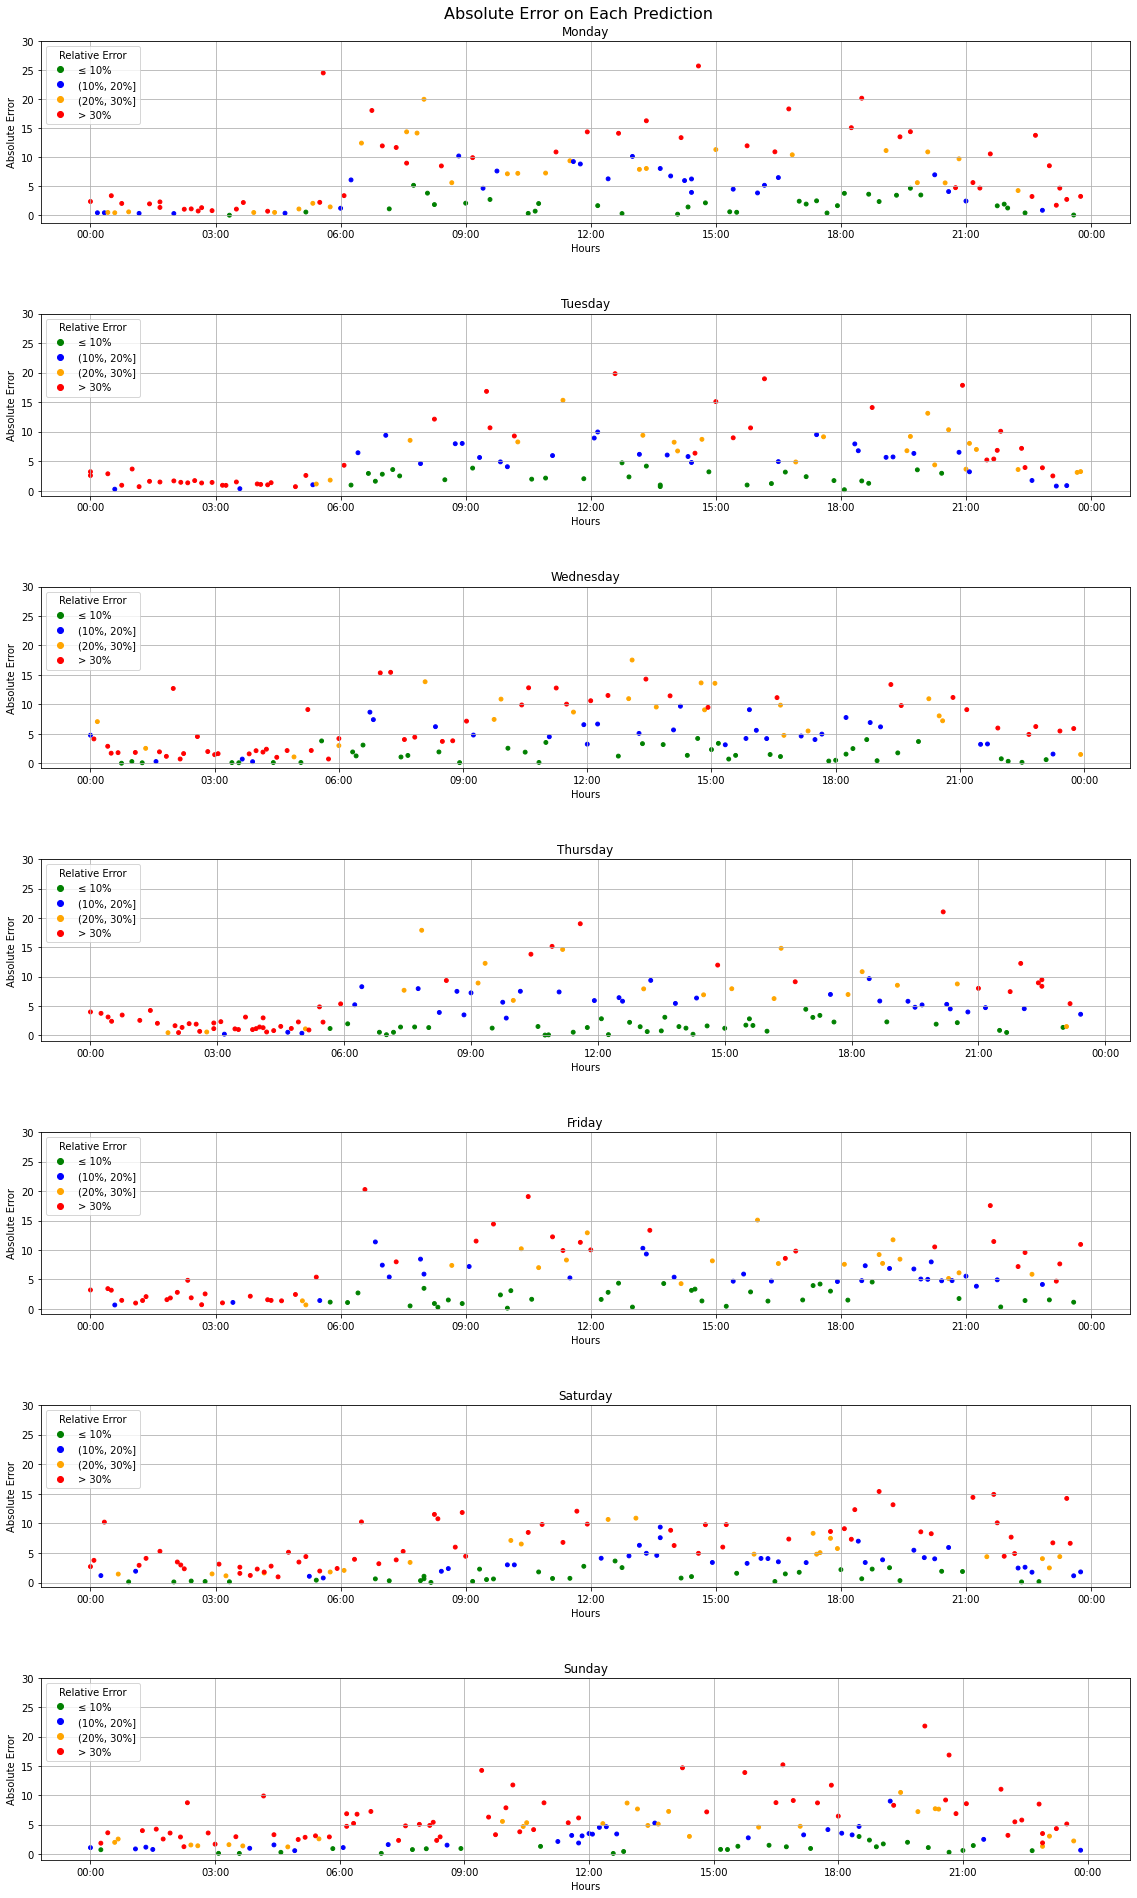

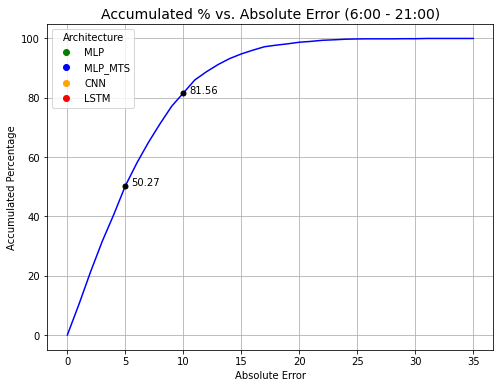

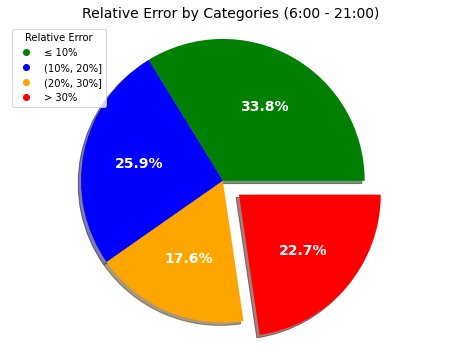

In [154]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

## Experimento #4

Tal y como se indicó en el apartado `Experimentos`, en el **Experimento #4** se tratará de predecir
el tráfico en el punto en el que se ubica el sensor `PM072` (CITIUS) en un instante `t a partir de
las mediciones realizadas en un instante `t-x` por **todos los sensores de la ciudad.**

### Análisis dataset Experimento #4

En este caso se trabaja con todo el dataset, por lo que no es necesario especificar los sensores en concreto:

In [180]:
df_4 = df

Al igual que antes, veamos algunas estadísticas sobre este conjunto:

In [181]:
df_4.describe().transpose()

count       mean        std  min  25%  50%   75%    max
car_count  2904379.0  12.220462  18.023441  0.0  0.0  4.0  19.0  806.0

Veamos un boxplot:

<AxesSubplot:>

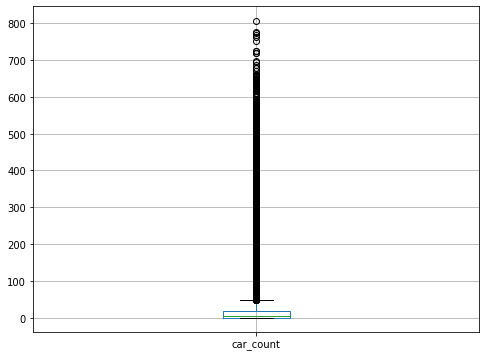

In [182]:
df_4.boxplot(column=['car_count'])

En este boxplot se puede observar que hay una gran cantidad de mediciones que superan los 100 coches en 5 minutos.
Debido a la gran cantidad de mediciones que hay (en torno a 3 millones), resulta imposible realizar un análisis gráfico
como se realizó para los experimentos anteriores.

Por lo experiencia obtenida durante los anteriores experimentos y aplicando
un poco de lógica, se descartarán todas las mediciones que superen un `car_count de 200`. Esto se debe a que en los experimentos
anteriores se pudo concluir que eran outlayers debidos a errores o fallos en el funcionamiento de los sensores. Por otra parte,
un `car_count de 200` implica un flujo de 40 coches por minuto, lo cual en una ciudad como Santiago de Compostela es bastante.
Asimismo, todos los sensores están colocados en vías urbanas en las que hay tan sólo un carril y la velocidad está limitada
a 50km/h (como máximo), por lo que aplicando un poco de sentido común, es imposible que pasen 40 coches por minuto de media.

In [183]:
df_4 = df_4.loc[df_4['car_count'] < 200]

### Preparación dataset Experimento #4

#### Label PM072

A continuación se utiliza la función para preparar el dataset para el Experimento #4:

In [184]:
# Selecciono todos los nombres de sensores (sin repetición)
sensors_list = df_4['sensor'].unique()
# PM072 será el label
sensors_list = np.delete(sensors_list,np.where(sensors_list == 'PM072'))
# Los ordeno por comodidad
sensors_list.sort()
# Preparo el dataset
df_4 = prepare_df(df_4, sensors_list, 'PM072', x = 5)

A partir de la experiencia obtenida en los anteriores experimentos, sabemos que hay sensores que nunca contaron un coche;
es decir, su columna en este nuevo dataframe es todo 0. Como estos datos no aportan nada, dichas columnas deben ser eliminadas:

In [185]:
df_4 = df_4.loc[:, (df_4 != 0).any(axis=0)]

Además, se ha podido observar que algunas columnas tan solo tienen un par de datos distintos de 0; es decir, tan
solo han realizado 2 mediciones de las 36790. Estas columnas también deben ser eliminadas

In [186]:
xx = df_4.loc[:, df_4.columns != 'datetime']
aa = xx.astype(bool).sum(axis=0)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(aa)

car_count_PM001    24427
car_count_PM002    26229
car_count_PM003     5715
car_count_PM009        2
car_count_PM010    24548
car_count_PM011    28469
car_count_PM013    33414
car_count_PM015    36005
car_count_PM016    35992
car_count_PM017    35318
car_count_PM018    36242
car_count_PM020    33905
car_count_PM021    35488
car_count_PM024    34946
car_count_PM026    35907
car_count_PM028    32930
car_count_PM029    32758
car_count_PM030    35518
car_count_PM031    34367
car_count_PM032    35830
car_count_PM035    35679
car_count_PM036    28380
car_count_PM037    30892
car_count_PM040    34305
car_count_PM043    32789
car_count_PM044    35882
car_count_PM046    34999
car_count_PM047    33620
car_count_PM048    29334
car_count_PM049    34982
car_count_PM050    34719
car_count_PM051    29358
car_count_PM052    35900
car_count_PM053    35477
car_count_PM054    34347
car_count_PM055    35031
car_count_PM056    34650
car_count_PM057    33110
car_count_PM058    34574
car_count_PM059    28354


En esta lista se puede observar que los sensores `PM009`, `PM061`, `PM074` y `PM075` solo han realizado
2 mediciones a lo largo de estos 5 meses.

In [187]:
to_drop = ['car_count_PM009', 'car_count_PM061', 'car_count_PM074', 'car_count_PM075']
df_4 = df_4.drop(to_drop, axis=1)

#### Tiempo

Para codificar el tiempo se usará la misma función previamente definida:

In [188]:
df_4 = encode_time_sin_cos(df_4)
df_4.sample()

datetime  car_count_PM001  car_count_PM002  car_count_PM003  \
25237 2020-01-14 05:30:00                0                2                0   

       car_count_PM010  car_count_PM011  car_count_PM013  car_count_PM015  \
25237                1                0                4                9   

       car_count_PM016  car_count_PM017  ...  car_count_PM078  \
25237                7                0  ...                2   

       car_count_PM079  car_count_PM082  car_count_PM083  car_count_PM084  \
25237                1                2                1                5   

       label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
25237            4  0.991445  0.130526  0.781831   0.62349  

[1 rows x 60 columns]

### Implementación Perceptrón Multicapa (MLP)

#### División del dataset, Separación y Normalización

In [189]:
#Shuffle
df_4_shuffled=df_4.sample(frac=1).reset_index(drop=True)

n = len(df_4_shuffled)
train_df_4 = df_4_shuffled[0:int(n*0.90)]
test_df_4 = df_4_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4.pop('datetime')
test_dates = test_df_4.pop('datetime')

In [190]:
train_labels = train_df_4.pop('label_PM072')
train_features = train_df_4

test_labels = test_df_4.pop('label_PM072')
test_features = test_df_4

In [191]:
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [192]:
train_features

car_count_PM001  car_count_PM002  car_count_PM003  car_count_PM010  \
0            -0.066772        -0.286253        -0.345967         2.011580   
1            -0.066772        -0.222780        -0.345967         1.049129   
2             0.345902        -0.032362        -0.345967         0.086679   
3            -0.685783        -0.476670        -0.345967        -0.875771   
4             1.377586         0.158056        -0.345967         0.086679   
...                ...              ...              ...              ...   
33106        -0.892120         0.729309        -0.345967        -0.875771   
33107         1.377586         0.411946        -0.345967        -0.394546   
33108        -0.892120        -0.540143        -0.345967        -0.875771   
33109         0.139565         0.411946        -0.345967        -0.394546   
33110        -0.685783        -0.222780        -0.345967         0.086679   

       car_count_PM011  car_count_PM013  car_count_PM015  car_count_PM016  \
0            -0.683779        -0.145677         0.365747        -0.374271   
1            -0.683779        -0.803647        -0.825933        -0.651455   
2            -0.240610        -0.218785         0.078101        -0.928639   
3            -0.462195        -1.096078        -1.072487        -1.245420   
4             0.645727         0.804724         0.324655         1.566015   
...                ...              ...              ...              ...   
33106        -0.905363        -1.169185        -1.319041        -1.285018   
33107         3.083156         0.292970         0.776672         1.051245   
33108        -0.905363        -1.242293        -1.401226        -1.126627   
33109         1.088896         1.097155         1.187596         0.892855   
33110         1.310481        -0.511216        -0.825933        -0.532662   

       car_count_PM017  car_count_PM018  ...  car_count_PM077  \
0             0.207239        -0.199086  ...         0.241323   
1            -1.155366        -0.893308  ...        -1.001631   
2            -0.288254        -0.739036  ...        -0.380154   
3            -0.783746        -0.970443  ...        -1.001631   
4             0.888542         1.420764  ...         0.614209   
...                ...              ...  ...              ...   
33106        -1.403112        -1.278986  ...        -1.250222   
33107         1.941463         0.687975  ...         1.608573   
33108        -1.155366        -1.009011  ...        -1.125926   
33109         1.507907         1.420764  ...         1.608573   
33110        -0.412127        -0.700468  ...        -0.380154   

       car_count_PM078  car_count_PM079  car_count_PM082  car_count_PM083  \
0             0.138554         0.522832        -0.203463        -0.477984   
1            -0.845984        -0.904367        -0.755646        -1.199761   
2            -0.156808        -0.048047         0.003606        -0.477984   
3            -1.141345        -1.189806        -1.100761        -1.096650   
4             0.237007         0.950992         0.762859         0.759349   
...                ...              ...              ...              ...   
33106        -1.239799        -1.332526        -1.100761        -1.199761   
33107         0.827730         2.092751         0.624813         1.790459   
33108        -1.239799        -1.332526        -1.100761        -1.199761   
33109         0.040100         1.093712         0.900905         0.965571   
33110        -0.649077        -0.618927        -0.479554        -0.168650   

       car_count_PM084  hour_sin  hour_cos  wday_sin  wday_cos  
0            -0.350243 -1.093718  0.897563 -1.084386  0.887718  
1            -1.071456  1.368286 -0.382783 -1.084386  0.887718  
2            -0.034712 -1.166711  0.798113 -1.084386  0.887718  
3            -1.161608  1.031961  0.990278 -1.084386  0.887718  
4             1.272488 -1.272607  0.610176  1.390537 -0.313499  
...                ...       ...       ...       ...       ..

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [193]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(32,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(16,kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [194]:
model = build_and_compile_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 32)                1888      
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


In [195]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 3min 46s, sys: 35.3 s, total: 4min 22s
Wall time: 2min 59s


In [196]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  37.873878  4.553423  40.029320  4.663895    195
196  37.832623  4.550811  40.423588  4.684653    196
197  37.827919  4.552768  40.090874  4.684116    197
198  37.841656  4.554375  40.054695  4.669929    198
199  37.824284  4.550828  40.168182  4.682280    199

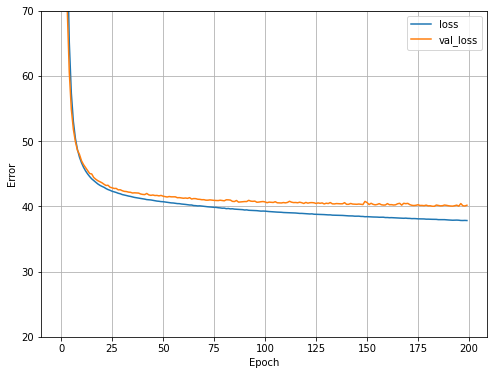

In [197]:
plot_loss(history)

In [198]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
mae

115/115 - 0s - loss: 41.6007 - mae: 4.7645


4.764492034912109


Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.2306942701798411
STD of Relative Errors:  0.3626415450168063
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 853 / 2391 (35.68%)
  (10%, 20%]: 636 / 2391 (26.6%)
  (20%, 30%]: 398 / 2391 (16.65%)
  > 30%: 504 / 2391 (21.08%)
--------------------------------------------



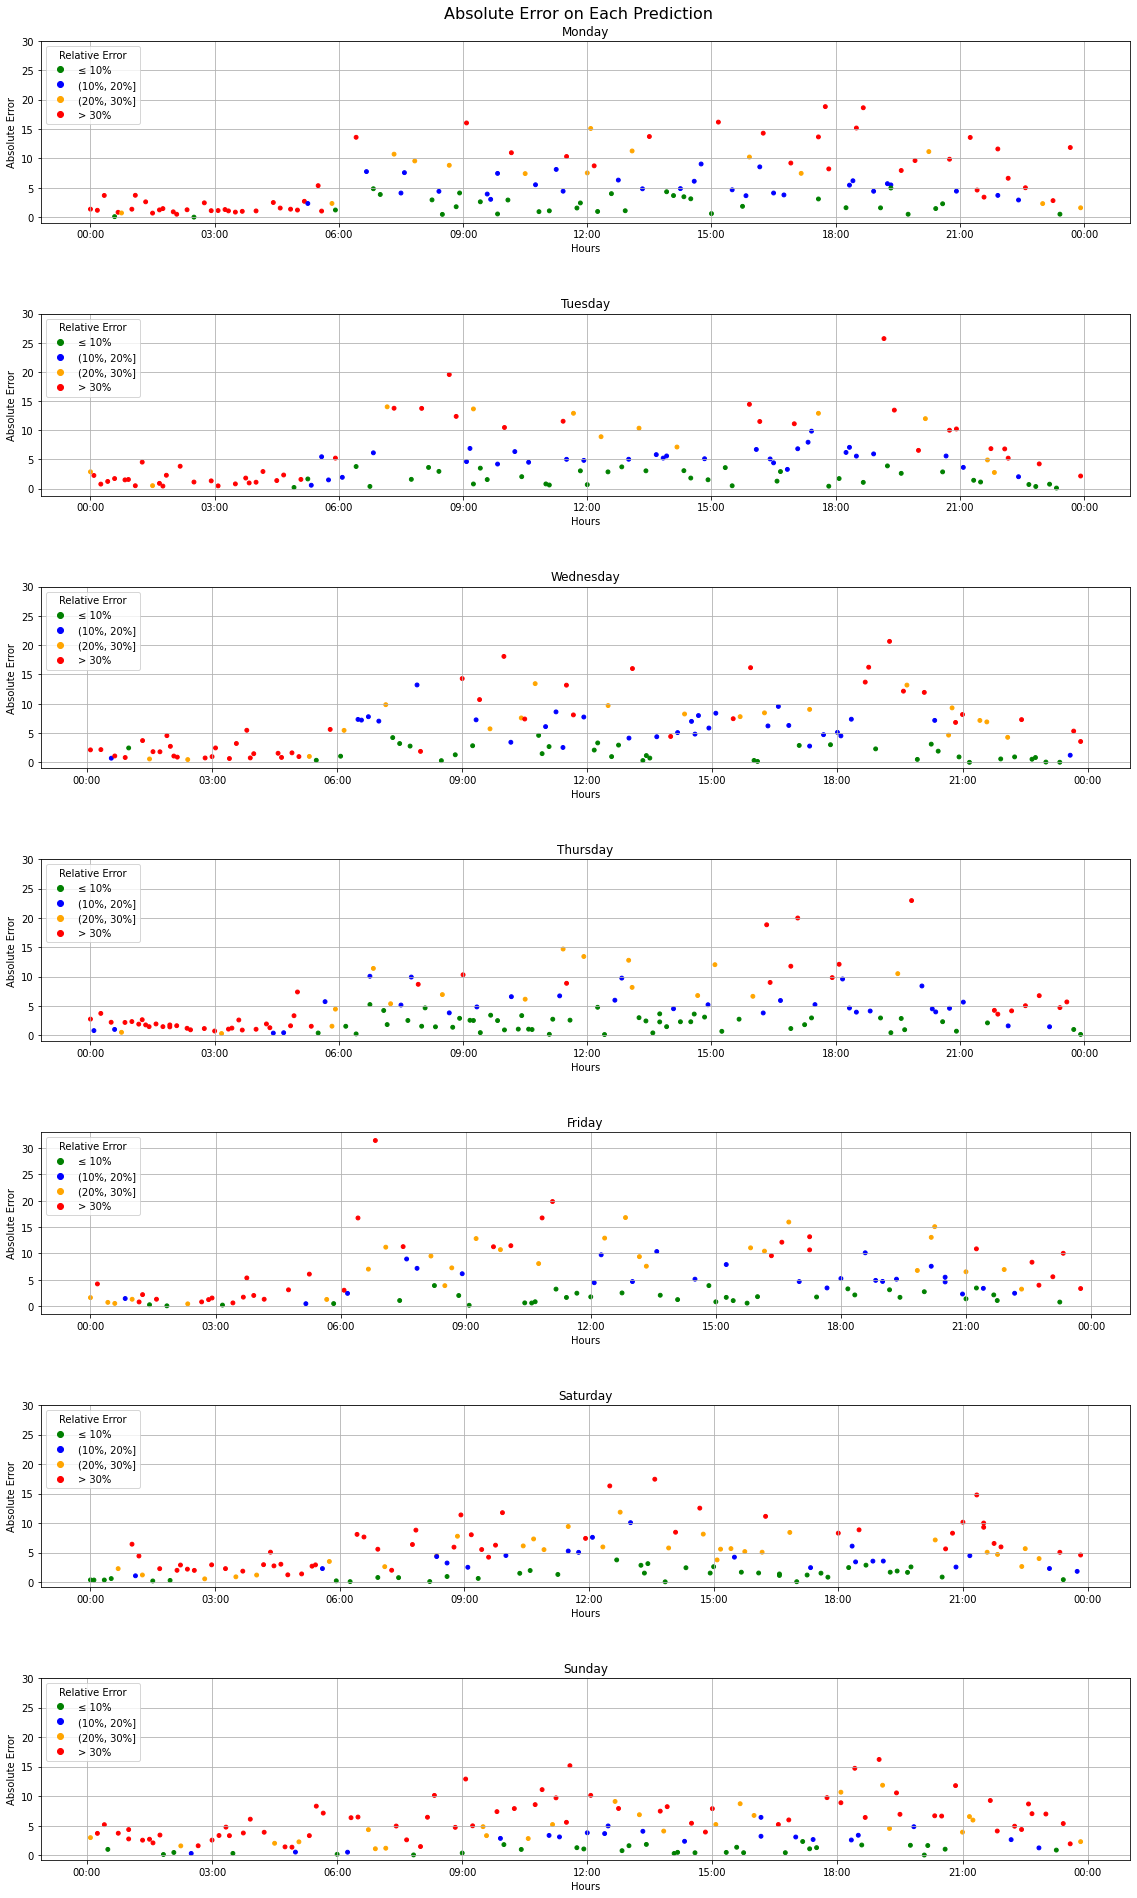

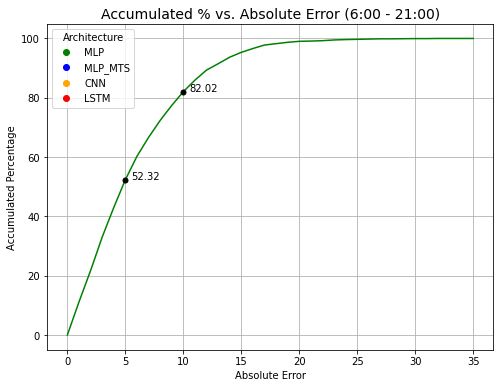

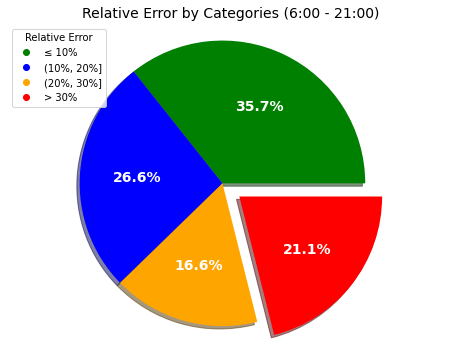

In [199]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación MLP con Múltiples Timesteps

Hasta ahora, en este `Experimento #4`, el entrenamiento para la predicción en el sensor `PM072` en el instante `t`
se realizaba con la información procedente de todos los sensores disponibles en el instante `t-5minutos`.

**Resulta interesante ver si la predicción se puede mejorar si se le proporciona a la red información de `10 y 15 minutos antes`**

Ahora mismo el dataset del `Experimento #4` tiene la siguiente forma:

In [201]:
df_4

datetime  car_count_PM001  car_count_PM002  car_count_PM003  \
0     2019-10-01 00:00:00                0                0                0   
1     2019-10-01 00:05:00                1                0                0   
2     2019-10-01 00:10:00                0                0                0   
3     2019-10-01 00:15:00                0                0                0   
4     2019-10-01 00:20:00                0                4                0   
...                   ...              ...              ...              ...   
36785 2020-02-29 06:50:00                0                0                5   
36786 2020-02-29 06:55:00                0                0                5   
36787 2020-02-29 07:00:00                0                0                2   
36788 2020-02-29 07:05:00                0                0                6   
36789 2020-02-29 07:10:00                0                0                5   

       car_count_PM010  car_count_PM011  car_count_PM013  car_count_PM015  \
0                   18                1                1                1   
1                   10                0                3                1   
2                   14                0                0                0   
3                   12                1                1                3   
4                   20                0                1                1   
...                ...              ...              ...              ...   
36785                0                2                4               13   
36786                2                0                5               12   
36787                1                0                2               14   
36788                3                1                3                9   
36789                0                0                5               16   

       car_count_PM016  car_count_PM017  ...  car_count_PM078  \
0                    4                4  ...                2   
1                    1                1  ...                0   
2                    0                1  ...                0   
3                    1                2  ...                0   
4                    0                1  ...                0   
...                ...              ...  ...              ...   
36785               15                9  ...                7   
36786               11               15  ...                3   
36787               16                5  ...                8   
36788               17               11  ...                5   
36789               13                8  ...                6   

       car_count_PM079  car_count_PM082  car_count_PM083  car_count_PM084  \
0                    0                1                1                1   
1                    1                0                0                1   
2                    0                0                0                0   
3                    0                0                1                0   
4                    1                0                1                0   
...                ...              ...              ...              ...   
36785                5                7                4                9   
36786                2                1                3                8   
36787                3                3                6                2   
36788                4                5                4                3   
36789                3                2                1                2   

       label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
0                0  0.000000  1.000000  0.781831  0.623490  
1                0  0.021815  0.999762  0.781831  0.623490  
2                0  0.043619  0.999048  0.781831  0.623490  
3                0  0.065403  0.997859  0.781831  0.623490  
4                1  0.087156  0.996195  0.781831  0.623490  
...            ...       ...       ...       ...       ... 

Utilizando la función anteriormente definida se creará el DataFrama con la información necesaria para el Experimento:

In [202]:
df_4_multi_timestep = df_4.copy(deep = True)
df_4_multi_timestep = prepare_multi_timestep_df(df_4_multi_timestep)
df_4_multi_timestep

datetime    0    1    2     3    4    5     6     7     8  \
0     2019-10-01 00:10:00  0.0  0.0  0.0  18.0  1.0  1.0   1.0   4.0   4.0   
1     2019-10-01 00:15:00  1.0  0.0  0.0  10.0  0.0  3.0   1.0   1.0   1.0   
2     2019-10-01 00:20:00  0.0  0.0  0.0  14.0  0.0  0.0   0.0   0.0   1.0   
3     2019-10-01 00:25:00  0.0  0.0  0.0  12.0  1.0  1.0   3.0   1.0   2.0   
4     2019-10-01 00:30:00  0.0  4.0  0.0  20.0  0.0  1.0   1.0   0.0   1.0   
...                   ...  ...  ...  ...   ...  ...  ...   ...   ...   ...   
35983 2020-02-29 06:50:00  0.0  0.0  1.0   1.0  1.0  3.0  12.0  13.0   3.0   
35984 2020-02-29 06:55:00  0.0  0.0  1.0   1.0  0.0  7.0   7.0  10.0   8.0   
35985 2020-02-29 07:00:00  0.0  0.0  5.0   0.0  2.0  4.0  13.0  15.0   9.0   
35986 2020-02-29 07:05:00  0.0  0.0  5.0   2.0  0.0  5.0  12.0  11.0  15.0   
35987 2020-02-29 07:10:00  0.0  0.0  2.0   1.0  0.0  2.0  14.0  16.0   5.0   

       ...  165  166  167  168  169       170       171       172       173  \
0      ...  0.0  0.0  0.0  0.0  0.0  0.043619  0.999048  0.781831  0.623490   
1      ...  0.0  0.0  0.0  1.0  0.0  0.065403  0.997859  0.781831  0.623490   
2      ...  0.0  1.0  0.0  1.0  0.0  0.087156  0.996195  0.781831  0.623490   
3      ...  0.0  0.0  0.0  2.0  0.0  0.108867  0.994056  0.781831  0.623490   
4      ...  0.0  0.0  0.0  1.0  0.0  0.130526  0.991445  0.781831  0.623490   
...    ...  ...  ...  ...  ...  ...       ...       ...       ...       ...   
35983  ...  7.0  5.0  7.0  4.0  9.0  0.976296 -0.216440 -0.974928 -0.222521   
35984  ...  3.0  2.0  1.0  3.0  8.0  0.971342 -0.237686 -0.974928 -0.222521   
35985  ...  8.0  3.0  3.0  6.0  2.0  0.965926 -0.258819 -0.974928 -0.222521   
35986  ...  5.0  4.0  5.0  4.0  3.0  0.960050 -0.279829 -0.974928 -0.222521   
35987  ...  6.0  3.0  2.0  1.0  2.0  0.953717 -0.300706 -0.974928 -0.222521   

       label_PM072  
0                0  
1                0  
2                1  
3                0  
4                2  
...            ...  
35983            3  
35984            4  
35985            6  
35986           12  
35987            3  

[35988 rows x 176 columns]

#### División, Separación y Normalización

In [203]:
# Shuffle
df_4_mts_shuffled=df_4_multi_timestep.sample(frac=1).reset_index(drop=True)

n = len(df_4_mts_shuffled)
train_df_4_mts = df_4_mts_shuffled[0:int(n*0.90)]
test_df_4_mts = df_4_mts_shuffled[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4_mts.pop('datetime')
test_dates = test_df_4_mts.pop('datetime')

In [204]:
train_labels = train_df_4_mts.pop('label_PM072')
train_features = train_df_4_mts

test_labels = test_df_4_mts.pop('label_PM072')
test_features = test_df_4_mts

In [205]:
# Esto es ESTANDARIZACIÓN
train_mean = train_features.mean()
train_std = train_features.std()

train_features = (train_features - train_mean) / train_std
test_features = (test_features - train_mean) / train_std

In [207]:
train_features

0         1         2         3         4         5         6    \
0     -0.274265  0.537245 -0.348978  0.557219  0.197428  0.434557  0.114628   
1      1.372938  0.537245 -0.348978 -0.394015  0.637881  1.166269  1.389749   
2     -0.891965 -0.607074 -0.348978 -0.869633 -0.903704 -1.248382 -1.366157   
3     -0.891965 -0.454498 -0.348978 -0.869633 -0.903704 -1.248382 -1.119359   
4     -0.891965 -0.607074 -0.348978 -0.869633 -0.683478 -1.248382 -1.201625   
...         ...       ...       ...       ...       ...       ...       ...   
32384 -0.274265 -0.378211 -0.348978  0.081602 -0.683478 -0.809355 -0.954828   
32385 -0.891965 -0.607074  2.055895  0.557219 -0.463251  0.068700  0.484825   
32386  0.343436  0.537245 -0.348978  0.081602  0.858107  1.605297  1.389749   
32387 -0.891965 -0.607074  4.310464  1.032836  0.197428  1.019927  1.924477   
32388  0.137536  0.537245 -0.348978  1.508454  0.858107  0.800413  0.772755   

            7         8         9    ...       164       165       166  \
0      0.611617  0.141087  0.375155  ...  0.235543  0.626617  0.232790   
1      2.078305  1.071241  1.147662  ...  0.235543  1.906821  0.661077   
2     -1.251474 -1.409170 -1.285733  ... -1.256343 -1.244452 -1.337593   
3     -1.092913 -1.099118 -1.169857  ... -1.256343 -1.047498 -1.052069   
4     -1.013633 -1.099118 -1.131232  ... -1.132019 -1.145975 -1.052069   
...         ...       ...       ...  ...       ...       ...       ...   
32384 -1.092913 -0.417005 -1.015356  ... -1.007695 -1.145975 -1.194831   
32385  0.413415  0.823200  1.263538  ...  0.857162  0.528139  0.946601   
32386  1.880104  0.017066  1.379414  ...  1.105810  2.202253  0.518314   
32387  0.968379  1.009230  1.456664  ...  1.478782  0.922048  1.945936   
32388  0.928739  1.319282  1.379414  ...  0.981486  0.134230  0.518314   

            167       168       169       170       171       172       173  
0      1.380737  0.653406  1.544274 -1.382548 -0.226851 -1.357840 -0.312593  
1      0.551415  0.963489  0.007998  1.097586 -0.889376 -0.595619 -1.275877  
2     -1.107228 -1.207092 -1.121617  0.824949  1.175193  1.117076  0.888601  
3     -1.107228 -1.000370 -1.076432  0.946444  1.080134 -1.085807  0.888601  
4     -1.107228 -1.103731 -1.121617  1.172815  0.828388 -1.085807  0.888601  
...         ...       ...       ...       ...       ...       ...       ...  
32384 -1.038118 -1.207092 -0.940878 -0.324228  1.390118  1.117076  0.888601  
32385  0.136754  0.446684 -0.624586  1.332678 -0.493463  1.389109 -0.312593  
32386  1.035186  1.480294  0.911689 -0.989177 -0.980208  0.626888 -1.275877  
32387  0.689636  1.170211  0.414659 -0.558042 -1.274237 -0.595619 -1.275877  
32388  0.827856  0.136601  0.369475 -0.049327 -1.392492  1.117076  0.888601  

[32389 rows x 174 columns]

#### Entrenamiento

Nótese que en la función `model.fit` se incluye la opción `validation_split=0.1`. De esta
manera se usará un `1O%` **de los datos del conjunto de entrenamiento para validación.**

In [209]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', input_shape=(len(train_features.columns),) ),
      layers.Dense(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [210]:
model = build_and_compile_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 16)                2800      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


In [211]:
%%time
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.1,
    verbose=0,
    callbacks=get_callbacks(),
    batch_size=32,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 3min 39s, sys: 33.6 s, total: 4min 12s
Wall time: 3min 2s


In [212]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  37.249546  4.519715  39.705647  4.659004    195
196  37.236763  4.518554  39.767006  4.668349    196
197  37.200745  4.516060  39.818207  4.667077    197
198  37.209328  4.516277  39.942062  4.683817    198
199  37.215591  4.520566  39.857468  4.674428    199

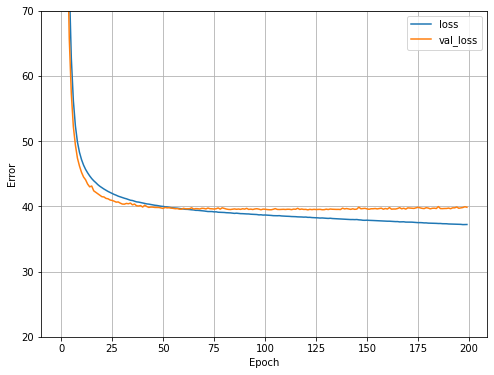

In [213]:
plot_loss(history)

In [214]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_features), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_features, test_labels, verbose=2)
print("Loss (MSE): ", loss)
print("MAE: ", mae)

113/113 - 0s - loss: 41.4156 - mae: 4.7442
Loss (MSE):  41.415557861328125
MAE:  4.744195461273193



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.248698752228164
STD of Relative Errors:  0.4010344405904333
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 742 / 2244 (33.07%)
  (10%, 20%]: 593 / 2244 (26.43%)
  (20%, 30%]: 411 / 2244 (18.32%)
  > 30%: 498 / 2244 (22.19%)
--------------------------------------------



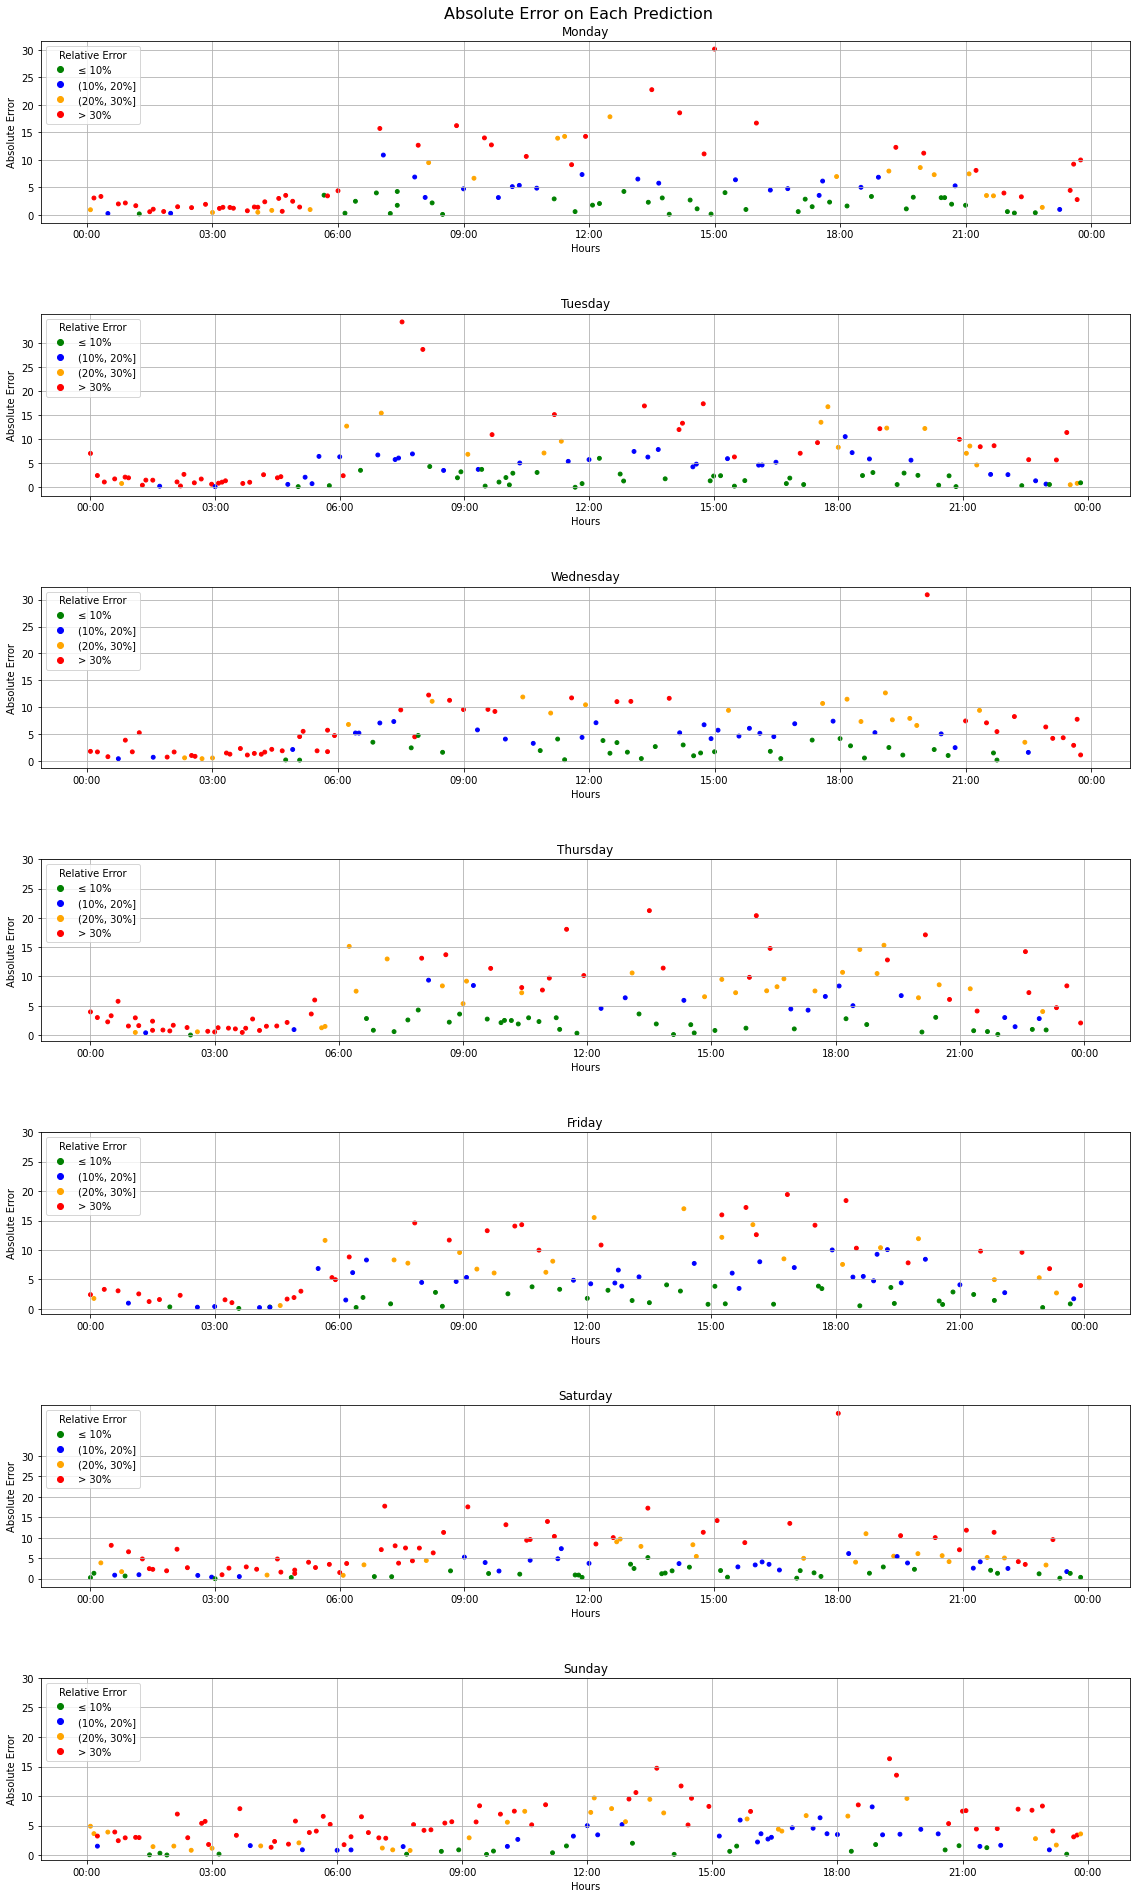

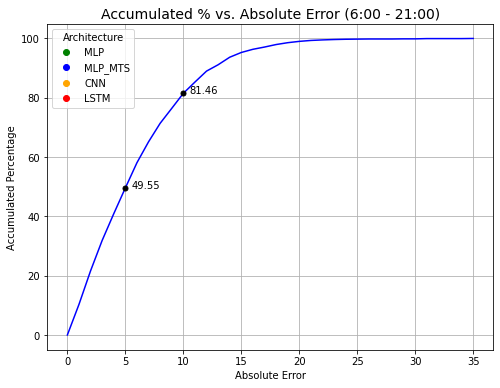

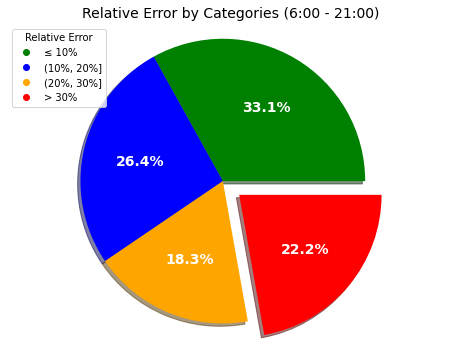

In [215]:
errors = graph_errors(test_dates, test_labels, predictions, freq = 4)

### Implementación Red Neuronal Convolucional (CNN)

Como ya se ha comentado anteriormente, las CNN se utilizan principalmente cuando se trabaja
con imágenes; sin embargo, también es posible utilizarlas para problemas de regresión con series
temporales. La CNN tendrá que aprender una función que sea capaz de mapear una secuencia de
observaciones pasadas a una determinada salida; es decir, realizará la convolución (y demás operaciones)
sobre una entrada unidimensional.

Partiendo del df creado para la experimentación con MLP:

In [217]:
df_4_cnn = df_4.copy(deep = True)
df_4.sample()

datetime  car_count_PM001  car_count_PM002  car_count_PM003  \
8864 2019-11-09 14:35:00                3               11                0   

      car_count_PM010  car_count_PM011  car_count_PM013  car_count_PM015  \
8864                1                2               15               22   

      car_count_PM016  car_count_PM017  ...  car_count_PM078  car_count_PM079  \
8864               31               25  ...               10                9   

      car_count_PM082  car_count_PM083  car_count_PM084  label_PM072  \
8864               30               13               45           14   

      hour_sin  hour_cos  wday_sin  wday_cos  
8864 -0.625923 -0.779884 -0.974928 -0.222521  

[1 rows x 60 columns]

Las CNN utilizadas cuando se trabaja con imágenes se conocen como CNN bidimensionales. En este trabajo, al tratar con
series temporales se utilizan las CNN unidimensionales, las cuales son capaces de extraer información a lo largo de
la dimensión del tiempo (por eso son 1D). Esto implica que el kernel o filtro utilizado para la convolución se desplazará
tan solo en un sentido, tal y como se muestra la Figura, a diferencia de lo que ocurre en la convolución de una imagen.
Este kernel tendrá el mismo número de columnas que características tenga el ejemplo y tantas filas como instantes temporales
deseemos utilizar.

Por todo esto la información que se le proporcione a la red debe estar ordenada cronológicamente.

In [218]:
#to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
#df_4_cnn.drop(to_drop, axis=1, inplace=True)

df_4_cnn.sort_values(by=['datetime'], ignore_index = True , inplace = True)
df_4_cnn

datetime  car_count_PM001  car_count_PM002  car_count_PM003  \
0     2019-10-01 00:00:00                0                0                0   
1     2019-10-01 00:05:00                1                0                0   
2     2019-10-01 00:10:00                0                0                0   
3     2019-10-01 00:15:00                0                0                0   
4     2019-10-01 00:20:00                0                4                0   
...                   ...              ...              ...              ...   
36785 2020-02-29 06:50:00                0                0                5   
36786 2020-02-29 06:55:00                0                0                5   
36787 2020-02-29 07:00:00                0                0                2   
36788 2020-02-29 07:05:00                0                0                6   
36789 2020-02-29 07:10:00                0                0                5   

       car_count_PM010  car_count_PM011  car_count_PM013  car_count_PM015  \
0                   18                1                1                1   
1                   10                0                3                1   
2                   14                0                0                0   
3                   12                1                1                3   
4                   20                0                1                1   
...                ...              ...              ...              ...   
36785                0                2                4               13   
36786                2                0                5               12   
36787                1                0                2               14   
36788                3                1                3                9   
36789                0                0                5               16   

       car_count_PM016  car_count_PM017  ...  car_count_PM078  \
0                    4                4  ...                2   
1                    1                1  ...                0   
2                    0                1  ...                0   
3                    1                2  ...                0   
4                    0                1  ...                0   
...                ...              ...  ...              ...   
36785               15                9  ...                7   
36786               11               15  ...                3   
36787               16                5  ...                8   
36788               17               11  ...                5   
36789               13                8  ...                6   

       car_count_PM079  car_count_PM082  car_count_PM083  car_count_PM084  \
0                    0                1                1                1   
1                    1                0                0                1   
2                    0                0                0                0   
3                    0                0                1                0   
4                    1                0                1                0   
...                ...              ...              ...              ...   
36785                5                7                4                9   
36786                2                1                3                8   
36787                3                3                6                2   
36788                4                5                4                3   
36789                3                2                1                2   

       label_PM072  hour_sin  hour_cos  wday_sin  wday_cos  
0                0  0.000000  1.000000  0.781831  0.623490  
1                0  0.021815  0.999762  0.781831  0.623490  
2                0  0.043619  0.999048  0.781831  0.623490  
3                0  0.065403  0.997859  0.781831  0.623490  
4                1  0.087156  0.996195  0.781831  0.623490  
...            ...       ...       ...       ...       ... 

#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [219]:
n = len(df_4_cnn)
train_df_4_cnn = df_4_cnn[0:int(n*0.90)]
test_df_4_cnn = df_4_cnn[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4_cnn.pop('datetime')
test_dates = test_df_4_cnn.pop('datetime')

In [220]:
train_labels = train_df_4_cnn.pop('label_PM072')
train_features = train_df_4_cnn

test_labels = test_df_4_cnn.pop('label_PM072')
test_features = test_df_4_cnn

In [221]:
# Esto es ESTANDARIZACIÓN
#train_mean = train_features.mean()
#train_std = train_features.std()

#train_features = (train_features - train_mean) / train_std
#test_features = (test_features - train_mean) / train_std

In [222]:
# Esto es NORMALIZACION

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(train_features)

# Apply the scaler to training data
train_features = input_scaler.transform(train_features)

# Apply the scaler to test data
test_features = input_scaler.transform(test_features)

##### Entrada CNN

Ahora es el momento en el que se crearán los ejemplos con los instantes temporales, pero antes se debe tener en cuenta que,
al igual que se ha visto en la sección `Implementación MLP con Múltiples Timesteps`, el dataset no presenta TODAS las mediciones.
Cada entrada tendrá la información de los instantes `t-15, t-10 y t-5` y la salida será el valor medido por `PM072`
en el instante `t`. Para ello, es necesario seleccionar solo aquellas filas para las que hay dos mediciones en los dos
instantes temporales posteriores. **Esas mediciones en esos 3 instantes será la entrada del modelo.**

(La fecha almacenada corresponde al último timestep de cada ejemplo; es decir, `t-5`)

In [223]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features

0         1         2         3         4         5         6   \
0      0.000000  0.000000  0.000000  0.439024  0.011364  0.014706  0.007407   
1      0.013699  0.000000  0.000000  0.243902  0.000000  0.044118  0.007407   
2      0.000000  0.000000  0.000000  0.341463  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.292683  0.011364  0.014706  0.022222   
4      0.000000  0.020101  0.000000  0.487805  0.000000  0.014706  0.007407   
...         ...       ...       ...       ...       ...       ...       ...   
33106  0.000000  0.000000  0.040816  0.048780  0.000000  0.029412  0.066667   
33107  0.000000  0.000000  0.061224  0.000000  0.068182  0.073529  0.096296   
33108  0.000000  0.000000  0.040816  0.000000  0.011364  0.073529  0.081481   
33109  0.000000  0.000000  0.040816  0.000000  0.022727  0.029412  0.125926   
33110  0.000000  0.000000  0.061224  0.000000  0.034091  0.029412  0.037037   

             7         8         9   ...        48      49        50  \
0      0.029412  0.045977  0.028777  ...  0.018182  0.0250  0.000000   
1      0.007353  0.011494  0.007194  ...  0.000000  0.0000  0.028571   
2      0.000000  0.011494  0.007194  ...  0.000000  0.0000  0.000000   
3      0.007353  0.022989  0.007194  ...  0.000000  0.0000  0.000000   
4      0.000000  0.011494  0.007194  ...  0.000000  0.0000  0.028571   
...         ...       ...       ...  ...       ...     ...       ...   
33106  0.029412  0.034483  0.028777  ...  0.000000  0.0250  0.000000   
33107  0.066176  0.068966  0.028777  ...  0.000000  0.0500  0.114286   
33108  0.066176  0.068966  0.043165  ...  0.018182  0.0625  0.085714   
33109  0.014706  0.034483  0.028777  ...  0.018182  0.0250  0.057143   
33110  0.066176  0.034483  0.050360  ...  0.036364  0.0250  0.057143   

             51        52        53        54        55        56        57  
0      0.014085  0.017857  0.009524  0.500000  1.000000  0.900969  0.801938  
1      0.000000  0.000000  0.009524  0.510907  0.999881  0.900969  0.801938  
2      0.000000  0.000000  0.000000  0.521810  0.999524  0.900969  0.801938  
3      0.000000  0.017857  0.000000  0.532702  0.998929  0.900969  0.801938  
4      0.000000  0.017857  0.000000  0.543578  0.998097  0.900969  0.801938  
...         ...       ...       ...       ...       ...       ...       ...  
33106  0.014085  0.017857  0.000000  0.997028  0.445567  0.099031  0.801938  
33107  0.000000  0.035714  0.019048  0.995722  0.434737  0.099031  0.801938  
33108  0.000000  0.035714  0.009524  0.994181  0.423938  0.099031  0.801938  
33109  0.014085  0.000000  0.019048  0.992404  0.413176  0.099031  0.801938  
33110  0.014085  0.017857  0.019048  0.990393  0.402455  0.099031  0.801938  

[33111 rows x 58 columns]

In [224]:
train_labels

0         0
1         0
2         0
3         0
4         1
         ..
33106    21
33107    15
33108    18
33109    18
33110    12
Name: label_PM072, Length: 33111, dtype: int64

In [225]:
def create_CNN_data(input, output, dates):

    # Necesario el reset para acceder por index
    input.reset_index(inplace=True, drop=True)
    output.reset_index(inplace=True, drop=True)
    dates.reset_index(inplace=True, drop=True)

    # Mediciones para las que hay dos mediciones posteriores
    correct_dates_index  = []
    for i in range(len(dates)-2):
        if( (dates[i+1]-dates[i] == datetime.timedelta(minutes=5)) & (dates[i+2]-dates[i] == datetime.timedelta(minutes=10)) ):
            correct_dates_index.append(i)

    Xs, ys, dts = [], [], []
    for i in correct_dates_index:
        v = input.iloc[i:i+3].to_numpy() # Recupera 3 filas
        Xs.append(v)
        ys.append(output[i+2])
        dts.append(dates[i+2])

    return np.array(Xs), np.array(ys), np.array(dts)

In [226]:
train_inputs, train_outputs, train_dates = create_CNN_data(train_features, train_labels, train_dates)
test_inputs, test_outputs, test_dates = create_CNN_data(test_features, test_labels, test_dates)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

train_inputs.shape:  (32362, 3, 58)
train_outputs.shape:  (32362,)
test_inputs.shape:  (3624, 3, 58)
test_outputs.shape:  (3624,)


In [227]:
train_inputs

array([[[0.        , 0.        , 0.        , ..., 1.        ,
         0.90096887, 0.80193774],
        [0.01369863, 0.        , 0.        , ..., 0.99988101,
         0.90096887, 0.80193774],
        [0.        , 0.        , 0.        , ..., 0.99952411,
         0.90096887, 0.80193774]],

       [[0.01369863, 0.        , 0.        , ..., 0.99988101,
         0.90096887, 0.80193774],
        [0.        , 0.        , 0.        , ..., 0.99952411,
         0.90096887, 0.80193774],
        [0.        , 0.        , 0.        , ..., 0.99892946,
         0.90096887, 0.80193774]],

       [[0.        , 0.        , 0.        , ..., 0.99952411,
         0.90096887, 0.80193774],
        [0.        , 0.        , 0.        , ..., 0.99892946,
         0.90096887, 0.80193774],
        [0.        , 0.0201005 , 0.        , ..., 0.99809735,
         0.90096887, 0.80193774]],

       ...,

       [[0.        , 0.        , 0.04081633, ..., 0.44556656,
         0.09903113, 0.80193774],
        [0.        , 

In [228]:
train_outputs

array([ 0,  0,  1, ..., 18, 18, 12])

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el último instante temporal.

#### Entrenamiento

In [229]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.Conv1D(filters=128,
                     kernel_size=3,  activation='relu',
                     input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.MaxPooling1D(pool_size=1),
      layers.Flatten(),
      layers.Dense(20, activation='relu'),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model


In [230]:
model = build_and_compile_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 128)            22400     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 20)                2580      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 21        
Total params: 25,001
Trainable params: 25,001
Non-trainable params: 0
_________________________________________________________________


In [231]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    shuffle = False,
    callbacks=get_callbacks(),
    batch_size=64,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 2min 50s, sys: 20.9 s, total: 3min 10s
Wall time: 2min 40s


In [232]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  37.630943  4.537769  40.673664  4.678740    195
196  37.617439  4.536980  40.675552  4.679008    196
197  37.604591  4.536315  40.676937  4.679380    197
198  37.592136  4.535591  40.675243  4.679173    198
199  37.582069  4.534992  40.677452  4.679208    199

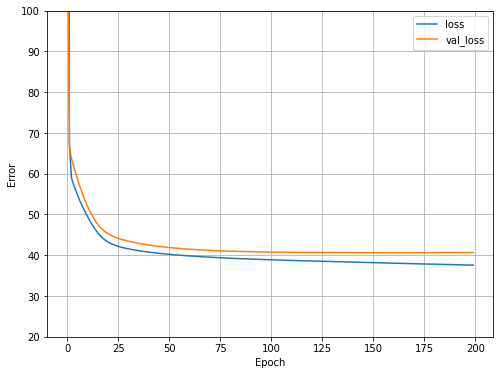

In [233]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [234]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

114/114 - 0s - loss: 38.7287 - mae: 4.5886
Loss (MSE):  38.72865676879883
MAE:  4.588598728179932



Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.24066319895968794
STD of Relative Errors:  0.3935616303123516
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 804 / 2307 (34.85%)
  (10%, 20%]: 618 / 2307 (26.79%)
  (20%, 30%]: 394 / 2307 (17.08%)
  > 30%: 491 / 2307 (21.28%)
--------------------------------------------



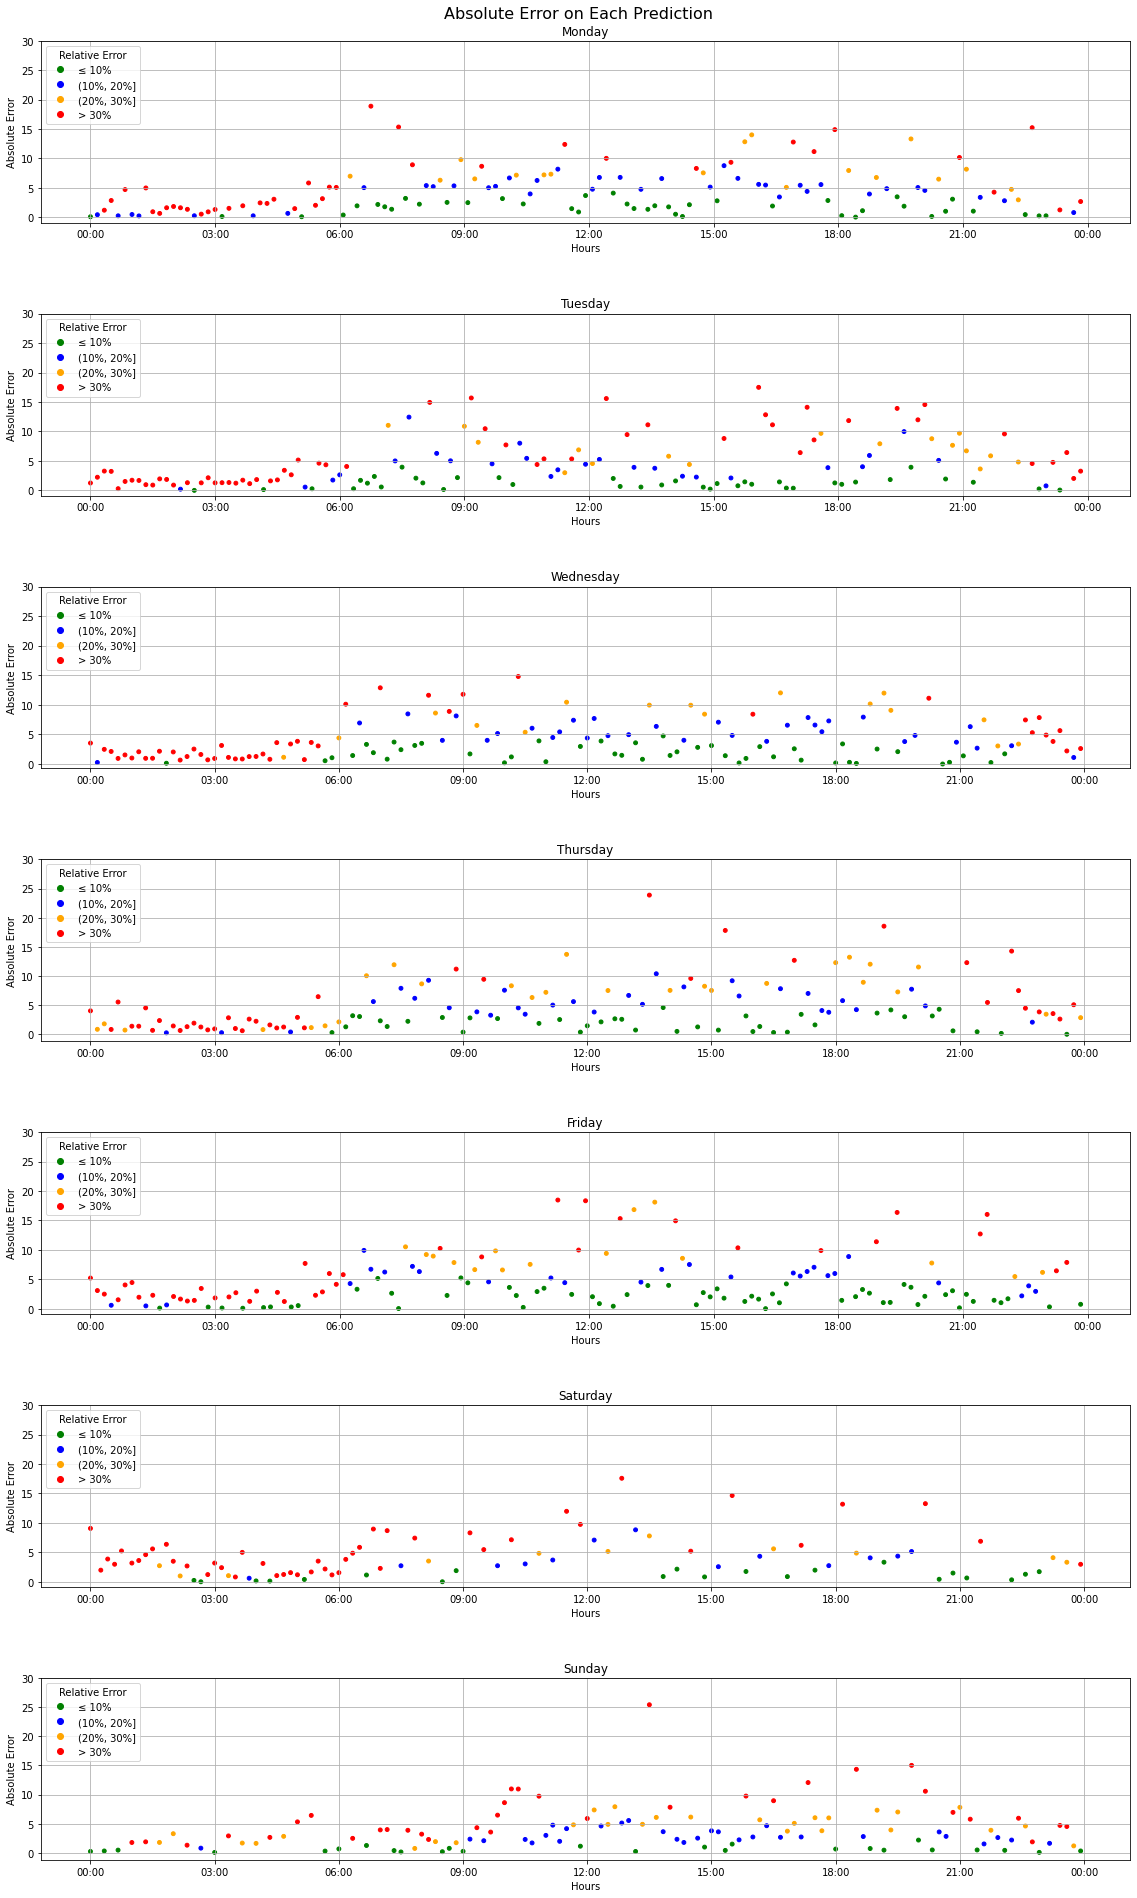

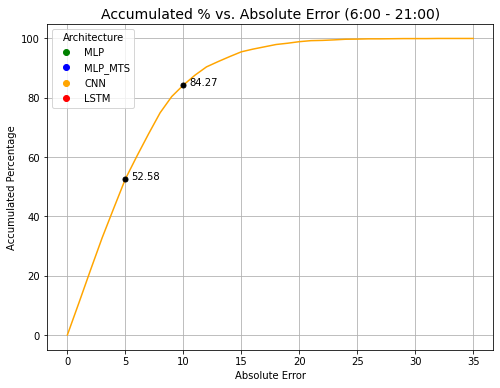

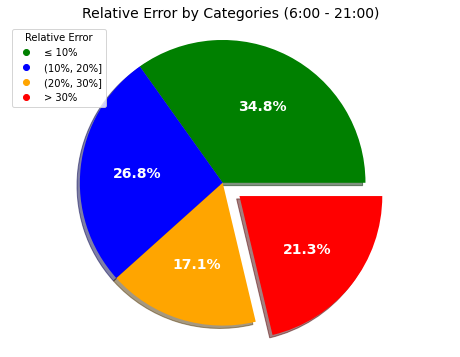

In [235]:
errors = graph_errors(pd.DataFrame(test_dates, columns= ['datetime']), pd.DataFrame(test_outputs,  columns= ['label_PM072']), predictions, freq = 4)

### Implementación RNN

#### Implementación LSTM

En esta sección se tratará la implementación del modelo con LSTM.

Ahora mismo el dataset para el `Experimento #4` tiene las siguientes características:

In [249]:
df_4_rnn = df_4.copy(deep = True)
df_4.sample()

datetime  car_count_PM001  car_count_PM002  car_count_PM003  \
8274 2019-11-07 08:10:00               18               16                0   

      car_count_PM010  car_count_PM011  car_count_PM013  car_count_PM015  \
8274                2                7               34               62   

      car_count_PM016  car_count_PM017  ...  car_count_PM078  car_count_PM079  \
8274               86               37  ...               42               17   

      car_count_PM082  car_count_PM083  car_count_PM084  label_PM072  \
8274               12               37               19           43   

      hour_sin  hour_cos  wday_sin  wday_cos  
8274  0.843391   -0.5373  0.433884 -0.900969  

[1 rows x 60 columns]

Tal y como se ha comentado en `Definición RNN`, este tipo de arquitectura es capaz
de modelar el tiempo de forma explícita, por lo que ya *no es necesario* que se introduzca
la información temporal:

In [250]:
to_drop = ['wday_sin', 'wday_cos', 'hour_sin', 'hour_cos']
df_4_rnn.drop(to_drop, axis=1, inplace=True)

Por otra parte, para que la red pueda modelar el tiempo de manera correcta, es necesario
que los datos que reciba estén ordenados temporalmente; es decir, por el campo `datetime`:

In [251]:
df_4_rnn.sort_values(by=['datetime'], ignore_index = True , inplace = True)
df_4_rnn

datetime  car_count_PM001  car_count_PM002  car_count_PM003  \
0     2019-10-01 00:00:00                0                0                0   
1     2019-10-01 00:05:00                1                0                0   
2     2019-10-01 00:10:00                0                0                0   
3     2019-10-01 00:15:00                0                0                0   
4     2019-10-01 00:20:00                0                4                0   
...                   ...              ...              ...              ...   
36785 2020-02-29 06:50:00                0                0                5   
36786 2020-02-29 06:55:00                0                0                5   
36787 2020-02-29 07:00:00                0                0                2   
36788 2020-02-29 07:05:00                0                0                6   
36789 2020-02-29 07:10:00                0                0                5   

       car_count_PM010  car_count_PM011  car_count_PM013  car_count_PM015  \
0                   18                1                1                1   
1                   10                0                3                1   
2                   14                0                0                0   
3                   12                1                1                3   
4                   20                0                1                1   
...                ...              ...              ...              ...   
36785                0                2                4               13   
36786                2                0                5               12   
36787                1                0                2               14   
36788                3                1                3                9   
36789                0                0                5               16   

       car_count_PM016  car_count_PM017  ...  car_count_PM067  \
0                    4                4  ...                0   
1                    1                1  ...                0   
2                    0                1  ...                1   
3                    1                2  ...                0   
4                    0                1  ...                0   
...                ...              ...  ...              ...   
36785               15                9  ...                6   
36786               11               15  ...                0   
36787               16                5  ...                4   
36788               17               11  ...                4   
36789               13                8  ...                3   

       car_count_PM073  car_count_PM076  car_count_PM077  car_count_PM078  \
0                    3                2                1                2   
1                    0                2                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    2                1                0                0   
...                ...              ...              ...              ...   
36785                8                4                3                7   
36786               13                6                2                3   
36787                9                3                4                8   
36788               12                4                2                5   
36789               10                6                3                6   

       car_count_PM079  car_count_PM082  car_count_PM083  car_count_PM084  \
0                    0                1                1                1   
1                    1                0                0                1   
2                    0                0                0                0   
3                    0                0                1                0   
4                    1                0 

#### División del dataset, Separación y Normalización

Cabe destacar que ahora, al utilizar una RNN (LSTM) NO se debe hacer el shuffle que
se hizo previamente al trabajar con el MLP.

In [252]:
n = len(df_4_rnn)
train_df_4_rnn = df_4_rnn[0:int(n*0.90)]
test_df_4_rnn = df_4_rnn[int(n*0.90):]

# Guardo las columnas del datetime para ambos conjuntos
train_dates = train_df_4_rnn.pop('datetime')
test_dates = test_df_4_rnn.pop('datetime')

In [253]:
train_labels = train_df_4_rnn.pop('label_PM072')
train_features = train_df_4_rnn

test_labels = test_df_4_rnn.pop('label_PM072')
test_features = test_df_4_rnn

In [254]:
# Esto es ESTANDARIZACIÓN
#train_mean = train_features.mean()
#train_std = train_features.std()

#train_features = (train_features - train_mean) / train_std
#test_features = (test_features - train_mean) / train_std

In [255]:
# Esto es NORMALIZACION

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(train_features)

# Apply the scaler to training data
train_features = input_scaler.transform(train_features)

# Apply the scaler to test data
test_features = input_scaler.transform(test_features)

##### Entrada celda LSTM

Ahora que se ha realizado todo el proceso anterior, ya es posible crear la entrada 3D. Pero antes, se debe tener en cuenta que,
al igual que se ha visto en la sección `Implementación MLP con Múltiples Timesteps`, el dataset no presenta TODAS las mediciones.

El modelo debe recibir la información de los instantes `t-15, t-10 y t-5` y la salida será el valor medido por `PM072`
en el instante `t`. Para ello, es necesario seleccionar solo aquellas filas para las que hay dos mediciones en los dos
instantes temporales posteriores. **Esas mediciones en esos 3 instantes será la entrada 3D del modelo.**

(La fecha almacenada corresponde al último timestep de cada ejemplo; es decir, `t-5`)

In [256]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features

0         1         2         3         4         5         6   \
0      0.000000  0.000000  0.000000  0.439024  0.011364  0.014706  0.007407   
1      0.013699  0.000000  0.000000  0.243902  0.000000  0.044118  0.007407   
2      0.000000  0.000000  0.000000  0.341463  0.000000  0.000000  0.000000   
3      0.000000  0.000000  0.000000  0.292683  0.011364  0.014706  0.022222   
4      0.000000  0.020101  0.000000  0.487805  0.000000  0.014706  0.007407   
...         ...       ...       ...       ...       ...       ...       ...   
33106  0.000000  0.000000  0.040816  0.048780  0.000000  0.029412  0.066667   
33107  0.000000  0.000000  0.061224  0.000000  0.068182  0.073529  0.096296   
33108  0.000000  0.000000  0.040816  0.000000  0.011364  0.073529  0.081481   
33109  0.000000  0.000000  0.040816  0.000000  0.022727  0.029412  0.125926   
33110  0.000000  0.000000  0.061224  0.000000  0.034091  0.029412  0.037037   

             7         8         9   ...        44        45        46  \
0      0.029412  0.045977  0.028777  ...  0.000000  0.000000  0.025424   
1      0.007353  0.011494  0.007194  ...  0.000000  0.000000  0.000000   
2      0.000000  0.011494  0.007194  ...  0.000000  0.008850  0.000000   
3      0.007353  0.022989  0.007194  ...  0.000000  0.000000  0.000000   
4      0.000000  0.011494  0.007194  ...  0.000000  0.000000  0.016949   
...         ...       ...       ...  ...       ...       ...       ...   
33106  0.029412  0.034483  0.028777  ...  0.000000  0.000000  0.042373   
33107  0.066176  0.068966  0.028777  ...  0.000000  0.000000  0.042373   
33108  0.066176  0.068966  0.043165  ...  0.000000  0.000000  0.050847   
33109  0.014706  0.034483  0.028777  ...  0.005917  0.000000  0.016949   
33110  0.066176  0.034483  0.050360  ...  0.005917  0.150442  0.084746   

             47        48      49        50        51        52        53  
0      0.033898  0.018182  0.0250  0.000000  0.014085  0.017857  0.009524  
1      0.033898  0.000000  0.0000  0.028571  0.000000  0.000000  0.009524  
2      0.000000  0.000000  0.0000  0.000000  0.000000  0.000000  0.000000  
3      0.000000  0.000000  0.0000  0.000000  0.000000  0.017857  0.000000  
4      0.016949  0.000000  0.0000  0.028571  0.000000  0.017857  0.000000  
...         ...       ...     ...       ...       ...       ...       ...  
33106  0.050847  0.000000  0.0250  0.000000  0.014085  0.017857  0.000000  
33107  0.050847  0.000000  0.0500  0.114286  0.000000  0.035714  0.019048  
33108  0.067797  0.018182  0.0625  0.085714  0.000000  0.035714  0.009524  
33109  0.101695  0.018182  0.0250  0.057143  0.014085  0.000000  0.019048  
33110  0.067797  0.036364  0.0250  0.057143  0.014085  0.017857  0.019048  

[33111 rows x 54 columns]

In [257]:
train_labels

0         0
1         0
2         0
3         0
4         1
         ..
33106    21
33107    15
33108    18
33109    18
33110    12
Name: label_PM072, Length: 33111, dtype: int64

In [258]:
train_inputs, train_outputs, train_dates = create_LSTM_data(train_features, train_labels, train_dates)
test_inputs, test_outputs, test_dates = create_LSTM_data(test_features, test_labels, test_dates)

print('train_inputs.shape: ', train_inputs.shape)
print('train_outputs.shape: ', train_outputs.shape)
print('test_inputs.shape: ', test_inputs.shape)
print('test_outputs.shape: ', test_outputs.shape)

train_inputs.shape:  (32362, 3, 54)
train_outputs.shape:  (32362,)
test_inputs.shape:  (3624, 3, 54)
test_outputs.shape:  (3624,)


In [259]:
train_inputs

array([[[0.        , 0.        , 0.        , ..., 0.01408451,
         0.01785714, 0.00952381],
        [0.01369863, 0.        , 0.        , ..., 0.        ,
         0.        , 0.00952381],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.01369863, 0.        , 0.        , ..., 0.        ,
         0.        , 0.00952381],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.01785714, 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.01785714, 0.        ],
        [0.        , 0.0201005 , 0.        , ..., 0.        ,
         0.01785714, 0.        ]],

       ...,

       [[0.        , 0.        , 0.04081633, ..., 0.01408451,
         0.01785714, 0.        ],
        [0.        , 

In [260]:
train_outputs

array([ 0,  0,  1, ..., 18, 18, 12])

Como se puede observar, cada ejemplo tiene las mediciones correspondientes a `3 instantes temporales` y tiene
asociada la medición realizada por el sensor `PM072` en el instante `t`.

#### Entrenamiento

In [261]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 25 == 0: print('\n')
    print('.', end='')

def get_callbacks():
    return [
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
        PrintDot()
    ]

def build_and_compile_model():
  model = tf.keras.Sequential([
      layers.LSTM(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=True,
                   input_shape=(train_inputs.shape[1], train_inputs.shape[2]) ),
      layers.LSTM(8, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=True ),
      layers.LSTM(16, kernel_regularizer=regularizers.l2(0.0001),
                   activation='relu', return_sequences=False ),
      layers.Dense(1)
  ])

#kernel_regularizer=regularizers.l2(0.0001),
#layers.Dropout(0.2),

  model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=['mae']
  )

  return model

In [262]:
model = build_and_compile_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 16)             4544      
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 8)              800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 17        
Total params: 6,961
Trainable params: 6,961
Non-trainable params: 0
_________________________________________________________________


¡Se indica la opción `shuffle = False` para que no haga un shuffle del conjunto de entrenamiento antes de cada época!
De esta manera se asegura que la información se introduce en orden cronológico

In [263]:
%%time
history = model.fit(
    train_inputs,
    train_outputs,
    validation_split=0.1,
    verbose=0,
    shuffle = False,
    callbacks=get_callbacks(),
    batch_size=64,
    epochs=200
)



.........................

.........................

.........................

.........................

.........................

.........................

.........................

.........................CPU times: user 11min 46s, sys: 1min 29s, total: 13min 16s
Wall time: 6min 59s


In [264]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

loss       mae   val_loss   val_mae  epoch
195  39.425480  4.633107  40.795441  4.684593    195
196  39.418900  4.632667  40.787666  4.684390    196
197  39.413986  4.632421  40.789455  4.684581    197
198  39.407619  4.631979  40.786556  4.684407    198
199  39.402710  4.631713  40.785759  4.684418    199

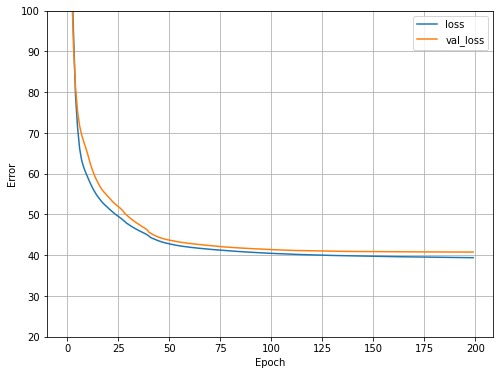

In [265]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([20, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [266]:
# Se guardan las predicciones en un df
predictions = pd.DataFrame(model.predict(test_inputs), columns = ['prediction'])

# Evaluar el modelo para el conjunto de test
loss, mae = model.evaluate(test_inputs, test_outputs, verbose=2)
print('Loss (MSE): ', loss)
print('MAE: ', mae)

114/114 - 0s - loss: 38.9339 - mae: 4.5883
Loss (MSE):  38.93387222290039
MAE:  4.588343143463135


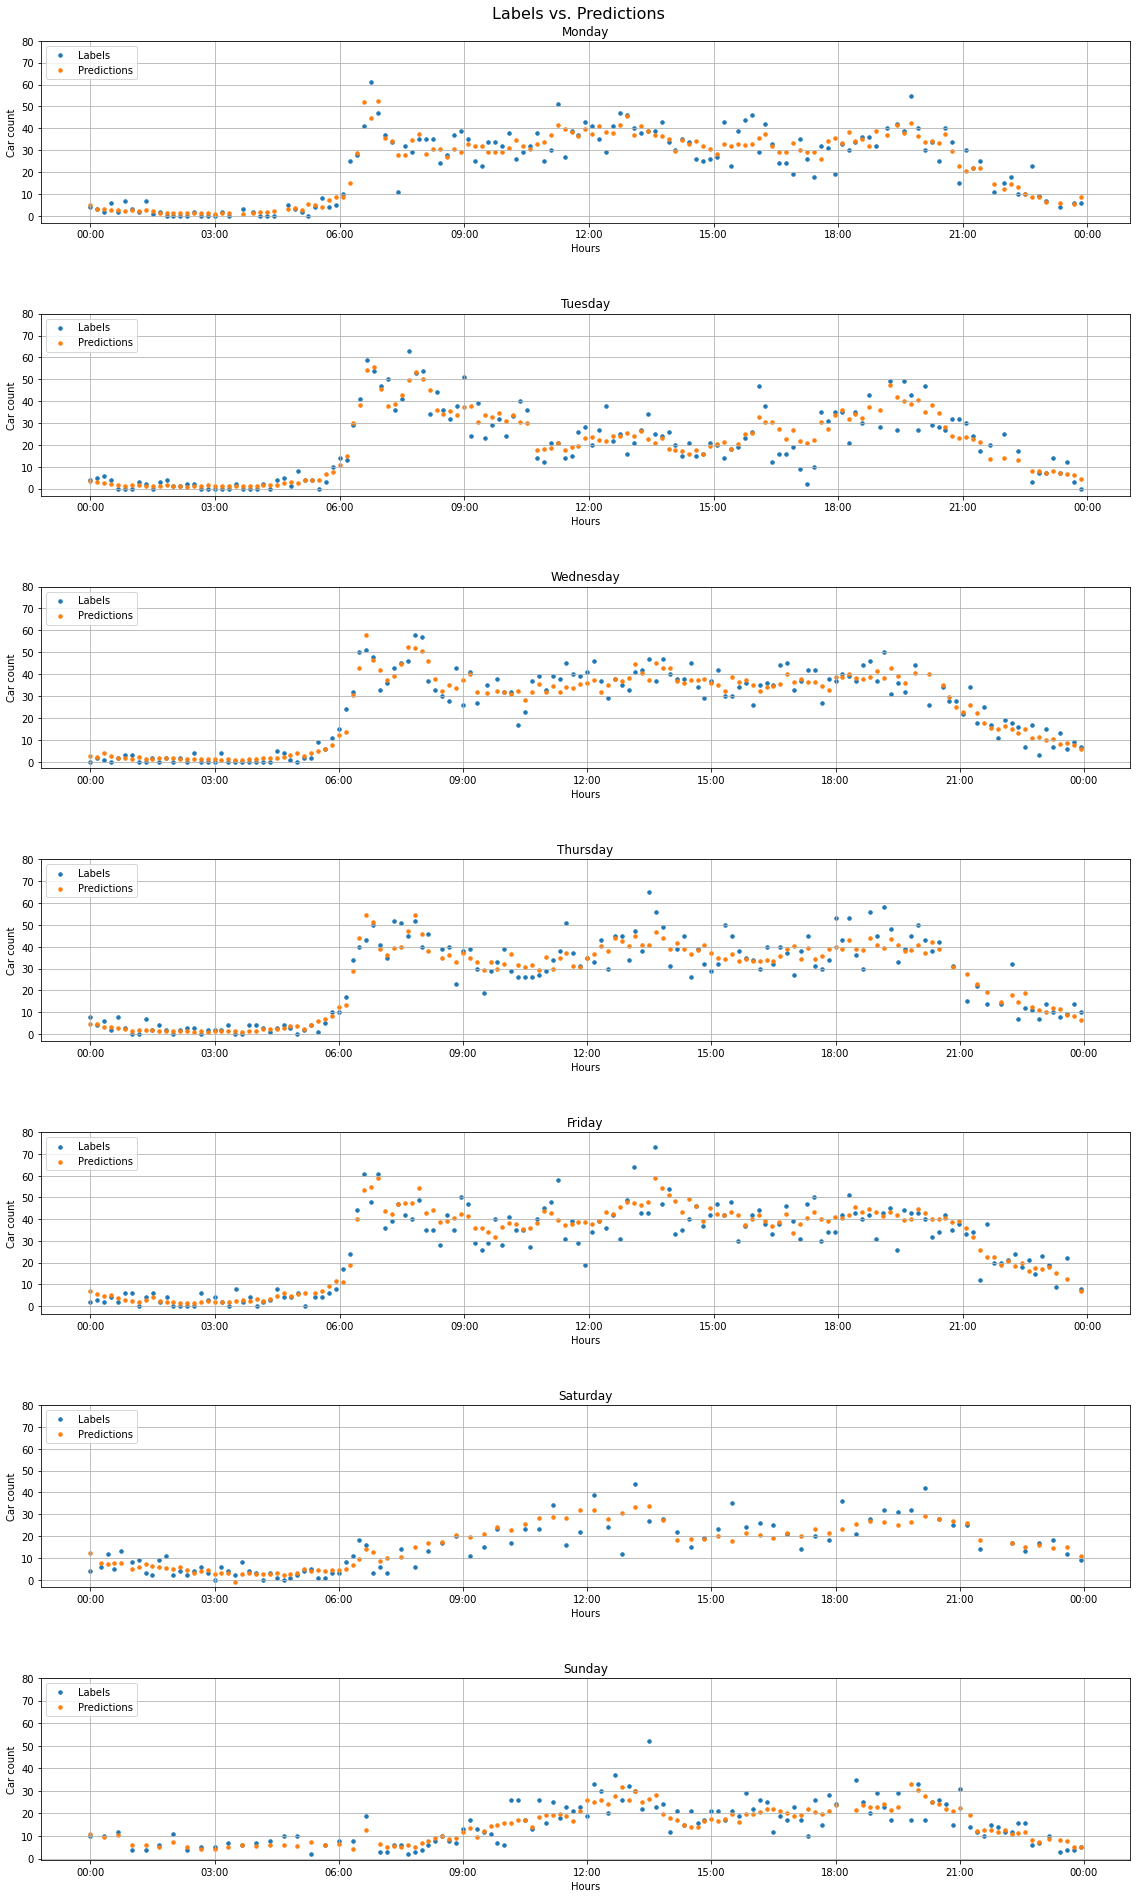

In [267]:
check_values = graph_predictions(pd.DataFrame(test_dates, columns= ['datetime']), pd.DataFrame(test_outputs,  columns= ['label_PM072']), predictions, freq = 4)


Calculations using data from 6:00 to 21:00
--------------------------------------------
Mean of Relative Errors:  0.2440528825314261
STD of Relative Errors:  0.4115815779334143
--------------------------------------------
Predictions belonging to each category:
  ≤ 10%: 811 / 2307 (35.15%)
  (10%, 20%]: 609 / 2307 (26.4%)
  (20%, 30%]: 373 / 2307 (16.17%)
  > 30%: 514 / 2307 (22.28%)
--------------------------------------------



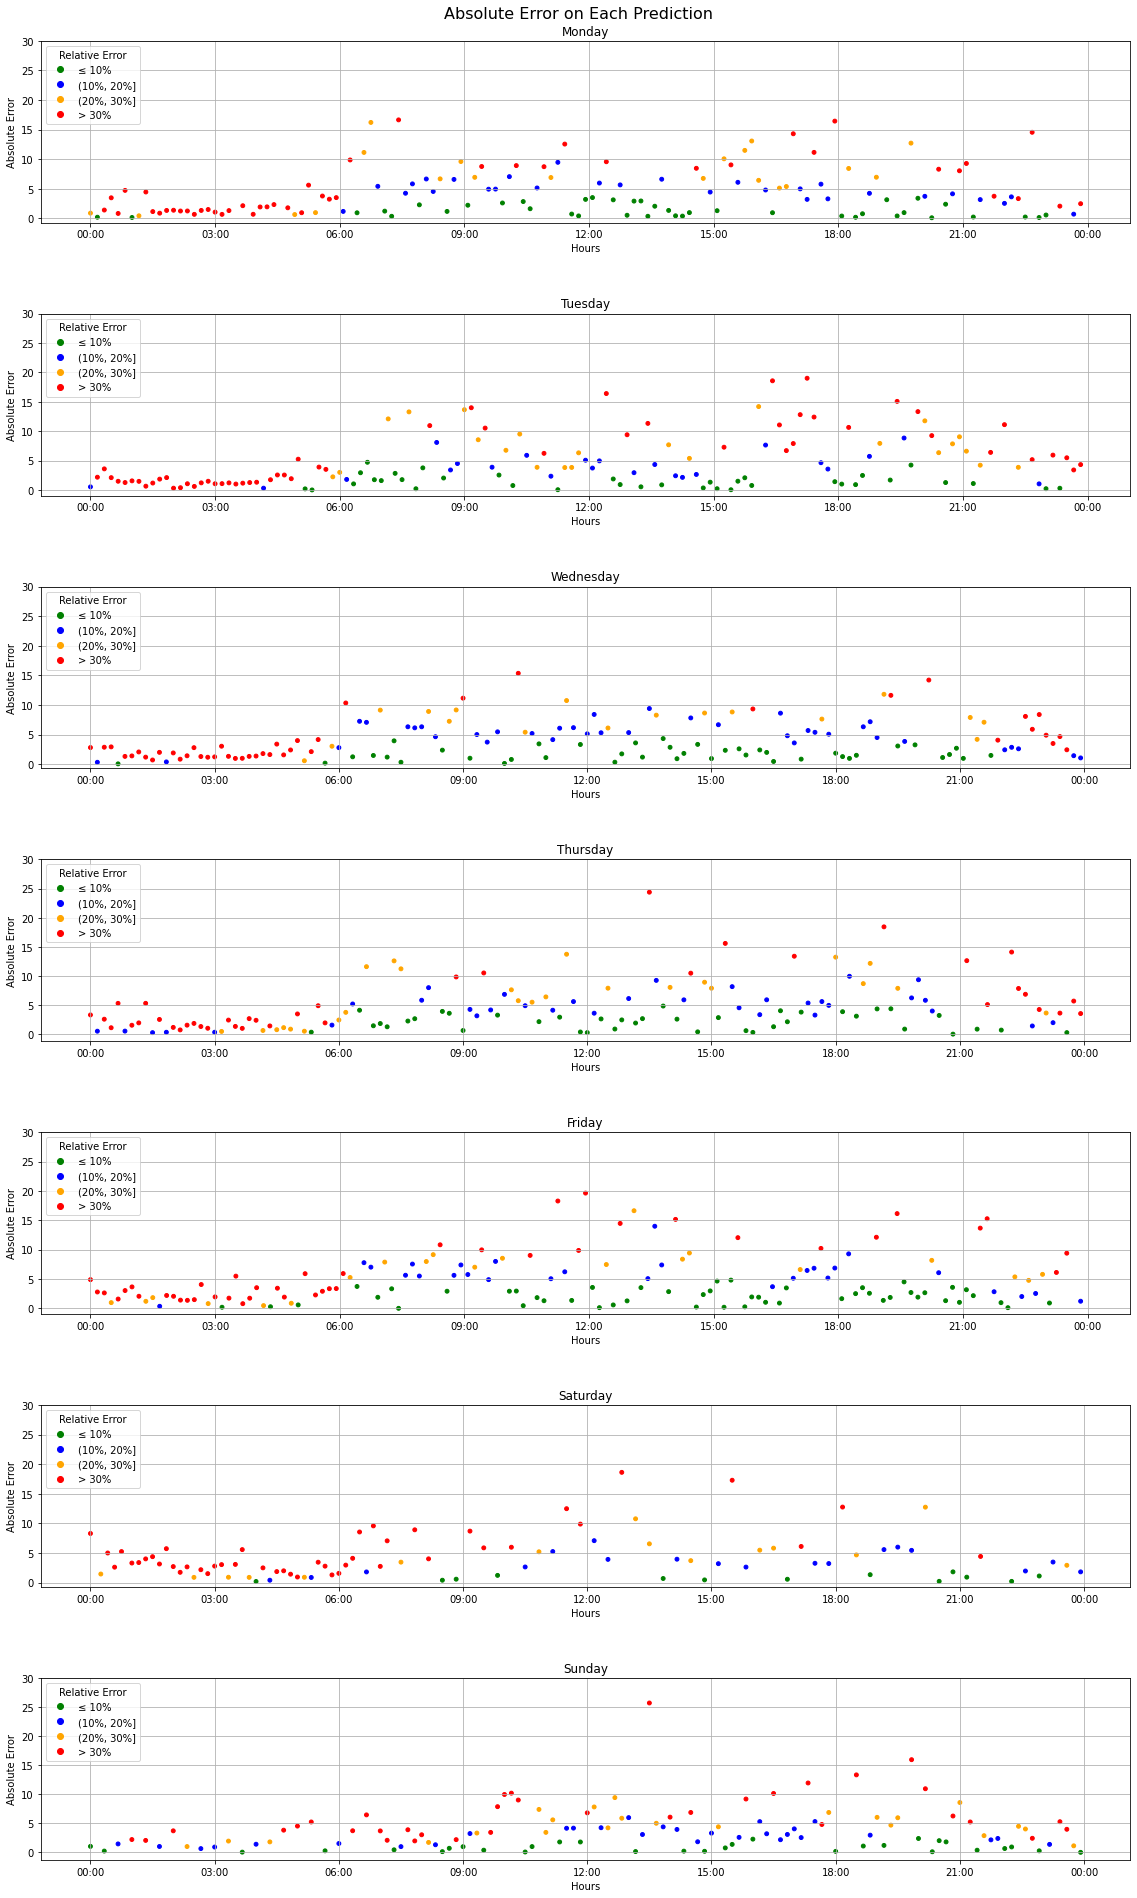

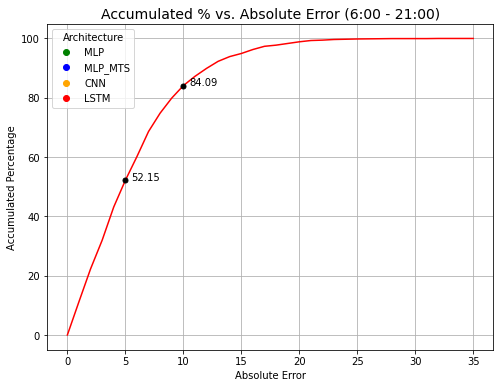

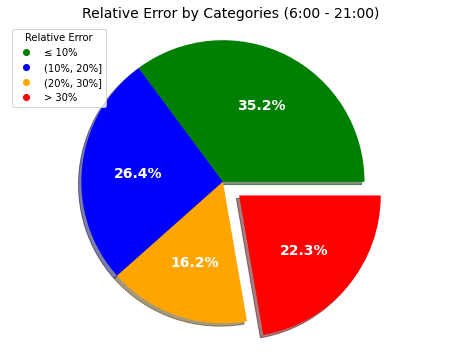

In [268]:
errors = graph_errors(pd.DataFrame(test_dates, columns= ['datetime']), pd.DataFrame(test_outputs,  columns= ['label_PM072']), predictions, freq = 4)

In [50]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return np.tanh(x)

def RELU(x):
    x1=[]
    for i in x:
        if i<0:
            x1.append(0)
        else:
            x1.append(i)
    return x1

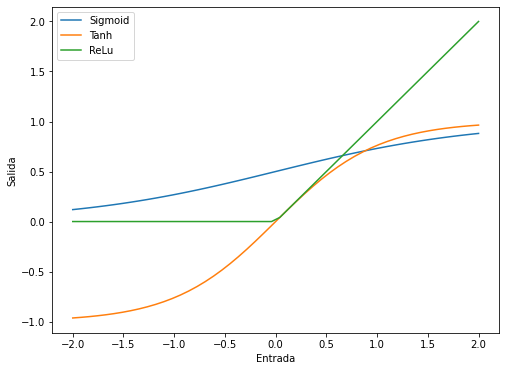

In [52]:
# Para las funciones de activacion
x = np.linspace(-2, 2)
plt.plot(x, sigmoid(x), label="Sigmoid")
plt.plot(x, tanh(x),  label="Tanh")
plt.plot(x, RELU(x),  label="ReLu")
plt.axis('tight')
plt.xlabel("Entrada")
plt.ylabel("Salida")
plt.legend(loc="upper left")
plt.savefig('../img/activations.png', bbox_inches='tight', transparent=True, dpi=300)

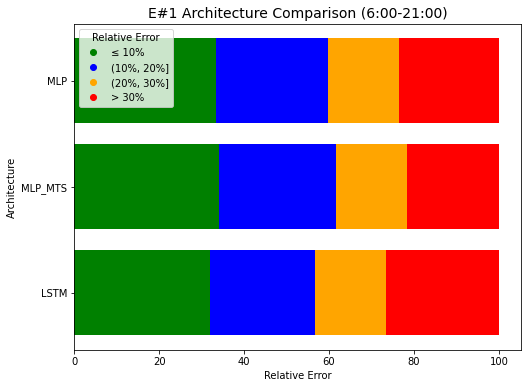

In [ ]:
# Para los diagramas de barras con el error relativo
labels = ['MLP', 'MLP_MTS', 'LSTM']
values_10 = [33.3, 34.1, 32.0]
values_10_20 = [26.4, 27.5, 24.7]
values_20_30 = [16.8, 16.7, 16.7]
values_30 = [23.6, 21.8, 26.7]
colors = {'≤ 10%':'green', '(10%, 20%]':'blue', '(20%, 30%]':'orange', '> 30%':'red'}

fig, ax = plt.subplots()
ax.barh(labels, values_10, color="green")
ax.barh(labels, values_10_20, left=values_10, color="blue")
ax.barh(labels, values_20_30, left=([values_10[i] + values_10_20[i] for i in range(len(values_10))]), color="orange")
ax.barh(labels, values_30, left=([values_10[i] + values_10_20[i] + values_20_30[i] for i in range(len(values_10))]), color="red")

ax.set_xticks(np.arange(0, 120, 20))
ax.invert_yaxis()
ax.set_xlabel('Relative Error')
ax.set_ylabel('Architecture')
ax.set_title('E#1 Architecture Comparison (6:00-21:00)', fontsize=14)

legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in colors.items()]
ax.legend(handles=legend_labels, loc='upper left', title="Relative Error")

#plt.savefig('../img/E1_Rel_Err.png', bbox_inches='tight', transparent=True, dpi=300)

dict_keys(['green', 'red', 'orange', 'blue'])

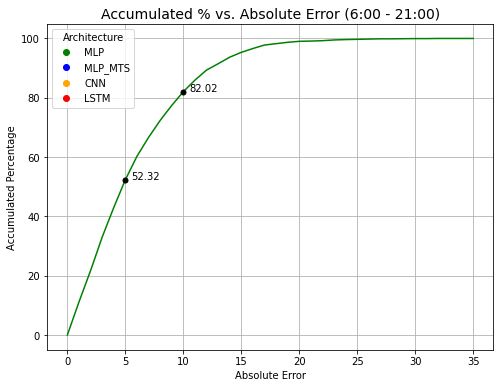

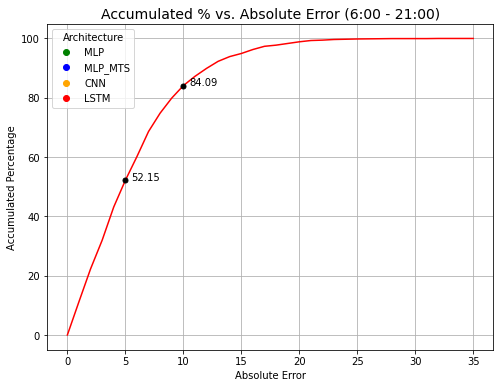

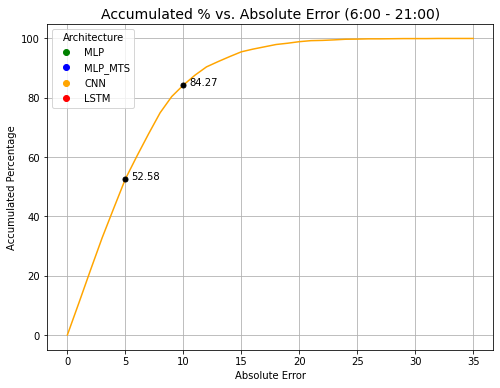

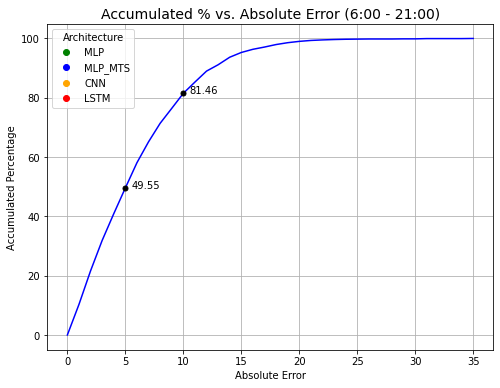

In [271]:
# Para las curvas con zoom
import os

directory = '../graphs/E4/'
graphs_dict = {}
x = np.arange(0, 36, 1) # 0..35

for filename in os.listdir(directory):
    if filename.endswith(".pickle"):
        g = pickle.load(open(directory+filename, "rb"))
        g_handler = plt.gca()
        line = g_handler.lines[0]

        graphs_dict[line.get_color()] = line.get_ydata()
    else:
        continue

graphs_dict.keys()

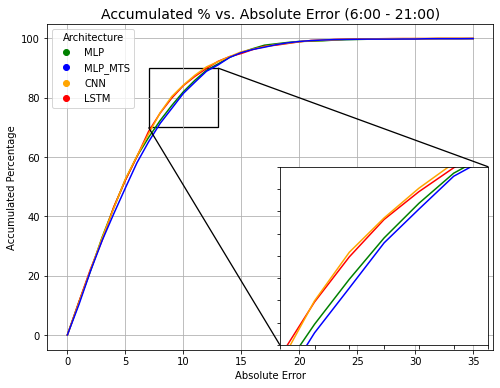

In [272]:
fig, ax = plt.subplots()

for c_line, ys in graphs_dict.items():
    ax.plot(x, ys, c=c_line, linestyle='-')

ax.set(xlabel='Absolute Error', ylabel='Accumulated Percentage')

arch = {'MLP':'green', 'MLP_MTS':'blue', 'CNN':'orange', 'LSTM':'red'}
legend_labels = [(mlines.Line2D([], [], color=value, marker='o', ls='', label=key)) for key, value in arch.items()]
ax.legend(handles=legend_labels, loc='upper left', title="Architecture")
ax.set_title('Accumulated % vs. Absolute Error (6:00 - 21:00)', fontsize=14)
ax.grid()

axins = zoomed_inset_axes(ax, 3, loc=4 )# zoom = 6
for c_line, ys in graphs_dict.items():
    axins.plot(x, ys, c=c_line, linestyle='-')

x1, x2, y1, y2 = 7, 13, 70, 90
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec='black', lw=1.3)

plt.savefig('../img/zoom_E4.png', bbox_inches='tight', transparent=True, dpi=300)